In [1]:
## Import necessary libraries - should work mostly from BCI_analysis + matplotlib + numpy
import BCI_analysis
from BCI_analysis.pipeline import pipeline_regression
import importlib
importlib.reload(pipeline_regression)
importlib.reload(BCI_analysis)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


In [2]:
#load multi-session mat files

#multisession_mat_file = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_new_old2.mat")
multisession_mat_file = os.path.abspath("/home/jupyter/temp/combined_new_old2.mat")
#multisession_mat_file_behavior = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_behavior.mat")
multisession_mat_file_behavior = os.path.abspath("/home/jupyter/temp/combined_behavior.mat")

# print('loading multi-session imaging data...')
multi_session_data = BCI_analysis.io_matlab.read_multisession_mat_2022(multisession_mat_file)
print('loading multi-session behavior data...')
multi_session_behavior_data = BCI_analysis.io_matlab.read_multisession_behavior_mat(multisession_mat_file_behavior)



loading multi-session behavior data...


In [3]:
# using data from .mat file 
from oasis.functions import deconvolve
importlib.reload(BCI_analysis)
dlc_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/")
aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned/")
plt_save_path = os.path.abspath("/home/jupyter/Plots/")
face_rhythm_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/FaceRhythm/'
motion_energy_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy/Bergamo-2P-Photostim/")
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")

multi_session_dict = {'mouse':[],
                     'session':[],
                      'mat_idx':[],
                     'cn':[],
                     'DLC_aligned':[],
                     'F':[],
                     'trial_end_frames':[],
                     'F_original':[],
                     'trial_start_original':[],
                     'reward_original':[],
                     'photostim_distance':[],
                     'photostim_amplitude':[],
                     'photostim_amplitude_error':[],                      
                     'photostim_group':[],
                     'photostim_cell':[],
                     'F0':[]}
#needed_subject = 'BCI34'
do_deconvolve = False
for mat_session_index in range(len(multi_session_behavior_data['session'])):
    # if multi_session_behavior_data['mouse'][mat_session_index] != needed_subject:
    #     continue
    # try:
    try:
        mouse = multi_session_behavior_data['mouse'][mat_session_index][:3]+'_'+multi_session_behavior_data['mouse'][mat_session_index][3:]
    except:
        print('mouse ID missing, skipping')
        continue
    session = multi_session_behavior_data['session'][mat_session_index]
    camera = "side"
    data = {'F':multi_session_behavior_data['df_closedLoop'][mat_session_index].T,
           'trial_start':multi_session_behavior_data['trial_start'][mat_session_index],
           'reward':multi_session_behavior_data['rew'][mat_session_index],
           'cn':int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1,
           'si':multi_session_behavior_data['dt_si'][mat_session_index].tolist()}

    if do_deconvolve:
        spikes_matrix= []
        for F_trace in data['F']:
            c, s, b_, g_, lam = deconvolve(F_trace, penalty=1) 
            spikes_matrix.append(s)
        data['F'] = np.asarray(spikes_matrix)


    dict_aligned = BCI_analysis.pipeline_align.get_aligned_data(suite2p_path, 
                                                                dlc_base_dir, 
                                                                bpod_path, 
                                                                sessionwise_data_path, 
                                                                aligned_data_path, 
                                                                motion_energy_base_dir,
                                                                raw_video_path,
                                                                mouse=mouse, 
                                                                FOV=None, 
                                                                camera=camera, 
                                                                session=session, 
                                                                sampling='down', 
                                                                functions = ['diff','diff_signed','mean'],
                                                                function_window = 20,  ### important variable for downsampling 1 for facerhythm - 20/200 for DLC
                                                                convolve_tau = 0.7, #.7
                                                                plot = False,
                                                                overwrite=False,
                                                                use_provided_data=True,
                                                                add_motion_energy = False,
                                                                source_data = data,
                                                                face_rhythm_base_dir = face_rhythm_base_dir,
                                                                use_face_rhythm = False,
                                                                match_with_face_rhythm = False)
    DLC_aligned = pd.DataFrame.from_dict(dict_aligned['DLC_aligned'])
    F = np.concatenate(dict_aligned['F_aligned'], axis=1)

    multi_session_dict['mouse'].append(multi_session_behavior_data['mouse'][mat_session_index])
    multi_session_dict['session'].append(multi_session_behavior_data['session'][mat_session_index])
    multi_session_dict['cn'].append(int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1)
    multi_session_dict['mat_idx'].append(mat_session_index)
    multi_session_dict['DLC_aligned'].append(DLC_aligned)
    multi_session_dict['F'].append(F)
    multi_session_dict['trial_end_frames'].append(dict_aligned['trial_start_indices'])
    multi_session_dict['F_original'].append(data['F'])
    multi_session_dict['trial_start_original'].append(data['trial_start'])
    multi_session_dict['reward_original'].append(multi_session_behavior_data['rew'][mat_session_index])
    multi_session_dict['photostim_distance'].append(multi_session_data['x'][mat_session_index])
    multi_session_dict['photostim_amplitude'].append(multi_session_data['y'][mat_session_index])
    multi_session_dict['F0'].append(np.nanmean(np.nanmean(multi_session_data['Fraw'][mat_session_index],0),1))
    multi_session_dict['photostim_amplitude_error'].append(multi_session_data['e'][mat_session_index])
    multi_session_dict['photostim_group'].append(multi_session_data['GRP'][mat_session_index])
    multi_session_dict['photostim_cell'].append(multi_session_data['id'][mat_session_index])

    #break
        
        
    # except:
    #     print('no luck with session {}'.format(mat_session_index))

print(dict_aligned.keys())



/home/jupyter/Scripts/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/062922-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/063022-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_33/070122-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/062922-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned/BCI_34/063022-dict_aligned-downsamp

In [328]:
multi_session_dict.keys()

dict_keys(['mouse', 'session', 'mat_idx', 'cn', 'DLC_aligned', 'F', 'trial_end_frames', 'F_original', 'trial_start_original', 'reward_original', 'photostim_distance', 'photostim_amplitude', 'photostim_amplitude_error', 'photostim_group', 'photostim_cell', 'F0', 'F_trialwise', 'F_rewardwise', 'amplitude', 'previous_amplitude', 'delta_amplitude', 'p_increase', 'p_decrease', 'baseline_amplitude', 'pairwise_correlations_matrix', 'pairwise_correlations_matrix_p', 'pearson_cc_with_cn', 'pearson_cc_with_cn_yesterday', 'F_trial_start'])

In [40]:
end_frame

27825

(622, 8137)

In [ ]:
# bootstrapping of amplitudes 
#
import BCI_analysis
import scipy
import umap
from sklearn.utils import resample
plot_amplitudes = True
multiple_correlations_per_pair = False
if multiple_correlations_per_pair:
    window_size_pearson = 1200
    pearson_corr_num = 100

max_p = .01#only for plotting significantly increasing cells
n_bootstrap = 1000
step_back = 40 #baseline before trial start (in frames)
step_forward = 200 #integration time after trial start (frames)
exclude_reward = True #
offset_to_keep_after_reward = 20 #frames after reward
use_reward = False # use changes after reward instead of trial start
#step_forward = 100 # FOR REWAAARD!!
exclude_reward_from_correlations = False
baseline_trial_num = 10
trace_time = np.arange(-step_back,step_forward)/20
# check if CNs are really increasing it's activity - who are the other cells that increase their activity
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise'] = [] #time x neuron x trial
multi_session_dict['amplitude'] = []
multi_session_dict['previous_amplitude'] = []
multi_session_dict['delta_amplitude'] = []
multi_session_dict['p_increase'] = []
multi_session_dict['p_decrease'] = []
multi_session_dict['baseline_amplitude'] = []
if 'pairwise_correlations_matrix' in multi_session_dict.keys():
    cc_already_done = True
else:
    cc_already_done = False
    multi_session_dict['pairwise_correlations_matrix'] = []
    if multiple_correlations_per_pair:
        multi_session_dict['pairwise_correlations_trace_matrix'] = []
    multi_session_dict['pairwise_correlations_matrix_p'] = []
    multi_session_dict['pearson_cc_with_cn'] = []
    multi_session_dict['pearson_cc_with_cn_yesterday'] = []
#cc_already_done = False
    
for session_i,session in enumerate(multi_session_dict['session']):
    print([multi_session_dict['mouse'][session_i],session])
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    
    F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            multi_session_dict['reward_original'][session_i],
                                                                            max_frames=None,
                                                                            frames_after=5, 
                                                                            frames_before=5,
                                                                            include_next_trial=True)
    if exclude_reward:
        F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple_exclude_reward(multi_session_dict['F_original'][session_i],
                                                                                                trial_start_trace,
                                                                                                multi_session_dict['reward_original'][session_i],
                                                                                                max_frames=None,
                                                                                                frames_after=step_forward, 
                                                                                                frames_before=step_back,
                                                                                                invert = True,
                                                                                                offset_to_keep = offset_to_keep_after_reward)
    elif use_reward:
        F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            multi_session_dict['reward_original'][session_i],
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
        
    else:
        F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    
    multi_session_dict['F_trialwise'].append(F_trialwise)
    multi_session_dict['F_rewardwise'].append(F_rewardwise)
    if not cc_already_done:
        F_to_use_for_correlations = multi_session_dict['F'][session_i].copy()
        if exclude_reward_from_correlations:
            corr_baseline_len = 40
            F_temp_list = []
            start_frames = np.where(multi_session_dict['trial_start_original'][session_i])[0]
            end_frames = np.concatenate([np.where(multi_session_dict['trial_start_original'][session_i])[0][1:],[len(multi_session_dict['trial_start_original'][session_i])]])
            reward_frames = np.where(multi_session_dict['reward_original'][session_i])[0]
            for start_frame,end_frame in zip(start_frames,end_frames):
                if any((reward_frames>start_frame)& (reward_frames<end_frame)):
                    end_frame = reward_frames[(reward_frames>start_frame)& (reward_frames<end_frame)][0]
                if corr_baseline_len>0 and start_frame>corr_baseline_len:
                    F_temp_list.append(F_to_use_for_correlations[:,start_frame:end_frame]-np.nanmean(F_to_use_for_correlations[:,start_frame-corr_baseline_len:start_frame],1)[:,np.newaxis])
                else:
                    F_temp_list.append(F_to_use_for_correlations[:,start_frame:end_frame])
            F_to_use_for_correlations= np.concatenate(F_temp_list,1)
        pearson_correlation_matrix_all_cells = np.ones([F_to_use_for_correlations.shape[0]]*2)*np.nan
        pearson_correlation_matrix_p_all_cells = np.ones([F_to_use_for_correlations.shape[0]]*2)*np.nan
        pearson_correlation_matrix_population_all_cells = np.asarray(np.ones([F_to_use_for_correlations.shape[0]]*2)*np.nan,dtype = object)
        frame_num =F_to_use_for_correlations.shape[1]
        for neuron_id_to_compare in np.arange(F_to_use_for_correlations.shape[0]):  #multi_session_dict['cn'][session_i]:
            for neuron_idx in np.arange(neuron_id_to_compare,F_to_use_for_correlations.shape[0]):
                if neuron_idx == neuron_id_to_compare:#multi_session_dict['cn'][session_i]:
                    pearsons_R = np.nan
                    pearsons_p = np.nan
                    corr_list = []
                else:
                    pearsons_R, pearsons_p = scipy.stats.pearsonr(F_to_use_for_correlations[neuron_idx,:],
                                                                   F_to_use_for_correlations[neuron_id_to_compare,:])
                    if multiple_correlations_per_pair:
                        corr_list = []
                        window_center_list = []
                        window_step_pearson = int((frame_num-window_size_pearson)/pearson_corr_num)
                        for wstart in np.arange(0,frame_num-window_size_pearson,window_step_pearson):
                            wend = wstart + window_size_pearson
                            window_center_list.append(wstart+window_size_pearson/2)
                            pearsons_R, pearsons_p = scipy.stats.pearsonr(F_to_use_for_correlations[neuron_idx,wstart:wend],  F_to_use_for_correlations[neuron_id_to_compare,wstart:wend])
                            corr_list.append(pearsons_R)
                # if len(corr_list)>0:
                #     asdasd
                pearson_correlation_matrix_all_cells[neuron_id_to_compare,neuron_idx] = pearsons_R
                pearson_correlation_matrix_p_all_cells[neuron_id_to_compare,neuron_idx] = pearsons_p
                
                pearson_correlation_matrix_population_all_cells[neuron_id_to_compare,neuron_idx] = np.asarray(corr_list)
        #asdasd
        multi_session_dict['pairwise_correlations_matrix'].append(pearson_correlation_matrix_all_cells)
        if multiple_correlations_per_pair:
            multi_session_dict['pairwise_correlations_trace_matrix'].append(pearson_correlation_matrix_population_all_cells)
        multi_session_dict['pairwise_correlations_matrix_p'].append(pearson_correlation_matrix_p_all_cells)
    
    
    
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session

            
            pearson_correlation_matrix_all_cells = multi_session_dict['pairwise_correlations_matrix'][session_i]
            pearson_correlation_matrix_all_cells_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            cn = multi_session_dict['cn'][session_i]
            pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
            multi_session_dict['pearson_cc_with_cn'].append(pearson_list)
            pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
            multi_session_dict['pearson_cc_with_cn_yesterday'].append(pearson_list_yesterday)
            
            now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
            prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
            real_deltas = np.nanmean(now_amplitudes,1)-np.nanmean(prev_amplitudes,1)
            cn = multi_session_dict['cn'][session_i]

            
            prev_mean_amplitude_bootstrap_list = []
            now_mean_amplitude_bootstrap_list = []

            for bootstrap_i in range(n_bootstrap):
                now_indices = resample(np.arange(now_amplitudes.shape[1]))
                now_mean_amplitude_bootstrap_list.append(np.mean(now_amplitudes[:,now_indices],1))
                prev_indices = resample(np.arange(prev_amplitudes.shape[1]))
                prev_mean_amplitude_bootstrap_list.append(np.mean(prev_amplitudes[:,prev_indices],1))
            now_mean_amplitude_bootstrap_list = np.asarray(now_mean_amplitude_bootstrap_list)
            prev_mean_amplitude_bootstrap_list = np.asarray(prev_mean_amplitude_bootstrap_list)
            delta_amplitudes_bootstrap = now_mean_amplitude_bootstrap_list-prev_mean_amplitude_bootstrap_list
            delta_sd = np.std(delta_amplitudes_bootstrap,0)


            cell_order = np.argsort(real_deltas)
            significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cell_order]<max_p
            significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)[cell_order]<max_p
            
            multi_session_dict['delta_amplitude'].append(real_deltas)
            multi_session_dict['p_increase'].append(1-np.nanmean(delta_amplitudes_bootstrap>0,0))
            multi_session_dict['p_decrease'].append(1-np.nanmean(delta_amplitudes_bootstrap<0,0))
            multi_session_dict['amplitude'].append(np.nanmean(now_amplitudes,1))
            multi_session_dict['previous_amplitude'].append(np.nanmean(prev_amplitudes,1))
            baseline_amplitudes = np.nanmean(now_amplitudes[:,:baseline_trial_num],1)
            multi_session_dict['baseline_amplitude'].append(baseline_amplitudes)
            if plot_amplitudes:
                fig = plt.figure(figsize = [15,30])
                ax = fig.add_subplot(6,2,1)

                ax.plot(np.argmax(cell_order==cn),real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.errorbar(np.arange(len(cell_order)),real_deltas[cell_order],yerr = delta_sd[cell_order],fmt='.',color = 'black',alpha = .5)
                ax.plot(np.arange(len(cell_order))[significantly_increasing_indices],real_deltas[cell_order][significantly_increasing_indices],'ro')
                ax.plot(np.arange(len(cell_order))[significantly_decreasing_indices],real_deltas[cell_order][significantly_decreasing_indices],'bo')
                ax.set_xlabel('cell#')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))
                significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)<max_p
                significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)<max_p
                #now_ampls = sklearn.utils.resample(now_amplitudes)

                ax = fig.add_subplot(6,2,2)
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(np.nanmean(prev_amplitudes,1),real_deltas,'.',color = 'black')
                ax.errorbar(np.nanmean(prev_amplitudes,1),real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Amplitude in previous session (dF/F)')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))     
                ax = fig.add_subplot(6,2,4)
                today_deltas = np.nanmean(now_amplitudes,1)-baseline_amplitudes
                #ax.plot(today_deltas,real_deltas,'k.')
                
                ax.plot(today_deltas[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(today_deltas,real_deltas,'.',color = 'black')
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(today_deltas[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(today_deltas[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Delta amplitude relative to first {} trials (dF/F)'.format(baseline_trial_num))
                ax.set_ylabel('Delta amplitude (dF/F)')
                
                
                ax = fig.add_subplot(6,2,3)
                
                
                ax.plot(pearson_list_yesterday[cn],pearson_list[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(pearson_list_yesterday,pearson_list,'.',color = 'black')
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(pearson_list_yesterday[significantly_increasing_indices],pearson_list[significantly_increasing_indices],'ro')
                ax.plot(pearson_list_yesterday[significantly_decreasing_indices],pearson_list[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Pearson correlation with CN on control day')
                ax.set_ylabel('Pearson correlation with CN on conditioning day')
                limits = [ax.get_xlim(),ax.get_ylim()]
                limits = [np.min(limits),np.max(limits)]
                ax.set_xlim(limits)
                ax.set_ylim(limits)
                
                pearson_correlation_matrix_all_cells = multi_session_dict['pairwise_correlations_matrix'][session_i]
                pearson_correlation_matrix_all_cells_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]
                pearson_2_list = []
                pearson_2_p_list = []
                for cell_idx in np.arange(pearson_correlation_matrix_all_cells.shape[0]):
                    x = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cell_idx,:],pearson_correlation_matrix_all_cells[:,cell_idx]],0).flatten()
                    y = pearson_list = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cell_idx,:],pearson_correlation_matrix_all_cells_yesterday[:,cell_idx]],0).flatten()
                    needed = (np.isnan(x)==False) & (np.isnan(y)==False)
                    pearsons_R, pearsons_p = scipy.stats.pearsonr(x[needed],y[needed])
                    pearson_2_list.append(pearsons_R)
                    pearson_2_p_list.append(pearsons_p)
                pearson_2_list = np.asarray(pearson_2_list)
                pearson_2_p_list = np.asarray(pearson_2_p_list)
                significant = pearson_2_p_list<.01
                insignificant = pearson_2_p_list>=.01
                ax = fig.add_subplot(6,2,5)
                ax.plot(pearson_2_list[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                
                ax.plot(pearson_2_list[insignificant],real_deltas[insignificant],'.',color = 'black',alpha = .2)
                ax.plot(pearson_2_list[significant],real_deltas[significant],'.',color = 'black',alpha = 1)
                #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(pearson_2_list[significantly_increasing_indices&insignificant],real_deltas[significantly_increasing_indices&insignificant],'ro',alpha = .2)
                ax.plot(pearson_2_list[significantly_decreasing_indices&insignificant],real_deltas[significantly_decreasing_indices&insignificant],'bo',alpha = .2)
                ax.plot(pearson_2_list[significantly_increasing_indices&significant],real_deltas[significantly_increasing_indices&significant],'ro',alpha = 1)
                ax.plot(pearson_2_list[significantly_decreasing_indices&significant],real_deltas[significantly_decreasing_indices&significant],'bo',alpha = 1)
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_xlabel('Correlation of pairwise correlation coefficients from day to day')
                
                
                ax = fig.add_subplot(6,2,6)
                
                ax.plot(np.nanmean(prev_amplitudes,1),np.nanmean(now_amplitudes,1),'k.',alpha= .5)#real_deltas,
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],np.nanmean(now_amplitudes,1)[cn],'mx',markersize = 20,markeredgewidth = 4)
                
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],np.nanmean(now_amplitudes,1)[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],np.nanmean(now_amplitudes,1)[significantly_decreasing_indices],'bo')
                limits = np.concatenate([ax.get_xlim(),ax.get_ylim()])
                limits = [np.min(limits),np.max(limits)]
                ax.set_xlim(limits)
                ax.set_ylim(limits)
                ax.set_xlabel('Amplitude on previous session')
                ax.set_ylabel('Amplitude on conditioning session')
                
                amplitude_color_edges = np.percentile(np.concatenate([np.nanmean(now_amplitudes,1),np.nanmean(prev_amplitudes,1)]),[5,95])
                
                
                ax = fig.add_subplot(6,2,7)
                matrix_now = np.nanmean([pearson_correlation_matrix_all_cells_yesterday,pearson_correlation_matrix_all_cells_yesterday.T],0)
                matrix_now[np.isnan(matrix_now)] = 1
                reducer = umap.UMAP()

                #sil = []
                #kmax = 20
                reducer.n_neighbors=5
                reducer.min_dist = 0.05 
                umap_embedding = reducer.fit_transform(matrix_now)

                coordinates = umap_embedding

                # ax.plot(coordinates[:,0],coordinates[:,1],'k.',alpha = .5)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= np.nanmean(prev_amplitudes,1),
                           alpha = .5,
                           vmin = amplitude_color_edges[0],
                          vmax =  amplitude_color_edges[1])
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - amplitude')
                
                ax = fig.add_subplot(6,2,9)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= real_deltas,
                           alpha = .5,
                           vmin = np.percentile(real_deltas,5),
                          vmax =  np.percentile(real_deltas,95))
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - deltaamplitude')
                
                
                ax = fig.add_subplot(6,2,8)
                matrix_now = np.nanmean([pearson_correlation_matrix_all_cells,pearson_correlation_matrix_all_cells.T],0)
                matrix_now[np.isnan(matrix_now)] = 1
                reducer = umap.UMAP()

                #sil = []
                #kmax = 20
                reducer.n_neighbors=5
                reducer.min_dist = 0.05 
                umap_embedding = reducer.fit_transform(matrix_now)

                coordinates = umap_embedding

                # ax.plot(coordinates[:,0],coordinates[:,1],'k.',alpha = .5)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                #ax.scatter(coordinates[:,0],coordinates[:,1],c= np.nanmean(now_amplitudes,1),alpha = .5) #-np.nanmean(prev_amplitudes,1)
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= np.nanmean(now_amplitudes,1),
                           alpha = .5,
                           vmin = amplitude_color_edges[0],
                           vmax =  amplitude_color_edges[1])
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs on conditioning session - amplitude')
                
                ax = fig.add_subplot(6,2,10)
                ax.plot(coordinates[cn,0],coordinates[cn,1],'mx',markersize = 20,markeredgewidth = 4)
                # #ax.errorbar(today_deltas,real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                # ax.plot(coordinates[significantly_increasing_indices,0],coordinates[significantly_increasing_indices,1],'ro')
                # ax.plot(coordinates[significantly_decreasing_indices,0],coordinates[significantly_decreasing_indices,1],'bo')
                ax.scatter(coordinates[:,0],
                           coordinates[:,1],
                           c= real_deltas,
                           alpha = .5,
                           vmin = np.percentile(real_deltas,5),
                          vmax =  np.percentile(real_deltas,95))
                ax.set_xlabel('UMAP1')
                ax.set_ylabel('UMAP2')
                ax.set_title('UMAP embedding of Pearson ccs from previous session - deltaamplitude')
                #asdasd
            continue
    multi_session_dict['delta_amplitude'].append([])
    multi_session_dict['p_increase'].append([])
    multi_session_dict['p_decrease'].append([])
    multi_session_dict['amplitude'].append([])
    multi_session_dict['previous_amplitude'].append([])
    multi_session_dict['pearson_cc_with_cn'].append([])
    multi_session_dict['pearson_cc_with_cn_yesterday'].append([])
    #asdsa
            
            

['BCI33', '062722']
['BCI33', '062822']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI33', '062922']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI33', '063022']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI33', '070122']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI34', '062722']
['BCI34', '062822']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI34', '062922']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI34', '063022']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI35', '062822']
['BCI35', '062922']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI35', '063022']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI35', '070122']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI37', '062822']
['BCI37', '062922']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI37', '063022']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

['BCI37', '070122']


/tmp/ipykernel_2904/430558588.py:143: RuntimeWarning: All-NaN axis encountered
  pearson_list = np.nanmax([pearson_correlation_matrix_all_cells[cn,:],pearson_correlation_matrix_all_cells[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:145: RuntimeWarning: All-NaN axis encountered
  pearson_list_yesterday = np.nanmax([pearson_correlation_matrix_all_cells_yesterday[cn,:],pearson_correlation_matrix_all_cells_yesterday[:,cn]],0).flatten()
/tmp/ipykernel_2904/430558588.py:148: RuntimeWarning: Mean of empty slice
  now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
/tmp/ipykernel_2904/430558588.py:149: RuntimeWarning: Mean of empty slice
  prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-p

In [1026]:
photostimmed_yesterday

array([], dtype=float64)

(array([1.000e+00, 0.000e+00, 4.000e+00, 6.900e+01, 1.414e+03, 4.398e+03,
        2.780e+02, 2.700e+01, 4.000e+00, 1.000e+00]),
 array([-0.6107171 , -0.49267759, -0.37463807, -0.25659855, -0.13855904,
        -0.02051952,  0.09751999,  0.21555951,  0.33359902,  0.45163854,
         0.56967805]),
 <BarContainer object of 10 artists>)

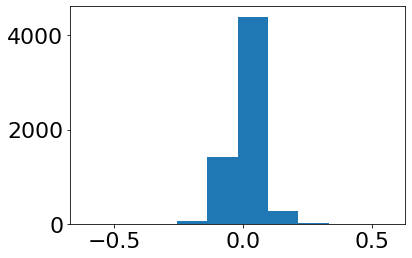

Text(0, 0.5, 'cumulative % of cells')

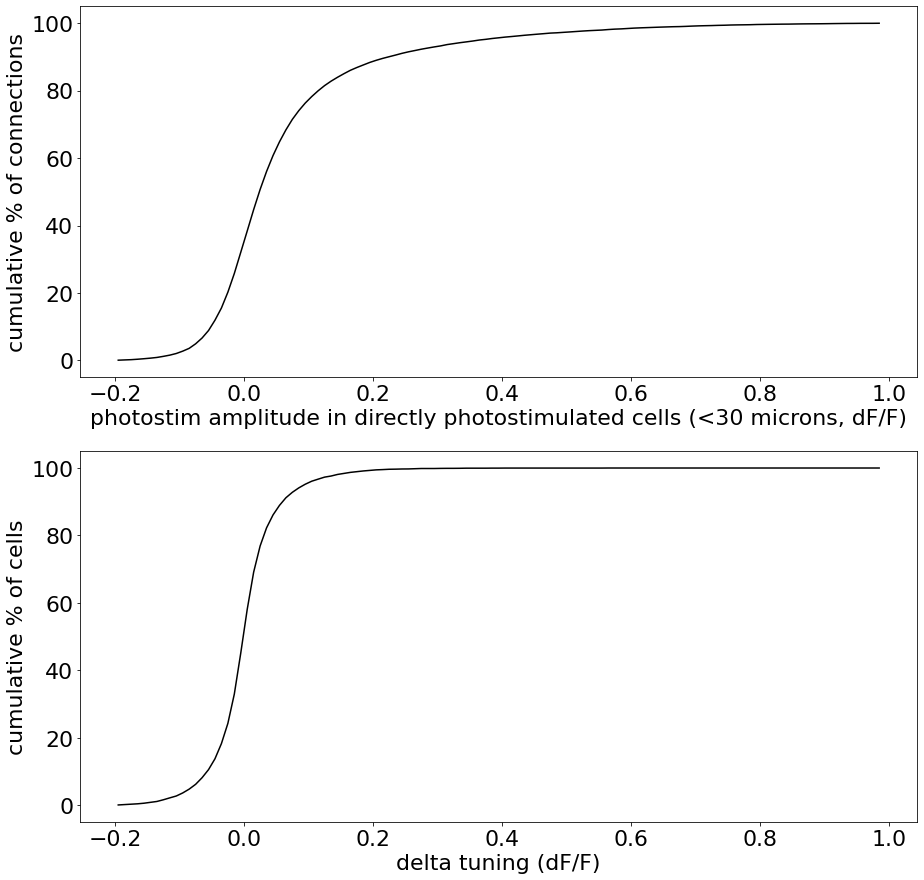

In [398]:
x_list = []
y_list = []
delta_amplitudes_list = []
for session_i in np.arange(len(multi_session_dict['session'])):
    x = multi_session_dict['photostim_distance'][session_i]    
    y = multi_session_dict['photostim_amplitude'][session_i]   
    needed = x<30
    x_list.append(x[needed])
    y_list.append(y[needed])
    delta_amplitudes_list.append(multi_session_dict['delta_amplitude'][session_i])
x = np.concatenate(x_list)
y = np.concatenate(y_list)
delta_amplitudes = np.concatenate(delta_amplitudes_list)
biny,binx = np.histogram(y,np.arange(-.2,1,.01))
ybin_ampl,xbin_ampl = np.histogram(delta_amplitudes,np.arange(-.2,1,.01))
xbin_ampl = np.nanmean([xbin_ampl[:-1],xbin_ampl[1:]],0)
binx = np.nanmean([binx[:-1],binx[1:]],0)
fig = plt.figure(figsize = [15,15])
ax = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax.plot(binx,100*np.cumsum(biny)/sum(biny),'k-')
ax.set_xlabel('photostim amplitude in directly photostimulated cells (<30 microns, dF/F)')
ax.set_ylabel('cumulative % of connections')
ax2.plot(xbin_ampl,100*np.cumsum(ybin_ampl)/sum(ybin_ampl),'k-')
ax2.set_xlabel('delta tuning (dF/F)')
ax2.set_ylabel('cumulative % of cells')
#plt.hist(y,100)

Text(0, 0.5, 'count')

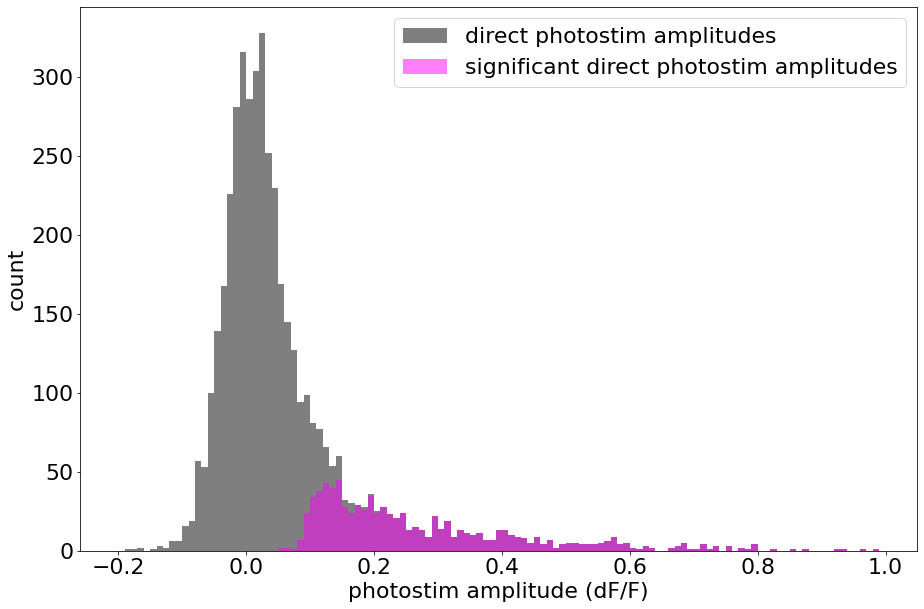

In [421]:
fig = plt.figure(figsize = [15,10])
plt.hist(all_amplitudes_today,np.arange(-.2,1,.01),alpha = .5,color = 'black',label = 'direct photostim amplitudes')
plt.hist(amplitude_today[photostimmed_today],np.arange(-.2,1,.01),alpha = .5,color = 'magenta',label = 'significant direct photostim amplitudes')
plt.legend()
plt.xlabel('photostim amplitude (dF/F)')
plt.ylabel('count')

/tmp/ipykernel_21905/227785011.py:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  photostimmed_yesterday_list = np.asarray(photostimmed_yesterday_list)
/tmp/ipykernel_21905/227785011.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  photostimmed_today_list = np.asarray(photostimmed_today_list)
/tmp/ipykernel_21905/227785011.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must

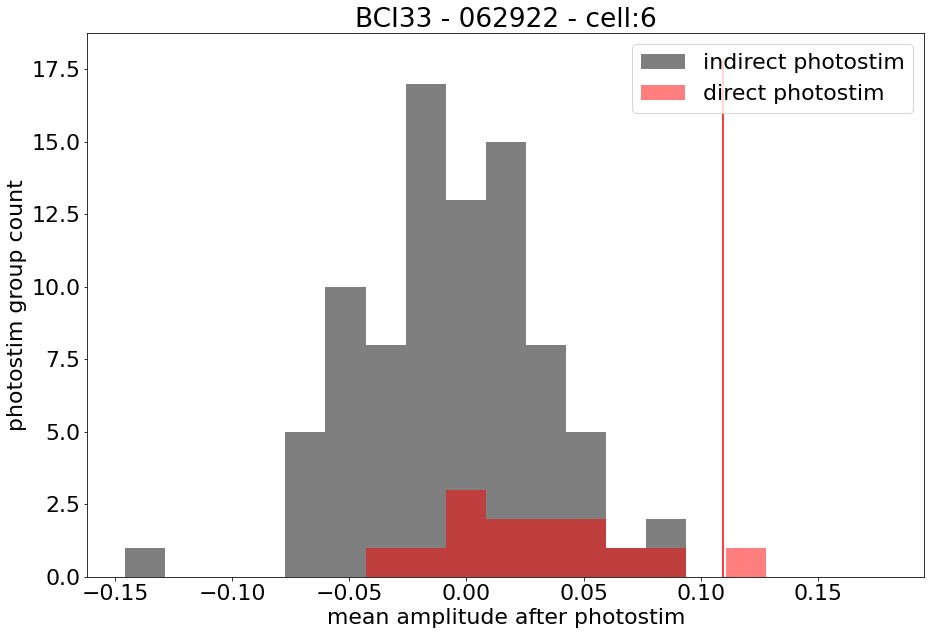

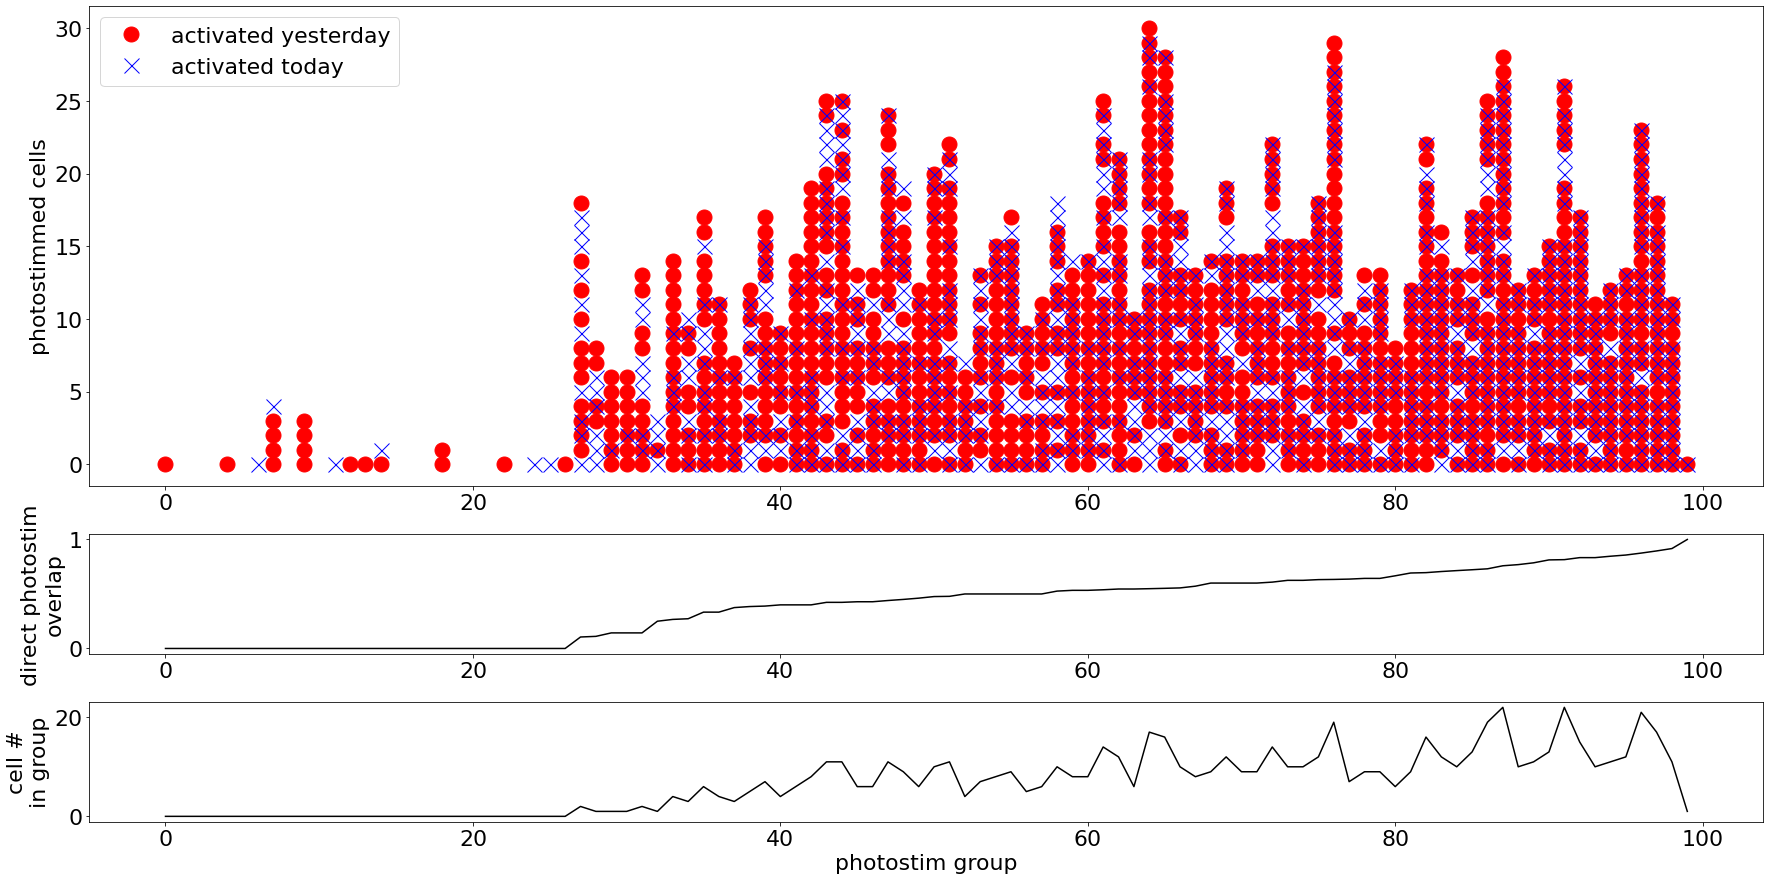

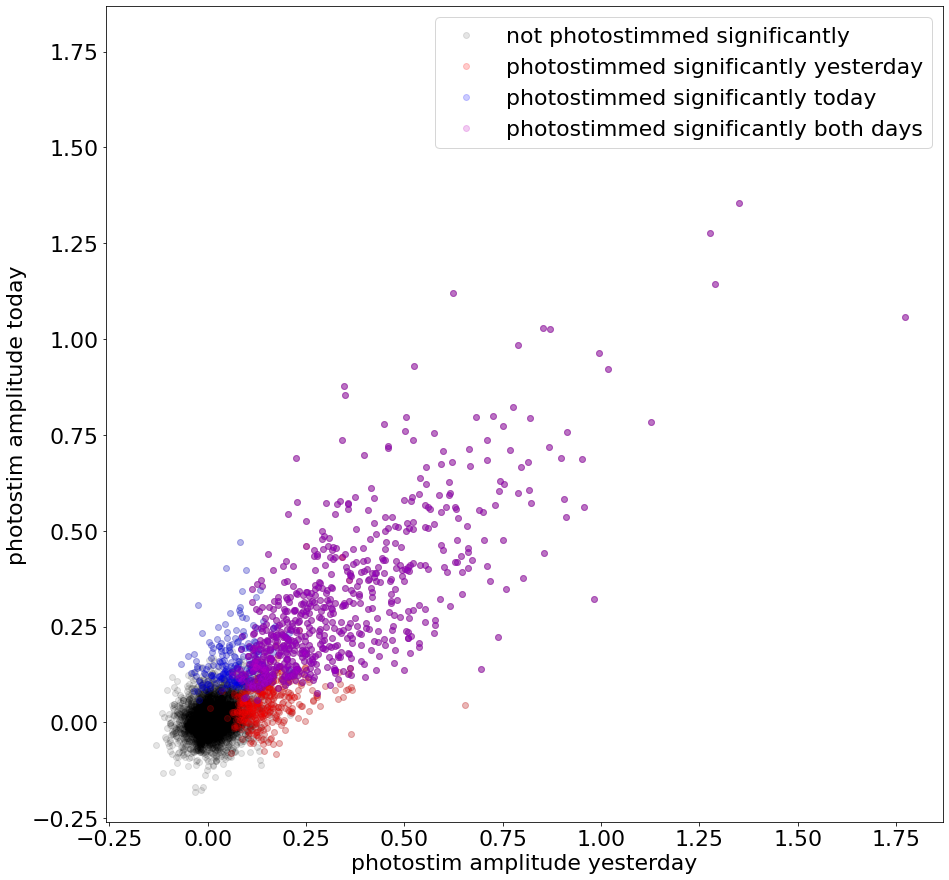

In [420]:
threshold_list = []
threshold_list_yesterday = []
session_i = 2
amplitude_min_std = 3
distance_threshold = 30 # for direct photostim
distance_border = 0 # threshold +- this will be ignored..
distance_border_for_distribution = 1
for pre_cell_now in np.arange(len(np.unique(np.asarray(multi_session_dict['photostim_cell'][session_i])))):
    all_amplitudes =  multi_session_dict['photostim_amplitude'][session_i][(np.asarray(multi_session_dict['photostim_cell'][session_i])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i]>=distance_threshold+distance_border_for_distribution)]
    photostim_amplitudes =  multi_session_dict['photostim_amplitude'][session_i][(np.asarray(multi_session_dict['photostim_cell'][session_i])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i]<=distance_threshold-distance_border_for_distribution)]
    threshold = np.nanmedian(all_amplitudes)+np.nanstd(all_amplitudes)*amplitude_min_std
    threshold_list.append(threshold)

    all_amplitudes_yesterday =  multi_session_dict['photostim_amplitude'][session_i-1][(np.asarray(multi_session_dict['photostim_cell'][session_i-1])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i-1]>=distance_threshold+distance_border_for_distribution)]
    threshold = np.nanmedian(all_amplitudes_yesterday)+np.nanstd(all_amplitudes_yesterday)*amplitude_min_std
    threshold_list_yesterday.append(threshold)
    if pre_cell_now ==6:        
        photostim_threshold = np.nanmedian(all_amplitudes)+np.nanstd(all_amplitudes)*amplitude_min_std
        fig = plt.figure(figsize = [15,10])
        ax= fig.add_subplot(1,1,1)
        bin_edges = np.percentile(np.concatenate([all_amplitudes,photostim_amplitudes]),[0,100])
        bin_xs = np.arange(bin_edges[0],bin_edges[1],np.diff(bin_edges)/20)
        ax.hist(all_amplitudes,bin_xs,color = 'black',label = 'indirect photostim',alpha = .5)
        ax.hist(photostim_amplitudes,bin_xs,color= 'red',label = 'direct photostim',alpha = .5)
        ax.set_xlabel('mean amplitude after photostim')
        ax.set_ylabel('photostim group count')
        ax.vlines(photostim_threshold,ax.get_ylim()[0],ax.get_ylim()[1],color='red')
        ax.legend()
        ax.set_title('{} - {} - cell:{}'.format(multi_session_dict['mouse'][session_i],multi_session_dict['session'][session_i],pre_cell_now))
threshold_list = np.asarray(threshold_list)
threshold_list_yesterday = np.asarray(threshold_list_yesterday)
photostim_overlap_list = []
photostimmed_yesterday_list = []
photostimmed_today_list = []
photostimmed_cell_num_list = []

photostim_amplitude_list = []
photostim_amplitude_yesterday_list = []

all_amplitudes_yesterday = []
all_amplitudes_today = []
fig = plt.figure(figsize = [30,15])

from matplotlib.gridspec import GridSpec
gs = GridSpec(3, 1,  height_ratios=[4, 1,1])
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1],sharex = ax)
ax3 = fig.add_subplot(gs[2],sharex = ax)

#ax = fig.add_subplot(2,1,1)
for photostim_group in np.unique(multi_session_dict['photostim_group'][session_i]):
    pre_cells = np.asarray(multi_session_dict['photostim_cell'][session_i][(multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)],int)-1
    pre_cell_indices = (multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)
    pre_amplitudes = multi_session_dict['photostim_amplitude'][session_i][pre_cell_indices] # on second day
    pre_cells_yesterday = np.asarray(multi_session_dict['photostim_cell'][session_i-1][(multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)],int)-1
    pre_cell_indices_yesterday = (multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)
    pre_amplitudes_yesterday = multi_session_dict['photostim_amplitude'][session_i-1][pre_cell_indices_yesterday] # on second day
    pre_active_cells = pre_amplitudes>threshold_list[pre_cells]

    pre_active_cells_yesterday = pre_amplitudes_yesterday>threshold_list_yesterday[pre_cells_yesterday]

    photostimmed_in_both = 0
    photostimmed_in_one = 0
    pre_cells_yesterday_ = pre_cells_yesterday.copy()
    pre_active_cells_yesterday_ = pre_active_cells_yesterday.copy()
    photostimmed_yesterday = []
    photostimmed_today = []
    amplitude_yesterday = []
    amplitude_today = []
    
    for pre_cell_now,isactive in zip(pre_cells,pre_active_cells):
        
        long_idx = np.where((multi_session_dict['photostim_cell'][session_i] == pre_cell_now+1) & (multi_session_dict['photostim_group'][session_i]==photostim_group))[0][0]
        all_amplitudes_yesterday.append(multi_session_dict['photostim_amplitude'][session_i-1][long_idx])
        all_amplitudes_today.append(multi_session_dict['photostim_amplitude'][session_i][long_idx])
        if pre_cell_now in pre_cells_yesterday_:
            pre_idx_yesterday = np.where(pre_cell_now == pre_cells_yesterday_)[0][0]
            isactive_yesterday = pre_active_cells_yesterday_[pre_idx_yesterday]
            if isactive and isactive_yesterday:
                photostimmed_in_both += 1
                photostimmed_yesterday.append(True)
                photostimmed_today.append(True)
                amplitude_yesterday.append(multi_session_dict['photostim_amplitude'][session_i-1][long_idx])
                amplitude_today.append(multi_session_dict['photostim_amplitude'][session_i][long_idx])
            elif isactive or isactive_yesterday:
                photostimmed_in_one+=1
                if isactive:
                    photostimmed_yesterday.append(False)
                    photostimmed_today.append(True)
                    amplitude_yesterday.append(multi_session_dict['photostim_amplitude'][session_i-1][long_idx])
                    amplitude_today.append(multi_session_dict['photostim_amplitude'][session_i][long_idx])
                else:
                    photostimmed_yesterday.append(True)
                    photostimmed_today.append(False)
                    amplitude_yesterday.append(multi_session_dict['photostim_amplitude'][session_i-1][long_idx])
                    amplitude_today.append(multi_session_dict['photostim_amplitude'][session_i][long_idx])
            needed_indices__ = np.ones(len(pre_cells_yesterday_))==1
            needed_indices__[pre_idx_yesterday] = False
            pre_cells_yesterday_ = pre_cells_yesterday_[needed_indices__]
            pre_active_cells_yesterday_ = pre_active_cells_yesterday_[needed_indices__]
            
        else:
            if isactive:
                photostimmed_in_one+=1
                photostimmed_yesterday.append(False)
                photostimmed_today.append(True)
                amplitude_yesterday.append(multi_session_dict['photostim_amplitude'][session_i-1][long_idx])
                amplitude_today.append(multi_session_dict['photostim_amplitude'][session_i][long_idx])
        

    for pre_cell_now,isactive in zip(pre_cells_yesterday_,pre_active_cells_yesterday_):
        
        if isactive:
            photostimmed_in_one+=1
            photostimmed_yesterday.append(True)
            photostimmed_today.append(False)
            amplitude_yesterday.append(multi_session_dict['photostim_amplitude'][session_i-1][long_idx])
            amplitude_today.append(multi_session_dict['photostim_amplitude'][session_i][long_idx])
    try:
        photostim_overlap = photostimmed_in_both/(photostimmed_in_one+photostimmed_in_both)     
    except:
        photostim_overlap = 0
    
    photostimmed_today = np.asarray(photostimmed_today)
    photostimmed_yesterday = np.asarray(photostimmed_yesterday)
    photostim_overlap_list.append(photostim_overlap)
    photostimmed_yesterday_list.append(photostimmed_yesterday)
    photostimmed_today_list.append(photostimmed_today)
    
    photostim_amplitude_list.append(np.asarray(amplitude_today))
    photostim_amplitude_yesterday_list.append(np.asarray(amplitude_yesterday))
    try:
        photostimmed_cell_num_list.append(sum(photostimmed_today & photostimmed_yesterday))
    except:
        photostimmed_cell_num_list.append(0)
photostim_overlap_list  = np.asarray(photostim_overlap_list)
photostimmed_yesterday_list = np.asarray(photostimmed_yesterday_list)
photostimmed_today_list = np.asarray(photostimmed_today_list)
photostimmed_cell_num_list = np.asarray(photostimmed_cell_num_list)

photostim_amplitude_list = np.asarray(photostim_amplitude_list)
photostim_amplitude_yesterday_list = np.asarray(photostim_amplitude_yesterday_list)

for idx,photostim_group in enumerate(np.argsort(photostim_overlap_list)):
    photostimmed_yesterday = photostimmed_yesterday_list[photostim_group]
    photostimmed_today = photostimmed_today_list[photostim_group]
    if idx == 0:
        ax.plot(np.ones(sum(photostimmed_yesterday))*idx,np.where(photostimmed_yesterday)[0],'ro',ms = 15,label = 'activated yesterday')
        ax.plot(np.ones(sum(photostimmed_today))*idx,np.where(photostimmed_today)[0],'bx',ms = 15,label = 'activated today')
    else:
        ax.plot(np.ones(sum(photostimmed_yesterday))*idx,np.where(photostimmed_yesterday)[0],'ro',ms = 15)
        ax.plot(np.ones(sum(photostimmed_today))*idx,np.where(photostimmed_today)[0],'bx',ms = 15)
    #ax.text(idx,-1.5,'{}%'.format(int(photostim_overlap_list[photostim_group]*100)),ha = 'center',va='center',fontsize = 12,rotation = 'vertical')
#ax.set_ylim([-3,ax.get_ylim()[1]])
ax.set_ylabel('photostimmed cells')
ax.legend()
#ax2 = fig.add_subplot(2,1,2,sharex = ax)
ax2.plot(np.sort(photostim_overlap_list),'k-')

ax2.set_ylabel('direct photostim\noverlap')
ax3.plot(photostimmed_cell_num_list[np.argsort(photostim_overlap_list)],'k-')
ax3.set_ylabel('cell #\nin group')
ax3.set_xlabel('photostim group')



amplitude_yesterday = np.concatenate(photostim_amplitude_yesterday_list)
amplitude_today = np.concatenate(photostim_amplitude_list)
photostimmed_yesterday = np.concatenate(photostimmed_yesterday_list)==1
photostimmed_today = np.concatenate(photostimmed_today_list)==1
fig = plt.figure(figsize = [15,15])
ax = fig.add_subplot(1,1,1)
ax.plot(all_amplitudes_yesterday,all_amplitudes_today,'ko',alpha = .1,label = 'not photostimmed significantly')
ax.plot(amplitude_yesterday[photostimmed_yesterday],amplitude_today[photostimmed_yesterday],'ro',alpha = .2,label = 'photostimmed significantly yesterday')
ax.plot(amplitude_yesterday[photostimmed_today],amplitude_today[photostimmed_today],'bo',alpha = .2,label = 'photostimmed significantly today')
ax.plot(amplitude_yesterday[photostimmed_yesterday&photostimmed_today],amplitude_today[photostimmed_yesterday&photostimmed_today],'mo',alpha = .2,label = 'photostimmed significantly both days')
ax.set_xlabel('photostim amplitude yesterday')
ax.set_ylabel('photostim amplitude today')
limits = np.concatenate([ax.get_ylim(),ax.get_xlim()])
limits = [np.min(limits),np.max(limits)]
ax.set_xlim(limits)
ax.set_ylim(limits)
ax.legend()

In [1135]:
len(photostim_amplitude_yesterday_list[0])
len(photostimmed_today_list[0])

14

Text(0.5, 0, 'photostim amplitude ratio between days')

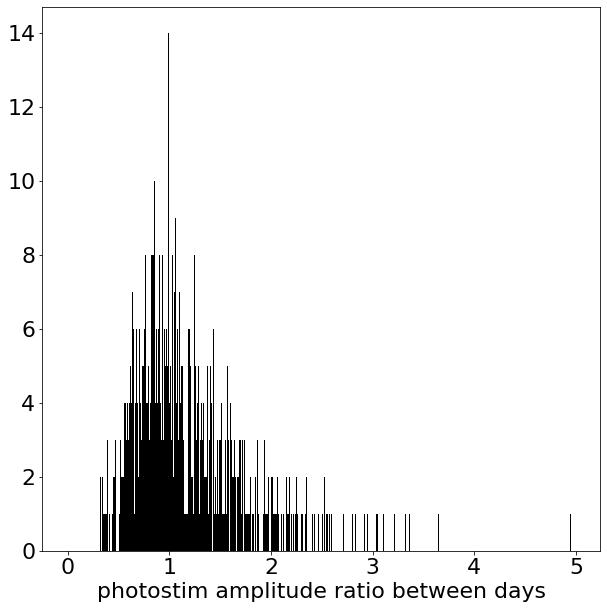

In [1137]:
fig = plt.figure(figsize= [10,10])
ax = fig.add_subplot(1,1,1)
ax.hist(amplitude_yesterday[photostimmed_yesterday&photostimmed_today]/amplitude_today[photostimmed_yesterday&photostimmed_today],np.arange(0,5,.01),color= 'black')
ax.set_xlabel('photostim amplitude ratio between days')


# plt.plot(photostim_overlap_list,photostimmed_cell_num_list,'ko')

In [93]:
sum(np.concatenate(ALL_photostim_overlaps)>.7)/len(np.concatenate(ALL_photostim_overlaps))

0.11

Text(0, 0.5, 'proportion of photostim groups')

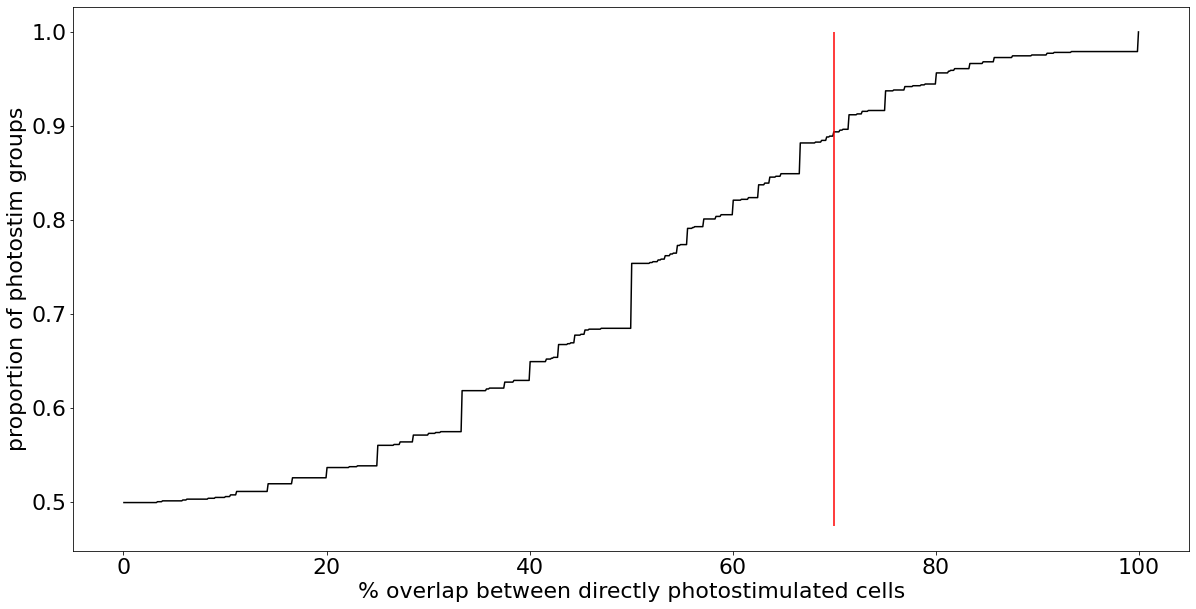

In [823]:
y,x = np.histogram(np.concatenate(ALL_photostim_overlaps),np.arange(0,1.001,.001))
x = np.nanmean([x[:-1],x[1:]],0)
fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(1,1,1)
ax.plot(x*100,np.cumsum(y)/sum(y),'k-')
ax.vlines(70,ax.get_ylim()[0],1,color = 'red')
ax.set_xlabel('% overlap between directly photostimulated cells')
ax.set_ylabel('proportion of photostim groups')
#ax.set_ylim([.7,1])

In [595]:
sum(np.concatenate(ALL_photostim_overlaps)>overlap_min_photostim)/len(np.concatenate(ALL_photostim_overlaps))

0.06909090909090909

asd


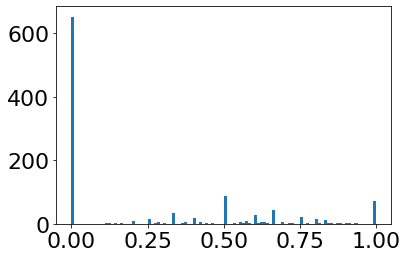

In [588]:
plt.hist(np.concatenate(ALL_photostim_overlaps),100)
print('asd')

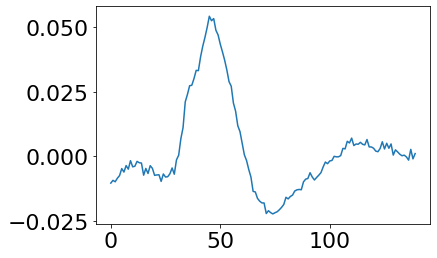

In [327]:
plt.plot(np.nanmean(F_rewardwise_averaged,1))

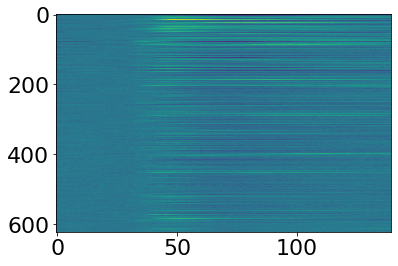

asd


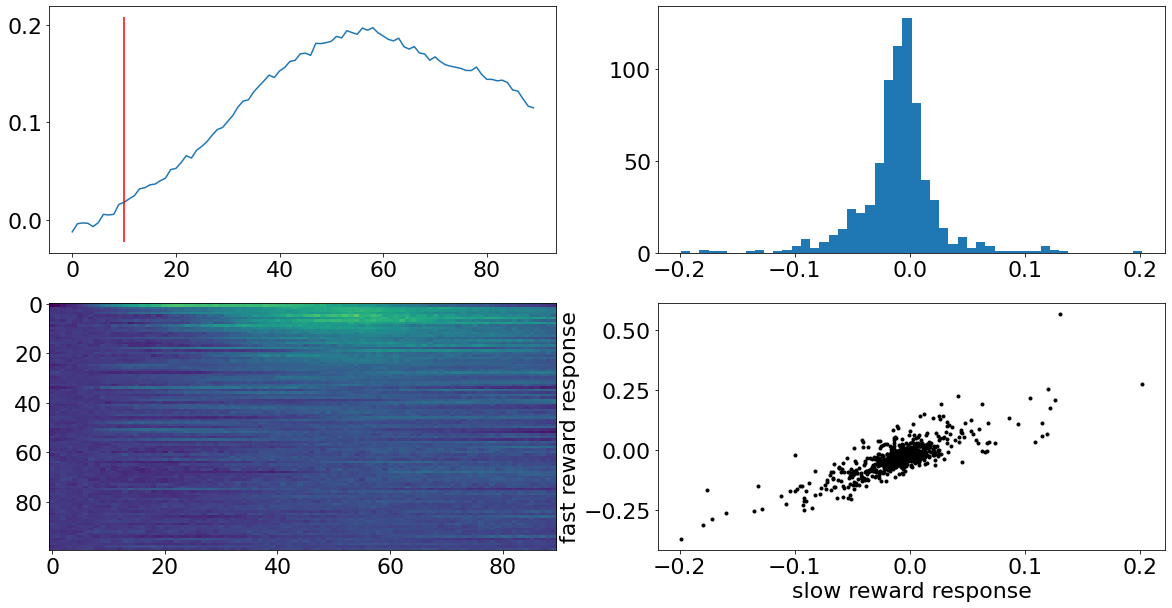

In [242]:
fig = plt.figure(figsize = [20,10])
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
session_i  =11
reward_step_forward  =80
reward_step_back = 10
baseline_len = 10
F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                           multi_session_dict['reward_original'][session_i],
                                                                           max_frames=None,
                                                                           frames_after=reward_step_forward, 
                                                                           frames_before=reward_step_back,
                                                                           include_next_trial=False)
F_rewardwise_averaged = np.nanmean(F_rewardwise,2)
F_rewardwise_averaged = F_rewardwise_averaged-np.nanmean(F_rewardwise_averaged[:baseline_len,:],0)[np.newaxis,:]

reward_amplitudes = np.asarray(np.nanmean(F_rewardwise_averaged[reward_step_back:,:],0))
reward_amplitudes_fast = np.asarray(np.nanmean(F_rewardwise_averaged[reward_step_back:reward_step_back+20,:],0))
#reward_amplitudes = np.asarray(np.nanmean(F_rewardwise_averaged[reward_step_back-5:reward_step_back+5,:],0))
reward_amplitudes = reward_amplitudes/np.linalg.norm(reward_amplitudes,2)
ax1.plot(np.nanmean(F_rewardwise_averaged[:,np.argsort(reward_amplitudes)[::-1][:100]],1))
ax2.hist(reward_amplitudes,50)
ax3.imshow(F_rewardwise_averaged[:,np.argsort(reward_amplitudes)[::-1][:100]].T,aspect = 'auto',interpolation = 'none')
ax1.vlines(reward_step_back,ax1.get_ylim()[0],ax1.get_ylim()[1],color = 'red')
ax4.plot(reward_amplitudes,reward_amplitudes_fast,'k.')
ax4.set_xlabel('slow reward response')
ax4.set_ylabel('fast reward response')
print('asd')

In [66]:
pre_active_cells_yesterday

array([False,  True,  True,  True,  True, False, False,  True, False,
       False, False, False,  True, False, False, False,  True,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False,  True, False,  True,  True, False,
       False, False, False, False, False, False])

In [42]:
# do more correlated cells become more connected over time really??

####p_increasing = .01 # post cells are the increasing ones with p<this number
distance_threshold = 30 # for direct photostim
distance_border = 0 # threshold +- this will be ignored..
distance_border_for_distribution = 0 # when calculating non-direct amplitude distribution, to make sure that no directly targeted cell is included

max_distance = 10000 # for indirect photostim
step_back = 40 #baseline before trial start (in frames)
step_forward = 100 #integration time after trial start (frames)
amplitude_min_std = 3 # for directly photostimmed cells
overlap_min_photostim = 0.7#.9 # minimum overlap in photostimmed cells

reward_step_back = 0
reward_step_forward = 80
####max_photostim_amplitude_ratio = 2 
all_pre_amplitudes = []
all_pre_errors = []
baseline_trace_name = 'F'
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise'] = [] #time x neuron x trial
multi_session_dict['F_trial_start'] = [] #time x neuron x trial

all_x_lists = []
all_x_yesterday_lists = []
all_y_lists = []
all_photostim_amplitude_yesterday = []
all_photostim_amplitude = []
all_y_base_lists = []
all_corr_with_cn_today = []
all_corr_with_prev_cn_yesterday = []
plot_titles_list =[]


all_pre_mean_amplitudes_list = []
all_pre_weighted_amplitudes_yesterday_list = []
all_pre_weighted_amplitudes_list = []
all_post_amplitudes_list = []
all_pre_mean_amplitudes_yesterday_list = []
all_post_amplitudes_yesterday_list = []
all_post_delta_amplitudes_list = []
all_photostim_overlap_list = []
ALL_photostim_overlaps = []
session_blacklist = []#['BCI37 - 062822 to 062922']
all_kayvon_x_lists = []
all_kayvon_y_lists = []

all_post_reward_amplitudes = []
for session_i,session in enumerate(multi_session_dict['session']):
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                           multi_session_dict['reward_original'][session_i],
                                                                           max_frames=None,
                                                                           frames_after=reward_step_forward, 
                                                                           frames_before=reward_step_back,
                                                                           include_next_trial=False)
    
#     F_after_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
#                                                                             multi_session_dict['reward_original'][session_i],
#                                                                             max_frames=None,
#                                                                             frames_after=60, 
#                                                                             frames_before=-40,
#                                                                             include_next_trial=False)
    
#     F_trial_start = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
#                                                                             trial_start_trace,
#                                                                             max_frames=None,
#                                                                             frames_after=20, 
#                                                                             frames_before=0,
#                                                                            include_next_trial=False)
    
    multi_session_dict['F_trialwise'].append(F_trialwise)
    multi_session_dict['F_rewardwise'].append(F_rewardwise)
    #multi_session_dict['F_trial_start'].append(F_trial_start)
   # asd
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session
            same_fov_sessions = []
            for session_i__ in np.arange(len(multi_session_dict['session'])):
                if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i__].shape[0] and multi_session_dict['mouse'][session_i] == multi_session_dict['mouse'][session_i__]: #there is a previous session
                    same_fov_sessions.append(session_i__)
                    
            session_title = '{} - {} to {}'.format(multi_session_dict['mouse'][session_i],multi_session_dict['session'][session_i-1],multi_session_dict['session'][session_i])
            if session_title in session_blacklist:
                continue
            
            change_in_correlations = multi_session_dict['pairwise_correlations_matrix'][session_i]# -  multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            change_in_correlations = np.nanmean([change_in_correlations,change_in_correlations.T],0).squeeze()
            change_in_correlations[np.isnan(change_in_correlations)] = 0
            try:
                change_in_correlations_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]# -  multi_session_dict['pairwise_correlations_matrix'][session_i-2]
                change_in_correlations_yesterday = np.nanmean([change_in_correlations_yesterday,change_in_correlations_yesterday.T],0).squeeze()
                change_in_correlations_yesterday[np.isnan(change_in_correlations_yesterday)] = 0
            except:
                change_in_correlations_yesterday = change_in_correlations*0

            
            # ## that is just correlation, not change - 
            # change_in_correlations = multi_session_dict['pairwise_correlations_matrix'][session_i]
            # change_in_correlations = np.nanmean([change_in_correlations,change_in_correlations.T],0).squeeze()
            # change_in_correlations[np.isnan(change_in_correlations)] = 0
            # try:
            #     change_in_correlations_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            #     change_in_correlations_yesterday = np.nanmean([change_in_correlations_yesterday,change_in_correlations_yesterday.T],0).squeeze()
            #     change_in_correlations_yesterday[np.isnan(change_in_correlations_yesterday)] = 0
            # except:
            #     change_in_correlations_yesterday = change_in_correlations*0
            
            F_rewardwise = multi_session_dict['F_rewardwise'][session_i]
            F_rewardwise_averaged = np.nanmean(F_rewardwise,2)
            F_rewardwise_averaged = F_rewardwise_averaged-np.nanmean(F_rewardwise_averaged[:reward_step_back,:],0)[np.newaxis,:]
            reward_amplitudes = np.asarray(np.nanmean(F_rewardwise_averaged[reward_step_back:,:],0))
            #reward_amplitudes = reward_amplitudes/np.linalg.norm(reward_amplitudes,2)
            
          
            
            
            
            if len(multi_session_dict['photostim_amplitude'][session_i])>10 and len(multi_session_dict['photostim_amplitude'][session_i-1])>10:
                x_list = []
                x_list_yesterday = []
                y_list = []
                photostim_amplitude_yesterday = []
                
                
                photostim_amplitude = []
                y_baseline = []
                corr_with_cn_today = []
                corr_with_prev_cn_yesterday = []
                pre_mean_amplitudes_list = []
                post_amplitudes_list = []
                pre_mean_amplitudes_yesterday_list = []
                pre_weighted_amplitudes_list = []
                pre_weighted_amplitudes_yesterday_list = []
                post_amplitudes_yesterday_list = []
                post_delta_amplitudes_list = []
                photostim_overlap_list = []
                kayvon_x_list = []
                kayvon_y_list = []
                post_reward_amplitudes = []
                amplitude_base = np.nanmean([multi_session_dict['photostim_amplitude'][session_i],multi_session_dict['photostim_amplitude'][session_i-1]],0)
#                 amplitude_base_list = []
#                 for session_i__ in same_fov_sessions:
#                     if len(multi_session_dict['photostim_amplitude'][session_i__])>10:
#                         amplitude_base_list.append(multi_session_dict['photostim_amplitude'][session_i__])
#                     # if session_i__ == session_i:
#                     #     break
#                 amplitude_base = np.nanmean(amplitude_base_list,0)
                
                amplitude_difference = multi_session_dict['photostim_amplitude'][session_i]-multi_session_dict['photostim_amplitude'][session_i-1]
                
                
                amplitude = multi_session_dict['photostim_amplitude'][session_i]
                amplitude_yesterday = multi_session_dict['photostim_amplitude'][session_i-1]
                
                # find threshold for directly stimulated cells
                threshold_list = []
                threshold_list_yesterday = []
                for pre_cell_now in np.arange(len(np.unique(np.asarray(multi_session_dict['photostim_cell'][session_i])))):
                    all_amplitudes =  multi_session_dict['photostim_amplitude'][session_i][(np.asarray(multi_session_dict['photostim_cell'][session_i])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i]>=distance_threshold+distance_border_for_distribution)]
                    photostim_amplitudes =  multi_session_dict['photostim_amplitude'][session_i][(np.asarray(multi_session_dict['photostim_cell'][session_i])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i]<=distance_threshold-distance_border_for_distribution)]
                    threshold = np.nanmedian(all_amplitudes)+np.nanstd(all_amplitudes)*amplitude_min_std
                    threshold_list.append(threshold)

                    all_amplitudes_yesterday =  multi_session_dict['photostim_amplitude'][session_i-1][(np.asarray(multi_session_dict['photostim_cell'][session_i-1])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i-1]>=distance_threshold+distance_border_for_distribution)]
                    threshold = np.nanmedian(all_amplitudes_yesterday)+np.nanstd(all_amplitudes_yesterday)*amplitude_min_std
                    threshold_list_yesterday.append(threshold)
                threshold_list = np.asarray(threshold_list)
                threshold_list_yesterday = np.asarray(threshold_list_yesterday)
                
                photostim_overlap_list = []
                for photostim_group in np.unique(multi_session_dict['photostim_group'][session_i]):
                    pre_cells = np.asarray(multi_session_dict['photostim_cell'][session_i][(multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)],int)-1
                    pre_cell_indices = (multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)
                    pre_amplitudes = multi_session_dict['photostim_amplitude'][session_i][pre_cell_indices] # on second day
                    pre_cells_yesterday = np.asarray(multi_session_dict['photostim_cell'][session_i-1][(multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)],int)-1
                    pre_cell_indices_yesterday = (multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)
                    pre_amplitudes_yesterday = multi_session_dict['photostim_amplitude'][session_i-1][pre_cell_indices_yesterday] # on second day
                    pre_active_cells = pre_amplitudes>threshold_list[pre_cells]

                    pre_active_cells_yesterday = pre_amplitudes_yesterday>threshold_list_yesterday[pre_cells_yesterday]
                    
                    photostimmed_in_both = 0
                    photostimmed_in_one = 0
                    pre_cells_yesterday_ = pre_cells_yesterday.copy()
                    pre_active_cells_yesterday_ = pre_active_cells_yesterday.copy()
                    for pre_cell_now,isactive in zip(pre_cells,pre_active_cells):
                        if pre_cell_now in pre_cells_yesterday_:
                            pre_idx_yesterday = np.where(pre_cell_now == pre_cells_yesterday_)[0][0]
                            isactive_yesterday = pre_active_cells_yesterday_[pre_idx_yesterday]
                            if isactive and isactive_yesterday:
                                photostimmed_in_both += 1
                            elif isactive or isactive_yesterday:
                                photostimmed_in_one+=1
                            needed_indices__ = np.ones(len(pre_cells_yesterday_))==1
                            needed_indices__[pre_idx_yesterday] = False
                            pre_cells_yesterday_ = pre_cells_yesterday_[needed_indices__]
                            pre_active_cells_yesterday_ = pre_active_cells_yesterday_[needed_indices__]
                        else:
                            if isactive:
                                photostimmed_in_one+=1

                    for pre_cell_now,isactive in zip(pre_cells_yesterday_,pre_active_cells_yesterday_):
                        if isactive:
                            photostimmed_in_one+=1
                    try:
                        photostim_overlap = photostimmed_in_both/(photostimmed_in_one+photostimmed_in_both)     
                    except:
                        photostim_overlap = 0
                    photostim_overlap_list.append(photostim_overlap)
                photostim_overlap_list  = np.asarray(photostim_overlap_list)
                ALL_photostim_overlaps.append(photostim_overlap_list)
                
                
                for photostim_i in np.arange(len(multi_session_dict['photostim_cell'][session_i])):
                    if multi_session_dict['photostim_distance'][session_i][photostim_i]>=distance_threshold+distance_border and  multi_session_dict['photostim_distance'][session_i][photostim_i]<=max_distance: # only postsynaptic cells
                        # if amplitude_base[photostim_i]<0:#(np.abs(amplitude_base[photostim_i])<.2 and np.abs(amplitude[photostim_i])<.2):# or 
                        #     continue
                        
                        post_cell = int(multi_session_dict['photostim_cell'][session_i][photostim_i])-1
                        post_cell_yesterday = int(multi_session_dict['photostim_cell'][session_i-1][photostim_i])-1
                        if post_cell != post_cell_yesterday:
                            asdasd # this is just a data check, should never arrive here..
                        # if multi_session_dict['p_increase'][session_i][post_cell]>.05:
                        #     continue
                        # if not multi_session_dict['cn'][session_i] ==post_cell:
                        #     continue
                        
                        photostim_group = multi_session_dict['photostim_group'][session_i][photostim_i]
                        pre_cells = np.asarray(multi_session_dict['photostim_cell'][session_i][(multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)],int)-1
                        
                        pre_cell_indices = (multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)
                        pre_amplitudes = multi_session_dict['photostim_amplitude'][session_i][pre_cell_indices] # on second day
                        #pre_amplitude_errors = multi_session_dict['photostim_amplitude_error'][session_i][pre_cell_indices] # on second day
                        
                        pre_cells_yesterday = np.asarray(multi_session_dict['photostim_cell'][session_i-1][(multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)],int)-1
                        pre_cell_indices_yesterday = (multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)
                        pre_amplitudes_yesterday = multi_session_dict['photostim_amplitude'][session_i-1][pre_cell_indices_yesterday] # on second day
                        #pre_amplitude_errors_yesterday = multi_session_dict['photostim_amplitude_error'][session_i-1][pre_cell_indices] # on second day
                        
                        
#                         if not (((multi_session_dict['cn'][session_i] in pre_cells) and (multi_session_dict['cn'][session_i] in pre_cells_yesterday))or multi_session_dict['cn'][session_i] ==post_cell):
#                             continue # cn is not pre
                        
                        
                        #threshold_list = np.asarray(threshold_list) & np.asarray(threshold_list_yesterday)
                        #mean_pre_amplitudes = np.nanmin([pre_amplitudes,pre_amplitudes_yesterday],0)>np.asarray(threshold_list)# hard coded threshold because photostim amplitude SEM variable seems wrong
                        pre_active_cells = pre_amplitudes>threshold_list[pre_cells]
                        
                        pre_active_cells_yesterday = pre_amplitudes_yesterday>threshold_list_yesterday[pre_cells_yesterday]
                        
                        photostim_overlap = photostim_overlap_list[int(photostim_group-1)]
                        
                        if photostim_overlap < overlap_min_photostim: # skip if presynaptic activation was different
                            continue
                            
                        #all_pre_amplitudes.append(pre_amplitudes_yesterday)
                        #all_pre_errors.append(pre_amplitude_errors_yesterday)
                        #mean_pre_amplitudes[mean_pre_amplitudes<0] = 0
                        
                        
                        x = np.nanmean(change_in_correlations[post_cell,pre_cells]*pre_active_cells)#pre_active_cells #pre_amplitudes
                        # below: positive amplitude is increasing cell, negative amplitude is non-increasing cell, just like for Kayvon
                        #x = np.sum((multi_session_dict['p_increase'][session_i][pre_cells]<0.05)*mean_pre_amplitudes) - np.sum((multi_session_dict['p_increase'][session_i][pre_cells]>0.1)*mean_pre_amplitudes)
                        
                        x_list.append(x)
                        x = np.nanmean(change_in_correlations_yesterday[post_cell,pre_cells_yesterday]*pre_active_cells_yesterday)#pre_active_cells_yesterday #pre_amplitudes_yesterday
                        x_list_yesterday.append(x)

                        y_list.append(amplitude_difference[photostim_i])##
                        
                        
                        #kayvon_x = np.nanmean(np.nanmean(amplitude[pre_cells[pre_active_cells]]*multi_session_dict['delta_amplitude'][session_i][pre_cells[pre_active_cells]]) + np.nanmean(amplitude_yesterday[pre_cells_yesterday[pre_active_cells_yesterday]]*multi_session_dict['delta_amplitude'][session_i][pre_cells_yesterday[pre_active_cells_yesterday]])  )
                        
#                         pre_kayvon_delta_amplitudes = np.asarray(multi_session_dict['p_increase'][session_i][pre_cells[pre_active_cells]])
#                         pre_kayvon_delta_amplitudes[pre_kayvon_delta_amplitudes<.05] = 1
#                         pre_kayvon_delta_amplitudes[(pre_kayvon_delta_amplitudes>0.05) & (pre_kayvon_delta_amplitudes<0.2)] = 0
#                         pre_kayvon_delta_amplitudes[pre_kayvon_delta_amplitudes>0.2] = -1
                        
                        
#                         pre_kayvon_delta_amplitudes_yesterday = np.asarray(multi_session_dict['p_increase'][session_i][pre_cells_yesterday[pre_active_cells_yesterday]])
#                         pre_kayvon_delta_amplitudes_yesterday[pre_kayvon_delta_amplitudes_yesterday<.05] = 1
#                         pre_kayvon_delta_amplitudes_yesterday[(pre_kayvon_delta_amplitudes_yesterday>0.05) & (pre_kayvon_delta_amplitudes_yesterday<0.2)] = 0
#                         pre_kayvon_delta_amplitudes_yesterday[pre_kayvon_delta_amplitudes_yesterday>0.2] = -1
                        delta_amplitudes_norm = multi_session_dict['delta_amplitude'][session_i]/np.linalg.norm(multi_session_dict['delta_amplitude'][session_i],2)
                        pre_kayvon_delta_amplitudes = np.asarray(delta_amplitudes_norm[pre_cells[pre_active_cells]])
                        pre_kayvon_delta_amplitudes_yesterday = np.asarray(delta_amplitudes_norm[pre_cells_yesterday[pre_active_cells_yesterday]])

                        
                        kayvon_x = np.nansum([np.nansum(amplitude[np.where(pre_cell_indices)[0][pre_active_cells]]*pre_kayvon_delta_amplitudes) , 
                                              np.nansum(amplitude_yesterday[np.where(pre_cell_indices_yesterday)[0][pre_active_cells_yesterday]]*pre_kayvon_delta_amplitudes_yesterday) ] )
                        
                        
                        kayvon_x_list.append(kayvon_x)
                        kayvon_y = (amplitude[photostim_i]-amplitude_yesterday[photostim_i])#*delta_amplitudes_norm[post_cell]
                        kayvon_y_list.append(kayvon_y)
                        
                        
                        y_baseline.append(amplitude_base[photostim_i])
                        corr_with_cn_today_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i][multi_session_dict['cn'][session_i],post_cell],
                                                        multi_session_dict['pairwise_correlations_matrix'][session_i][post_cell,multi_session_dict['cn'][session_i]]])
                        corr_with_cn_today.append(corr_with_cn_today_)
                        corr_with_prev_cn_yesterday_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i-1][multi_session_dict['cn'][session_i-1],post_cell],
                                                                multi_session_dict['pairwise_correlations_matrix'][session_i-1][post_cell,multi_session_dict['cn'][session_i-1]]])
                        corr_with_prev_cn_yesterday.append(corr_with_prev_cn_yesterday_)
                        
                        
                        photostim_amplitude_yesterday.append(amplitude_yesterday[photostim_i])
                        photostim_amplitude.append(amplitude[photostim_i])
                        
                        
                        pre_mean_amplitudes_list.append(np.nanmean(multi_session_dict['amplitude'][session_i][pre_cells]*pre_active_cells))
                        post_amplitudes_list.append(multi_session_dict['amplitude'][session_i][post_cell])
                        pre_mean_amplitudes_yesterday_list.append(np.nanmean(multi_session_dict['previous_amplitude'][session_i][pre_cells_yesterday]*pre_active_cells_yesterday))
                        
                        
                        amplitudes_norm_today = multi_session_dict['amplitude'][session_i]/np.linalg.norm(multi_session_dict['amplitude'][session_i],2)
                        pre_kayvon_amplitudes = np.asarray(amplitudes_norm_today[pre_cells[pre_active_cells]])
                        pre_kayvon_amplitudes_yesterday = np.asarray(amplitudes_norm_today[pre_cells_yesterday[pre_active_cells_yesterday]])
                        
                        
                        weighted_pre_amplitude = np.nansum([np.nansum(amplitude[np.where(pre_cell_indices)[0][pre_active_cells]]*pre_kayvon_amplitudes) , 
                                                            np.nansum(amplitude_yesterday[np.where(pre_cell_indices_yesterday)[0][pre_active_cells_yesterday]]*pre_kayvon_amplitudes_yesterday) ] )
                            
                        pre_weighted_amplitudes_list.append(weighted_pre_amplitude)
                        
                        
                        
                        amplitudes_norm_yesterday = multi_session_dict['previous_amplitude'][session_i]/np.linalg.norm(multi_session_dict['previous_amplitude'][session_i],2)
                        pre_kayvon_amplitudes = np.asarray(amplitudes_norm_yesterday[pre_cells[pre_active_cells]])
                        pre_kayvon_amplitudes_yesterday = np.asarray(amplitudes_norm_yesterday[pre_cells_yesterday[pre_active_cells_yesterday]])
                        
                        
                        weighted_pre_amplitude = np.nansum([np.nansum(amplitude[np.where(pre_cell_indices)[0][pre_active_cells]]*pre_kayvon_amplitudes) , 
                                                            np.nansum(amplitude_yesterday[np.where(pre_cell_indices_yesterday)[0][pre_active_cells_yesterday]]*pre_kayvon_amplitudes_yesterday) ] )
                        pre_weighted_amplitudes_yesterday_list.append(weighted_pre_amplitude)
                        
                        
                        
                        
                        post_amplitudes_yesterday_list.append(multi_session_dict['previous_amplitude'][session_i][post_cell])

                        post_delta_amplitudes_list.append(delta_amplitudes_norm[post_cell])
                        
                        post_reward_amplitudes.append(reward_amplitudes[post_cell])
                
                x_list = np.asarray(x_list)
                x_list_yesterday = np.asarray(x_list_yesterday)
                y_list = np.asarray(y_list)
                corr_with_prev_cn_yesterday = np.asarray(corr_with_prev_cn_yesterday)
                corr_with_cn_today = np.asarray(corr_with_cn_today)
                pre_mean_amplitudes_list =np.asarray(pre_mean_amplitudes_list)
                pre_weighted_amplitudes_list = np.asarray(pre_weighted_amplitudes_list)
                pre_weighted_amplitudes_yesterday_list = np.asarray(pre_weighted_amplitudes_yesterday_list)
                post_amplitudes_list = np.asarray(post_amplitudes_list)
                pre_mean_amplitudes_yesterday_list = np.asarray(pre_mean_amplitudes_yesterday_list)
                post_amplitudes_yesterday_list = np.asarray(post_amplitudes_yesterday_list)
                post_delta_amplitudes_list = np.asarray(post_delta_amplitudes_list)
                post_reward_amplitudes  =np.asarray(post_reward_amplitudes)
                
                
                
                photostim_amplitude = np.asarray(photostim_amplitude)
                photostim_amplitude_yesterday = np.asarray(photostim_amplitude_yesterday)
                
                kayvon_x_list = np.asarray(kayvon_x_list)
                kayvon_y_list = np.asarray(kayvon_y_list)
                
                
                
                
                all_pre_mean_amplitudes_list.append(pre_mean_amplitudes_list)
                all_pre_weighted_amplitudes_list.append(pre_weighted_amplitudes_list)
                all_pre_weighted_amplitudes_yesterday_list.append(pre_weighted_amplitudes_yesterday_list)
                all_post_amplitudes_list.append(post_amplitudes_list)
                all_pre_mean_amplitudes_yesterday_list.append(pre_mean_amplitudes_yesterday_list)
                all_post_amplitudes_yesterday_list.append(post_amplitudes_yesterday_list)
                all_post_delta_amplitudes_list.append(post_delta_amplitudes_list)
                
                
                all_x_lists.append(x_list)
                all_x_yesterday_lists.append(x_list_yesterday)
                all_y_lists.append(y_list)
                all_y_base_lists.append(y_baseline)
                plot_titles_list.append(session_title)
                
                all_corr_with_cn_today.append(corr_with_cn_today)
                all_corr_with_prev_cn_yesterday.append(corr_with_prev_cn_yesterday)
                
                all_photostim_overlap_list.append(photostim_overlap_list)
                
                all_kayvon_x_lists.append(kayvon_x_list)
                all_kayvon_y_lists.append(kayvon_y_list)
                
                all_photostim_amplitude_yesterday.append(photostim_amplitude_yesterday)
                all_photostim_amplitude.append(photostim_amplitude)
                
                all_post_reward_amplitudes.append(post_reward_amplitudes)

/tmp/ipykernel_2902/1560825568.py:96: RuntimeWarning: Mean of empty slice
  change_in_correlations = np.nanmean([change_in_correlations,change_in_correlations.T],0).squeeze()
/tmp/ipykernel_2902/1560825568.py:100: RuntimeWarning: Mean of empty slice
  change_in_correlations_yesterday = np.nanmean([change_in_correlations_yesterday,change_in_correlations_yesterday.T],0).squeeze()
/tmp/ipykernel_2902/1560825568.py:119: RuntimeWarning: Mean of empty slice
  F_rewardwise_averaged = F_rewardwise_averaged-np.nanmean(F_rewardwise_averaged[:reward_step_back,:],0)[np.newaxis,:]
/tmp/ipykernel_2902/1560825568.py:120: RuntimeWarning: Mean of empty slice
  reward_amplitudes = np.asarray(np.nanmean(F_rewardwise_averaged[reward_step_back:,:],0))
/tmp/ipykernel_2902/1560825568.py:308: RuntimeWarning: All-NaN axis encountered
  corr_with_cn_today_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i][multi_session_dict['cn'][session_i],post_cell],
/tmp/ipykernel_2902/1560825568.py:

In [43]:
weighted_pre_amplitude

0.003912168262257116

In [44]:
import matplotlib
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

Text(0.5, 1.0, 'all sessions')

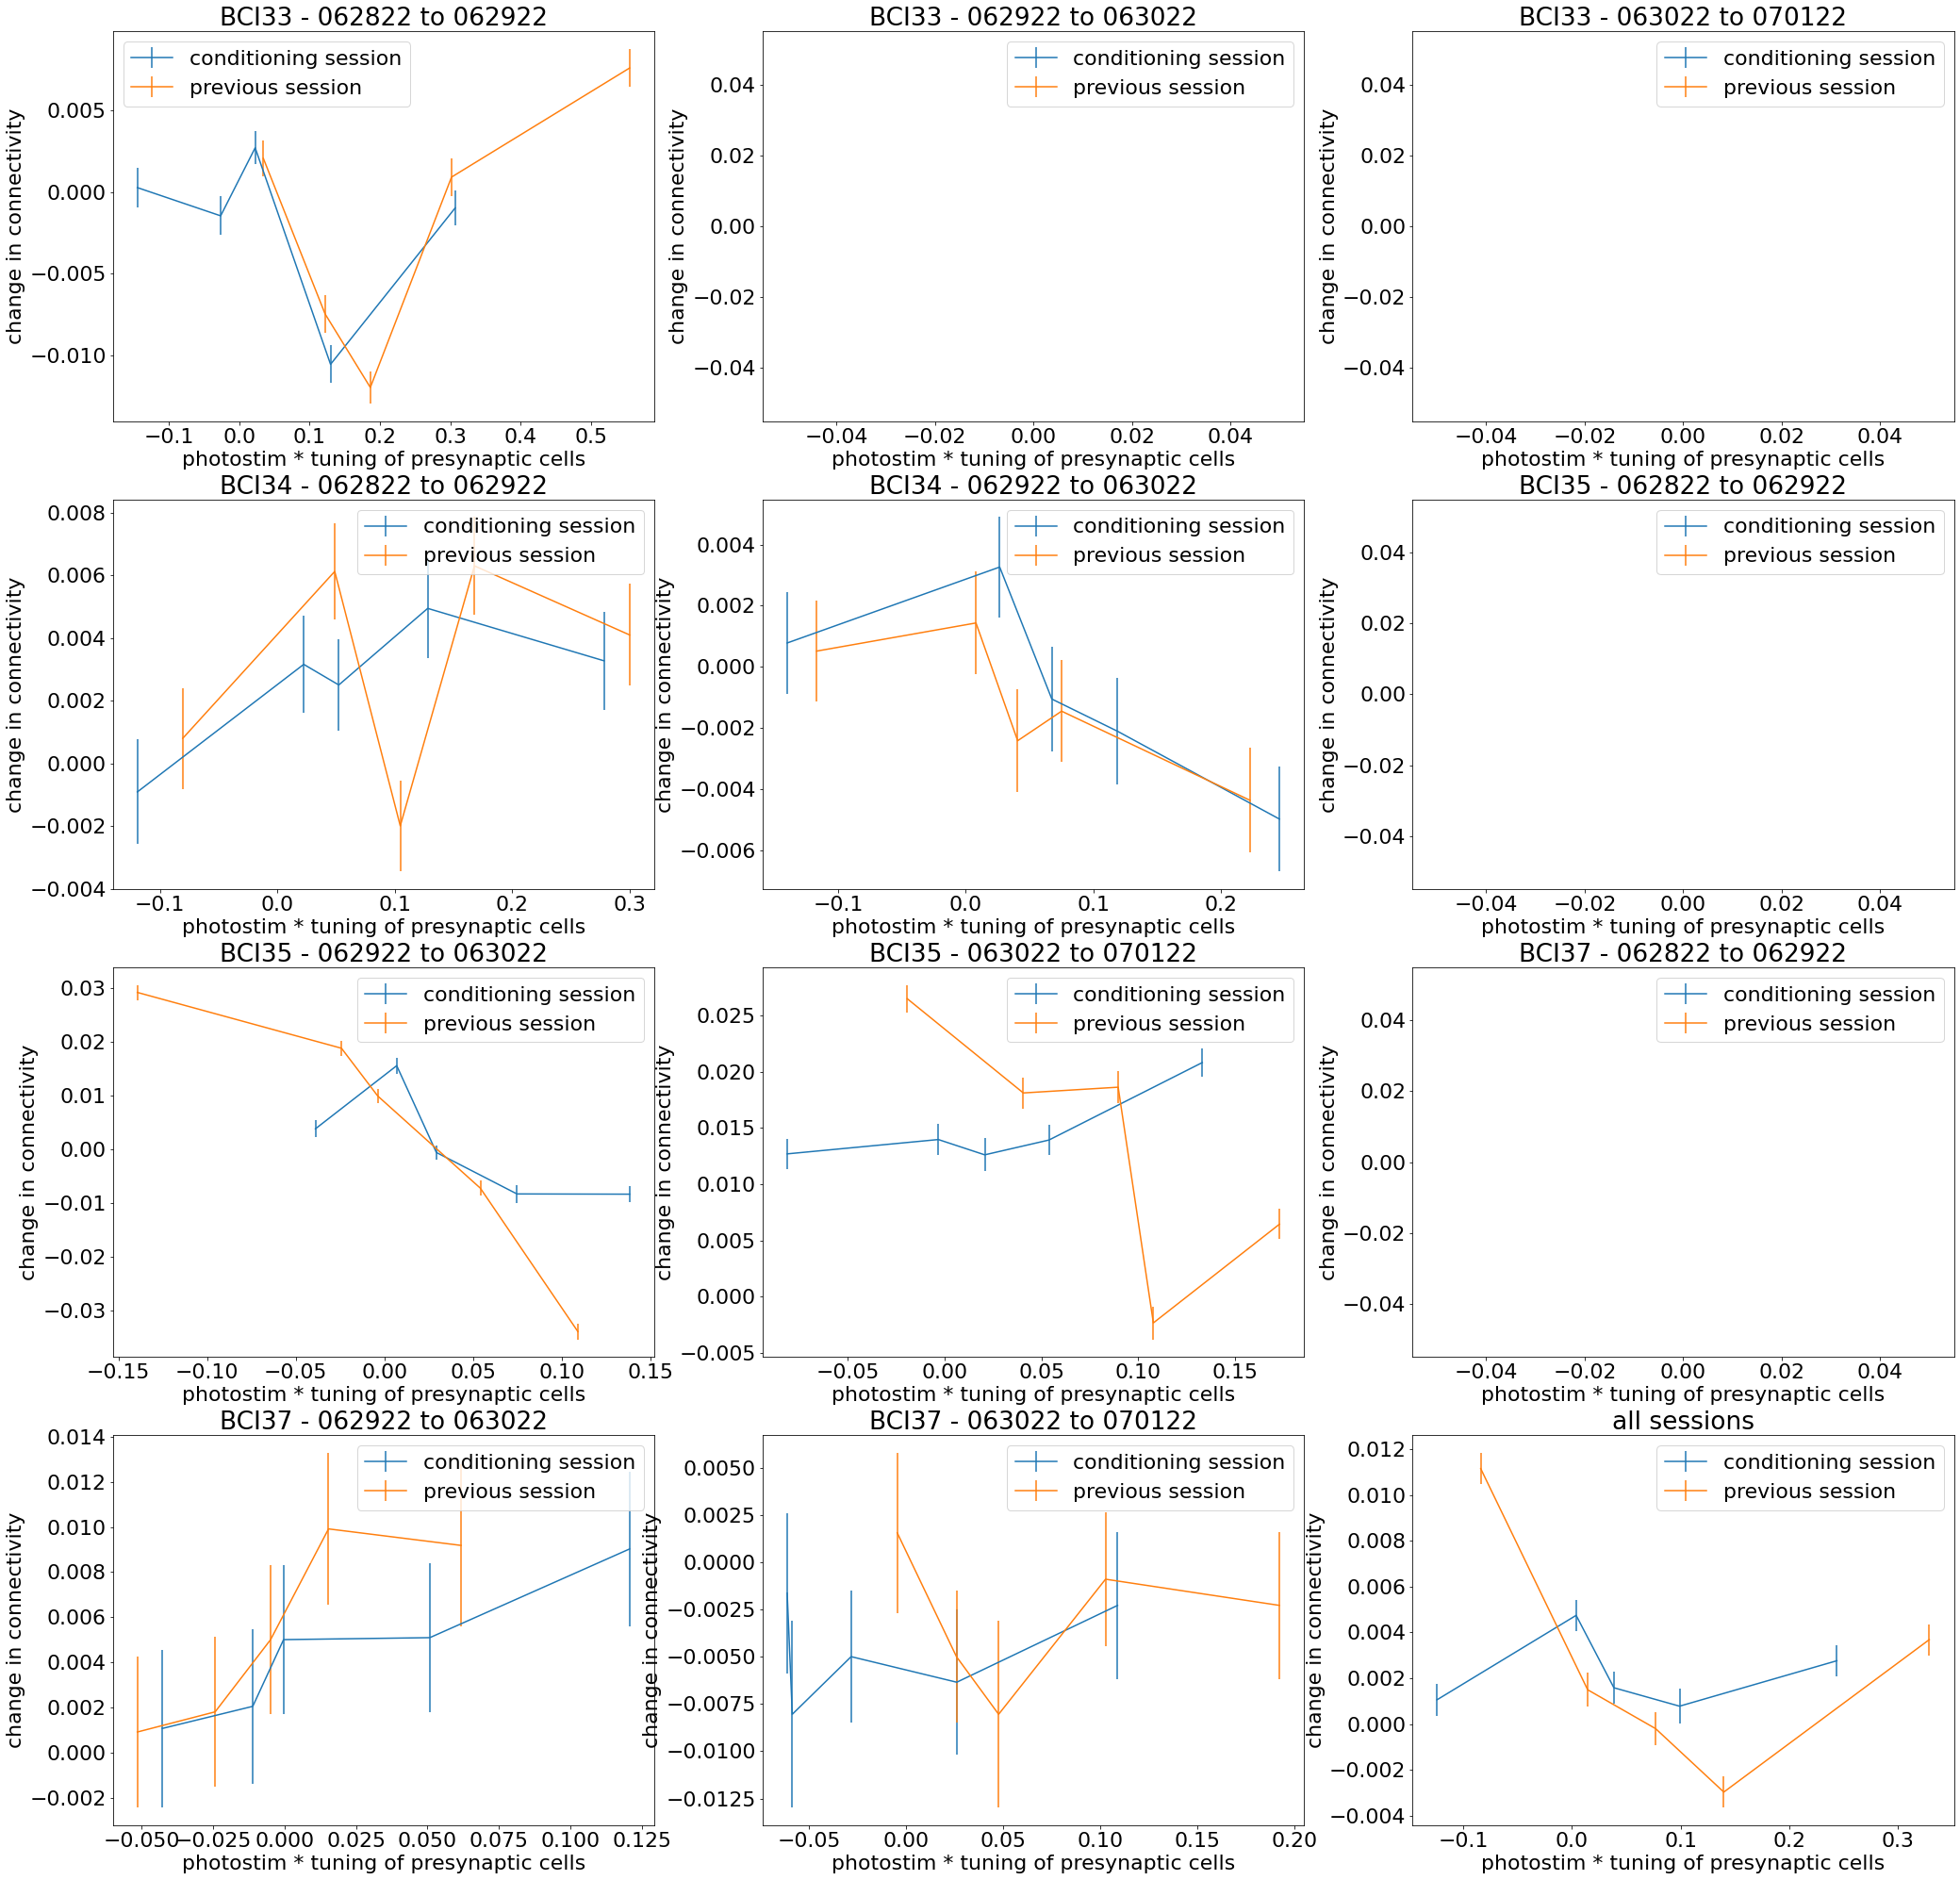

In [45]:
# PLOT ALA KAYVON
bin_num = 5
xlabel = 'photostim * tuning of presynaptic cells'#'direct photostim in cells coactivate during reward'
fig = plt.figure(figsize = [35,35])
#ax = fig.add_subplot(1,1,1)


for i,(x_list,y_list_,x_list_yesterday,title) in enumerate(zip(all_pre_weighted_amplitudes_list,all_kayvon_y_lists,all_pre_weighted_amplitudes_yesterday_list,plot_titles_list)):#all_x_lists, all_y_lists,all_x_yesterday_lists
    
    # if i == 0:
    #     ax = fig.add_subplot(4,3,i+1)
    # else:
    #     ax = fig.add_subplot(4,3,i+1,sharex = ax,sharey = ax)
    ax = fig.add_subplot(4,3,i+1)
    try:
        todel = x_list==0
        x_list = x_list[todel == False]
        y_list = y_list_[todel == False]

        bin_x = []
        bin_y = []
        bin_y_error = []
        if len(x_list)>0:


            x_sorted = np.sort(x_list)
            x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]


            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list>=x_s)&(x_list<=x_e)
                n = sum(needed_indices)
                bin_x.append(np.nanmean(x_list[needed_indices]))
                bin_y.append(np.nanmean(y_list[needed_indices]))
                bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
        # plt.plot(x_list,y_list,'k.',alpha = .1)


        todel = x_list_yesterday==0
        x_list_yesterday = x_list_yesterday[todel == False]
        y_list = y_list_[todel == False]

        bin_x_yesterday = []
        bin_y_yesterday = []
        bin_y_error_yesterday = []
        if len(x_list_yesterday)>0:
            x_sorted = np.sort(x_list_yesterday)
            x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]

            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
                n = sum(needed_indices)
                bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
                bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
                bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


        # plt.xlim(np.percentile(x_list,[1,99]))

        ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
        ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('change in connectivity')
        ax.set_title(title)
        ax.legend()
    except:
        pass
#fig = plt.figure()
ax = fig.add_subplot(4,3,i+2)#,sharex = ax,sharey = ax)
x_list = np.concatenate(all_pre_weighted_amplitudes_list)#all_x_lists
y_list_= np.concatenate(all_kayvon_y_lists)#all_y_lists
x_list_yesterday= np.concatenate(all_pre_weighted_amplitudes_yesterday_list)#np.concatenate(all_x_yesterday_lists)
title = 'all sessions'

todel = x_list==0
x_list = x_list[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list)
x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

bin_x = []
bin_y = []
bin_y_error = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list>=x_s)&(x_list<=x_e)
    n = sum(needed_indices)
    bin_x.append(np.nanmean(x_list[needed_indices]))
    bin_y.append(np.nanmean(y_list[needed_indices]))
    bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
# plt.plot(x_list,y_list,'k.',alpha = .1)


todel = x_list_yesterday==0
x_list_yesterday = x_list_yesterday[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list_yesterday)
x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]
bin_x_yesterday = []
bin_y_yesterday = []
bin_y_error_yesterday = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
    n = sum(needed_indices)
    bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
    bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
    bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


# plt.xlim(np.percentile(x_list,[1,99]))
ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel('change in connectivity')
ax.set_title(title)

Text(0.5, 1.0, 'all sessions')

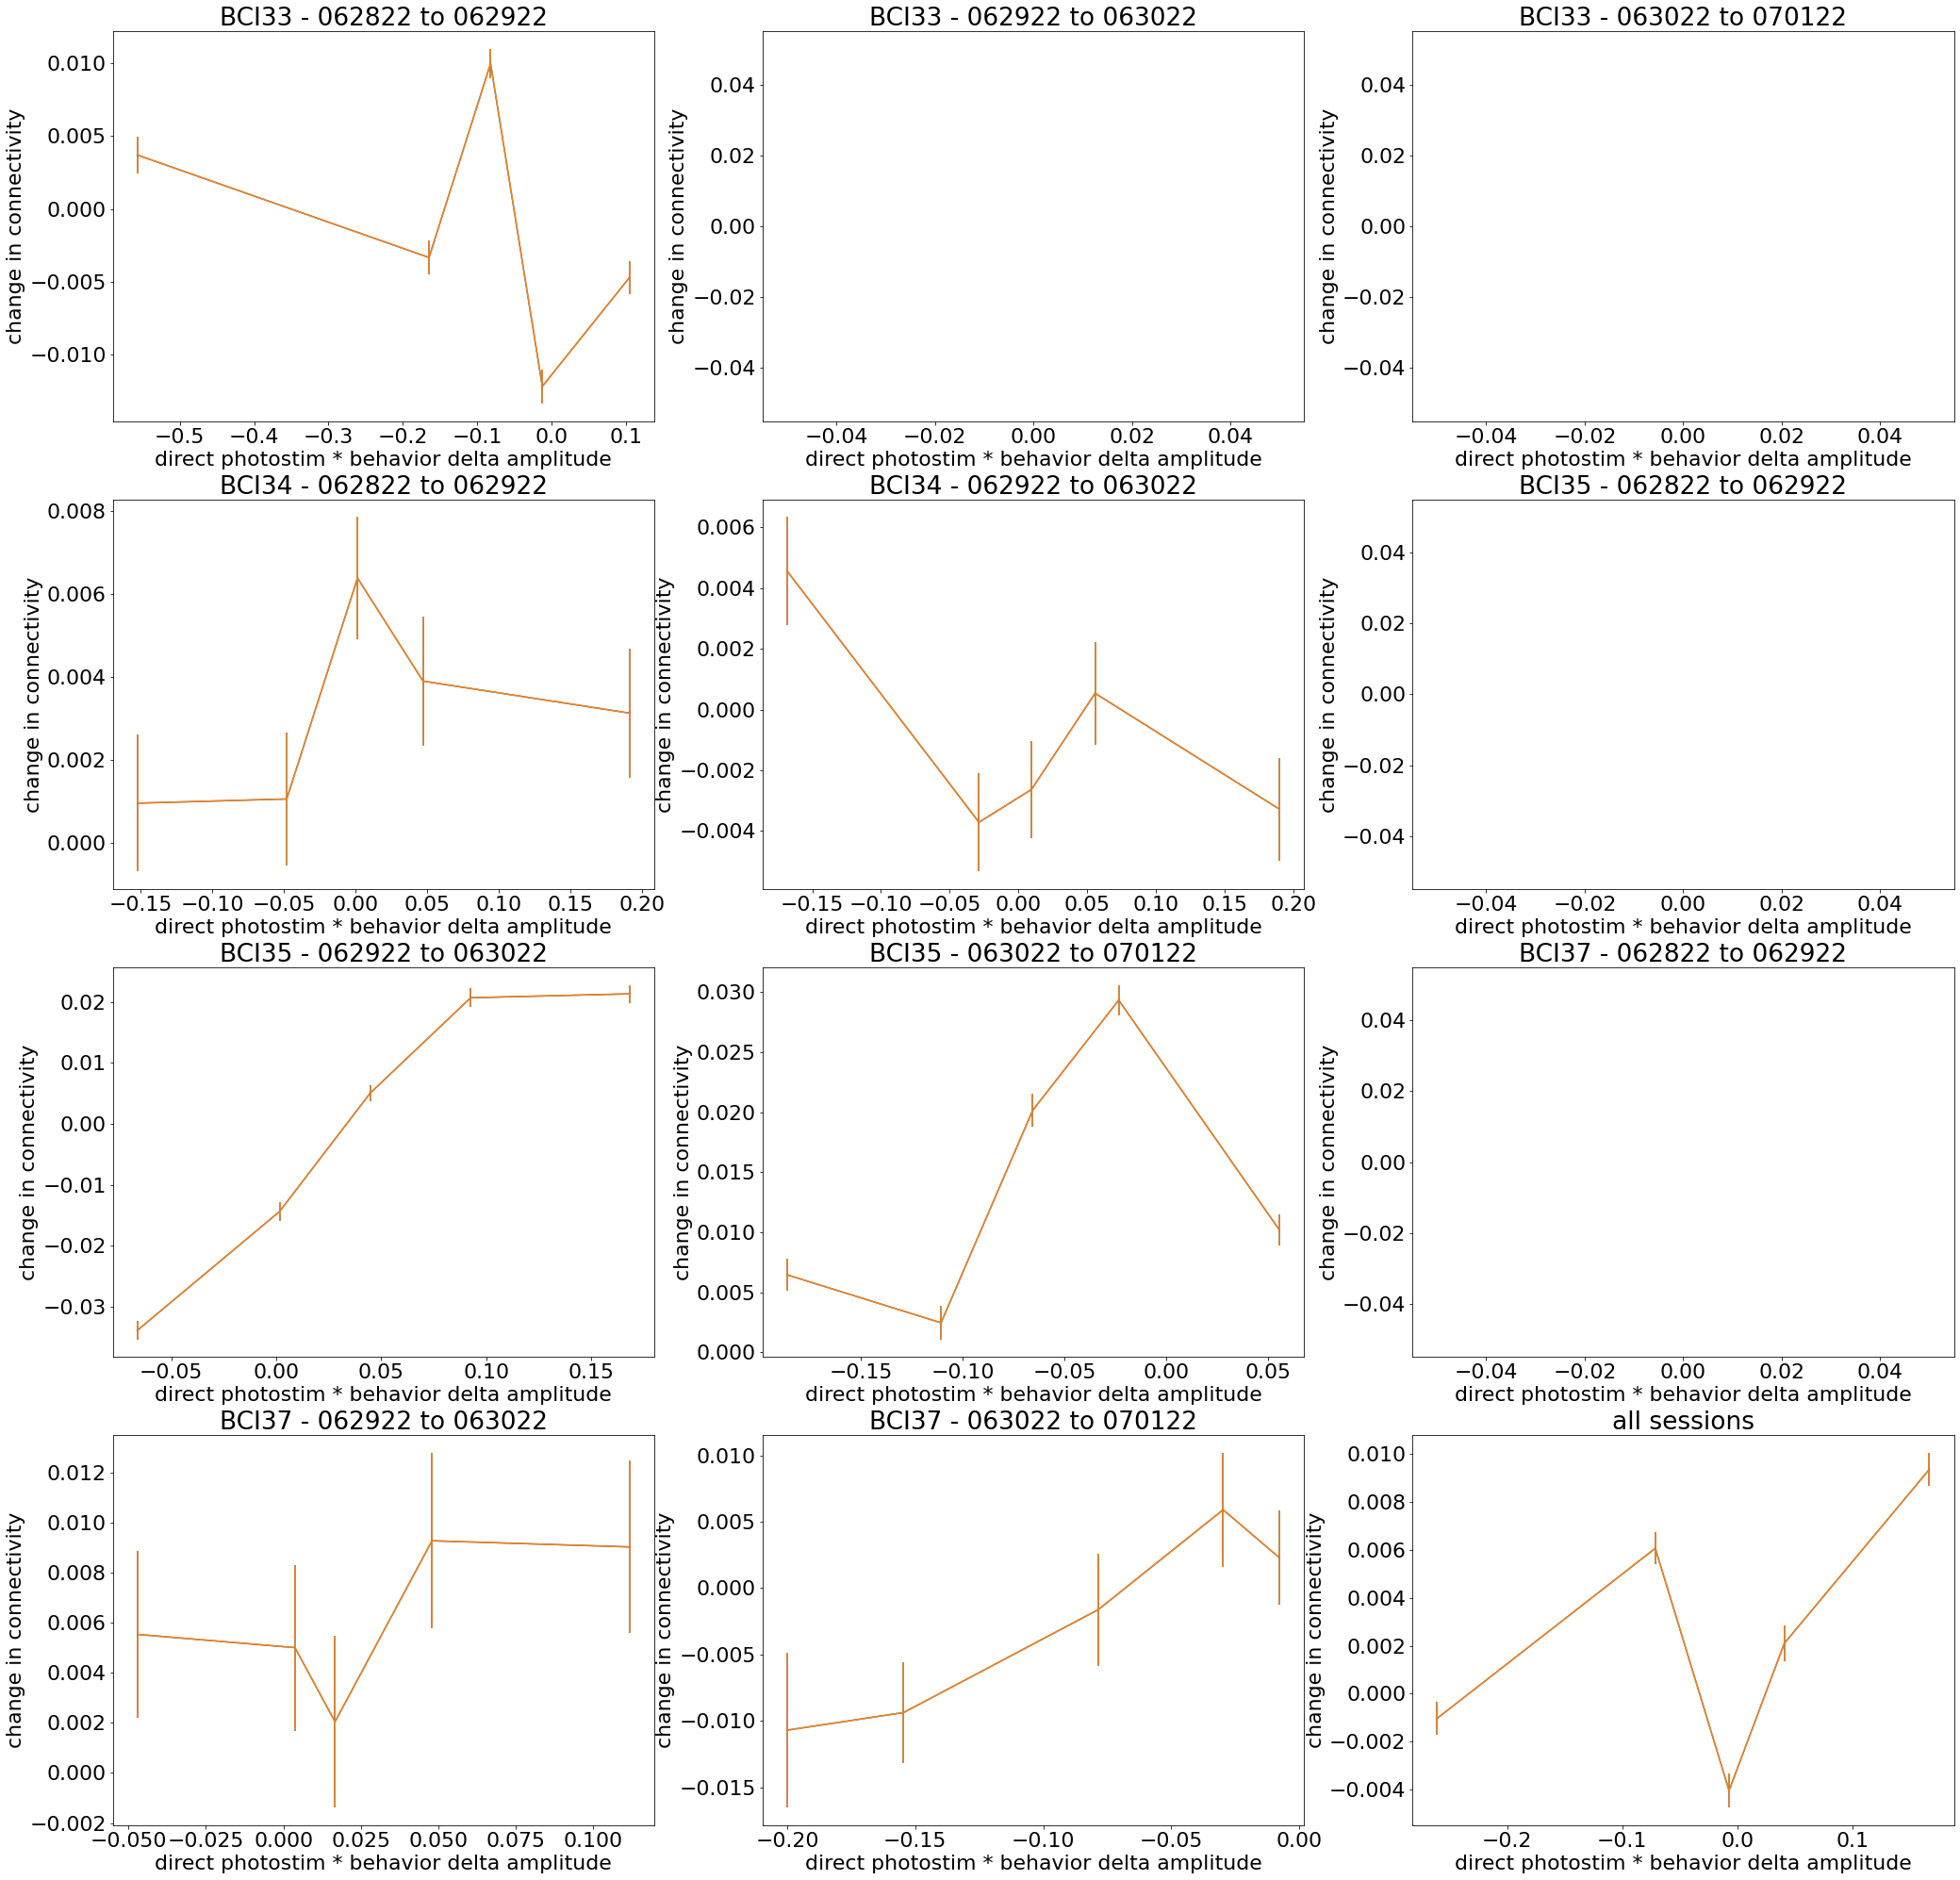

In [46]:
# PLOT ALA KAYVON
bin_num = 5
xlabel = 'direct photostim * behavior delta amplitude'#'direct photostim in cells coactivate during reward'
fig = plt.figure(figsize = [35,35])
#ax = fig.add_subplot(1,1,1)


for i,(x_list,y_list_,x_list_yesterday,title) in enumerate(zip(all_kayvon_x_lists,all_kayvon_y_lists,all_kayvon_x_lists,plot_titles_list)):#all_x_lists, all_y_lists,all_x_yesterday_lists
    
    # if i == 0:
    #     ax = fig.add_subplot(4,3,i+1)
    # else:
    #     ax = fig.add_subplot(4,3,i+1,sharex = ax,sharey = ax)
    ax = fig.add_subplot(4,3,i+1)
    
    todel = x_list==0
    x_list = x_list[todel == False]
    y_list = y_list_[todel == False]
    
    bin_x = []
    bin_y = []
    bin_y_error = []
    try:
        if len(x_list)>0:


            x_sorted = np.sort(x_list)
            x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]


            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list>=x_s)&(x_list<=x_e)
                n = sum(needed_indices)
                bin_x.append(np.nanmean(x_list[needed_indices]))
                bin_y.append(np.nanmean(y_list[needed_indices]))
                bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
        # plt.plot(x_list,y_list,'k.',alpha = .1)


        todel = x_list_yesterday==0
        x_list_yesterday = x_list_yesterday[todel == False]
        y_list = y_list_[todel == False]

        bin_x_yesterday = []
        bin_y_yesterday = []
        bin_y_error_yesterday = []
        if len(x_list_yesterday)>0:
            x_sorted = np.sort(x_list_yesterday)
            x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]

            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
                n = sum(needed_indices)
                bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
                bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
                bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


        # plt.xlim(np.percentile(x_list,[1,99]))

        ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
        ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('change in connectivity')
        ax.set_title(title)
    except:
        pass
    #ax.legend()
#fig = plt.figure()
ax = fig.add_subplot(4,3,i+2)#,sharex = ax,sharey = ax)
x_list = np.concatenate(all_kayvon_x_lists)#all_x_lists
y_list_= np.concatenate(all_kayvon_y_lists)#all_y_lists
x_list_yesterday= np.concatenate(all_kayvon_x_lists)#np.concatenate(all_x_yesterday_lists)
title = 'all sessions'

todel = x_list==0
x_list = x_list[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list)
x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

bin_x = []
bin_y = []
bin_y_error = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list>=x_s)&(x_list<=x_e)
    n = sum(needed_indices)
    bin_x.append(np.nanmean(x_list[needed_indices]))
    bin_y.append(np.nanmean(y_list[needed_indices]))
    bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
# plt.plot(x_list,y_list,'k.',alpha = .1)


todel = x_list_yesterday==0
x_list_yesterday = x_list_yesterday[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list_yesterday)
x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]
bin_x_yesterday = []
bin_y_yesterday = []
bin_y_error_yesterday = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
    n = sum(needed_indices)
    bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
    bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
    bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


# plt.xlim(np.percentile(x_list,[1,99]))
ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
#ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel('change in connectivity')
ax.set_title(title)

Text(0, 0.5, 'tuning')

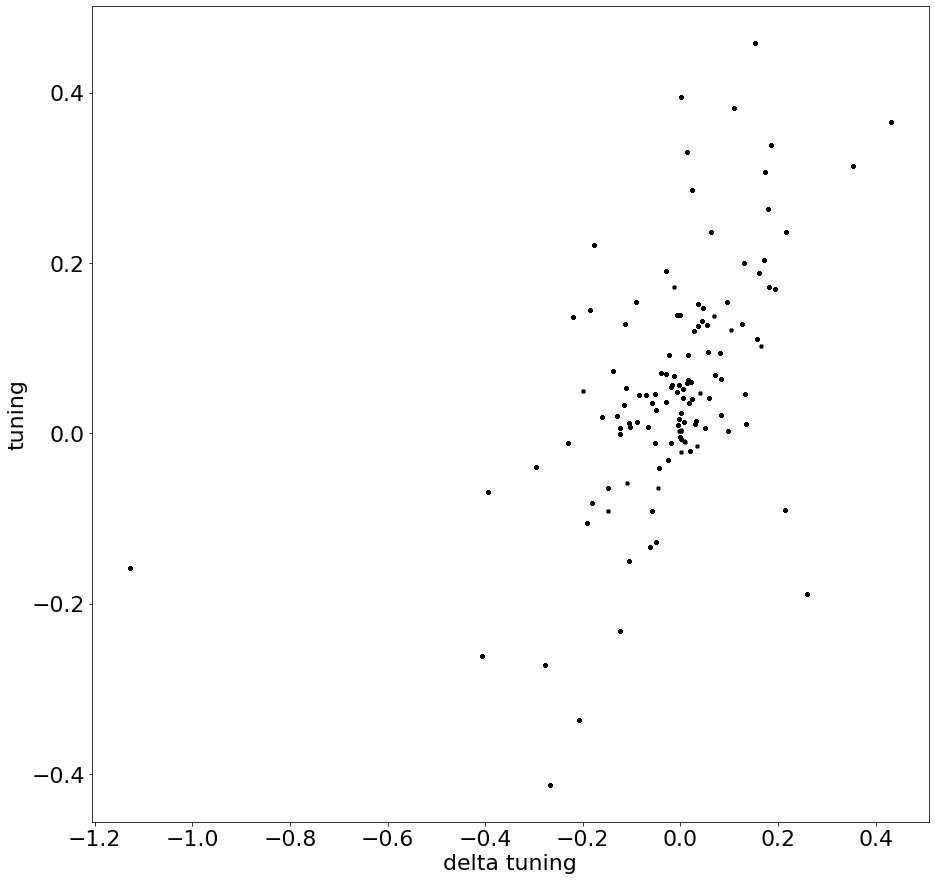

In [47]:
fig = plt.figure(figsize = [15,15])
ax = fig.add_subplot(1,1,1)
ax.plot(np.concatenate(all_kayvon_x_lists),np.concatenate(all_pre_weighted_amplitudes_list),'k.',alpha = .01)
ax.set_xlabel('delta tuning')
ax.set_ylabel('tuning')

In [48]:
len(np.unique(x_sorted))

124

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


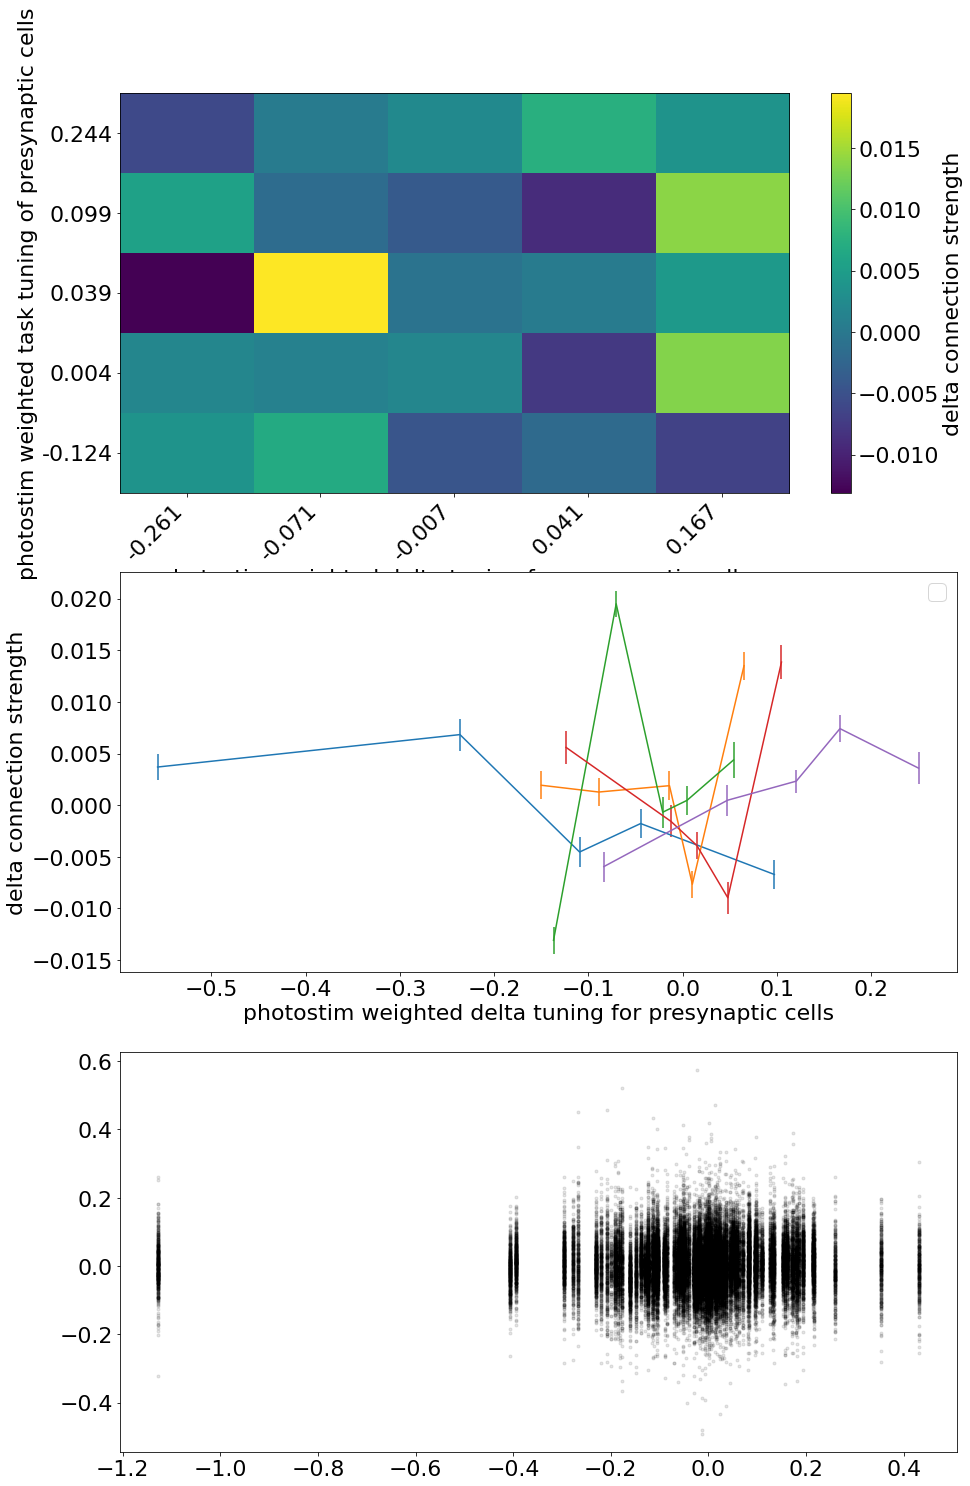

In [49]:
#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 5
subtract_median = False


x_list_all =np.concatenate(all_kayvon_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'photostim weighted delta tuning for presynaptic cells'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)#
y_base_list_all =  np.concatenate(all_pre_weighted_amplitudes_list)#-np.concatenate(all_post_reward_amplitudes)#np.nanmean([np.concatenate(all_post_amplitudes_list),np.concatenate(all_post_amplitudes_yesterday_list)],0)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
#y_base_list_all =  np.concatenate(all_post_amplitudes_list)
third_axis_label = 'photostim weighted task tuning of presynaptic cells'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
n_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
        
    x_sorted = np.sort(x_list)

    x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num_x)))-1]
    x_ends = x_starts[1:]
    x_starts = x_starts[:-1]     
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)
        n_matrix[xi,yi] = len(np.unique(x_list[needed_indices]))

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

In [50]:
sum(n_matrix)

array([30., 28., 30., 31., 29.])

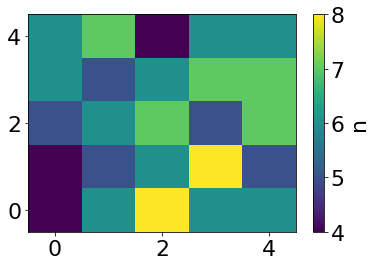

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(n_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
fig.colorbar(im,ax = ax,label = 'n')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


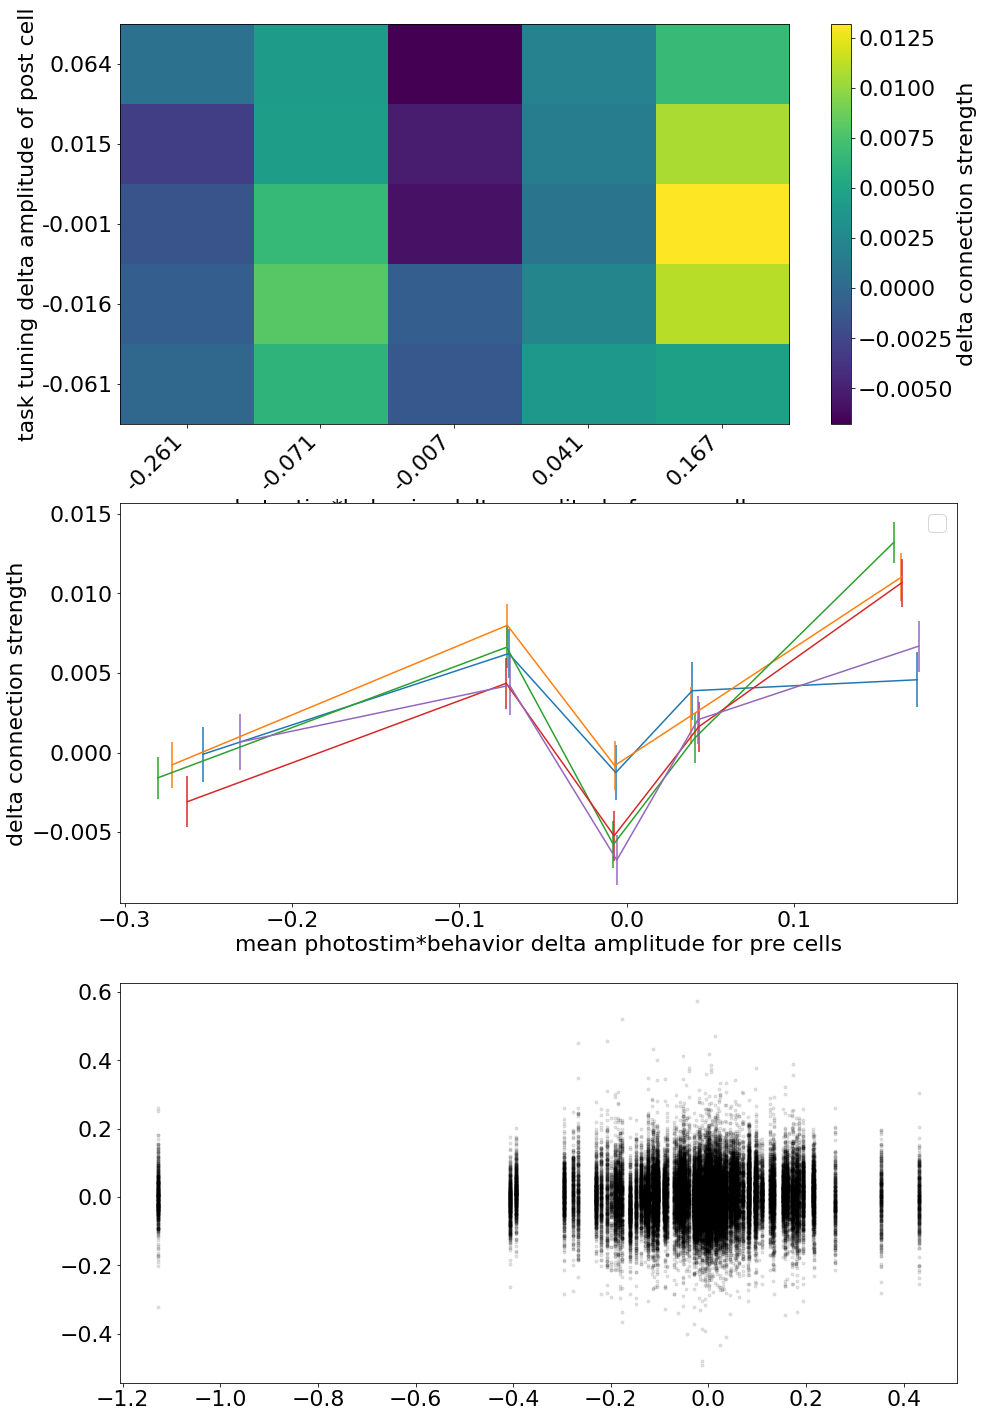

In [52]:
#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 5
subtract_median = False


x_list_all =np.concatenate(all_kayvon_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean photostim*behavior delta amplitude for pre cells'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)#
y_base_list_all =  np.concatenate(all_post_delta_amplitudes_list)#-np.concatenate(all_post_reward_amplitudes)#np.nanmean([np.concatenate(all_post_amplitudes_list),np.concatenate(all_post_amplitudes_yesterday_list)],0)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
#y_base_list_all =  np.concatenate(all_post_amplitudes_list)
third_axis_label = 'task tuning delta amplitude of post cell'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
n_matrix= np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)
        n_matrix[xi,yi] = n#len(np.unique(x_list[needed_indices]))
fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


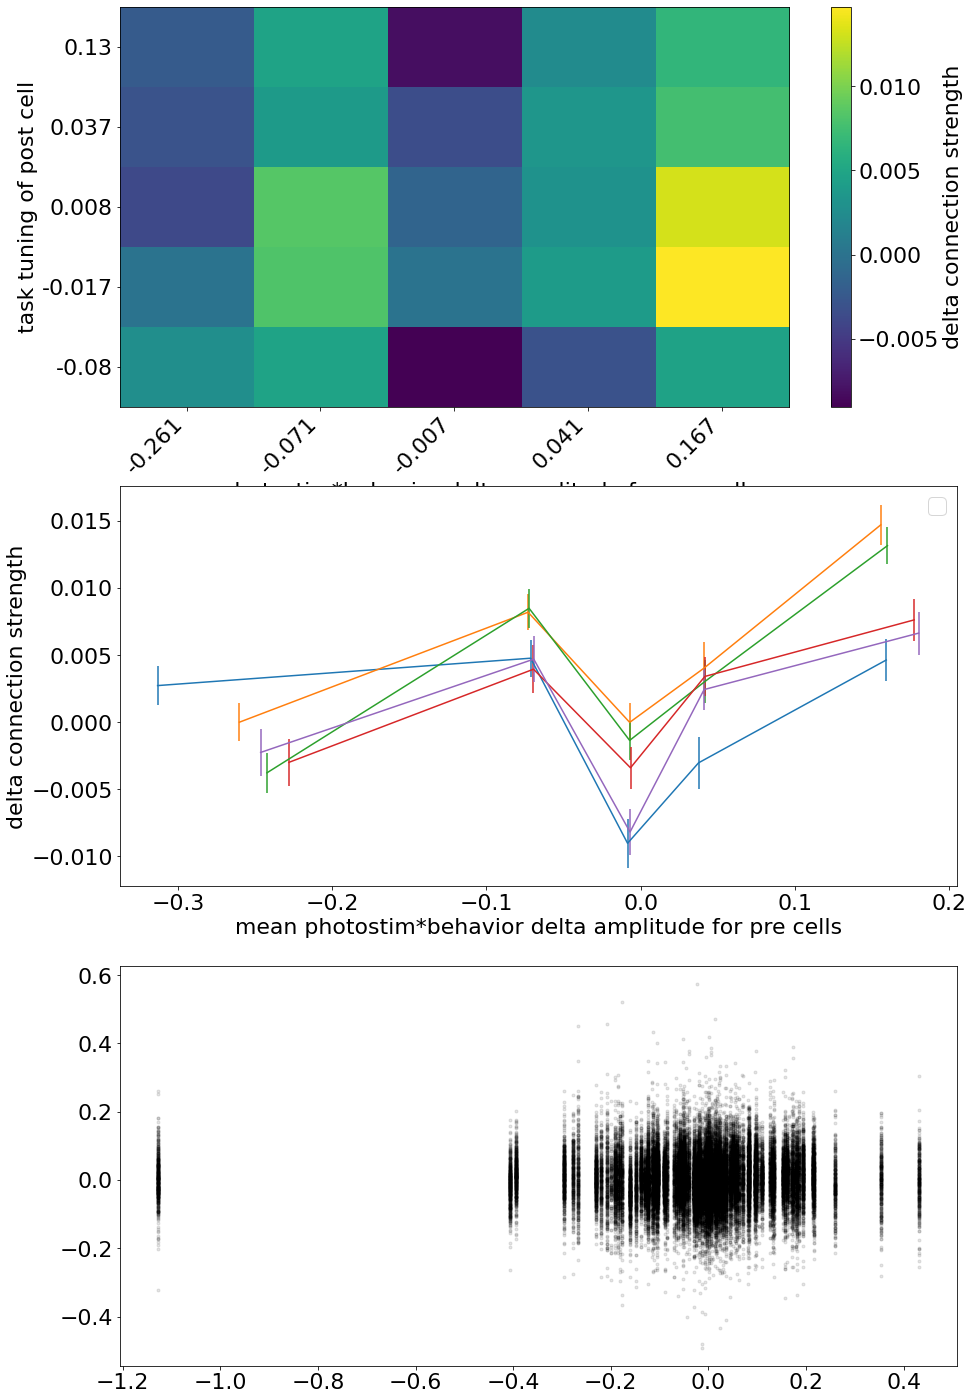

In [53]:
#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 5
subtract_median = False


x_list_all =np.concatenate(all_kayvon_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean photostim*behavior delta amplitude for pre cells'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)#
y_base_list_all =  np.concatenate(all_post_amplitudes_list)#-np.concatenate(all_post_reward_amplitudes)#np.nanmean([np.concatenate(all_post_amplitudes_list),np.concatenate(all_post_amplitudes_yesterday_list)],0)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
#y_base_list_all =  np.concatenate(all_post_amplitudes_list)
third_axis_label = 'task tuning of post cell'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
n_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)
        n_matrix[xi,yi] = n#len(np.unique(x_list[needed_indices]))
fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

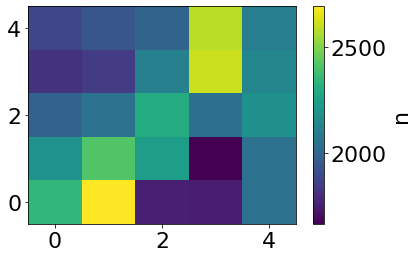

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(n_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
fig.colorbar(im,ax = ax,label = 'n')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


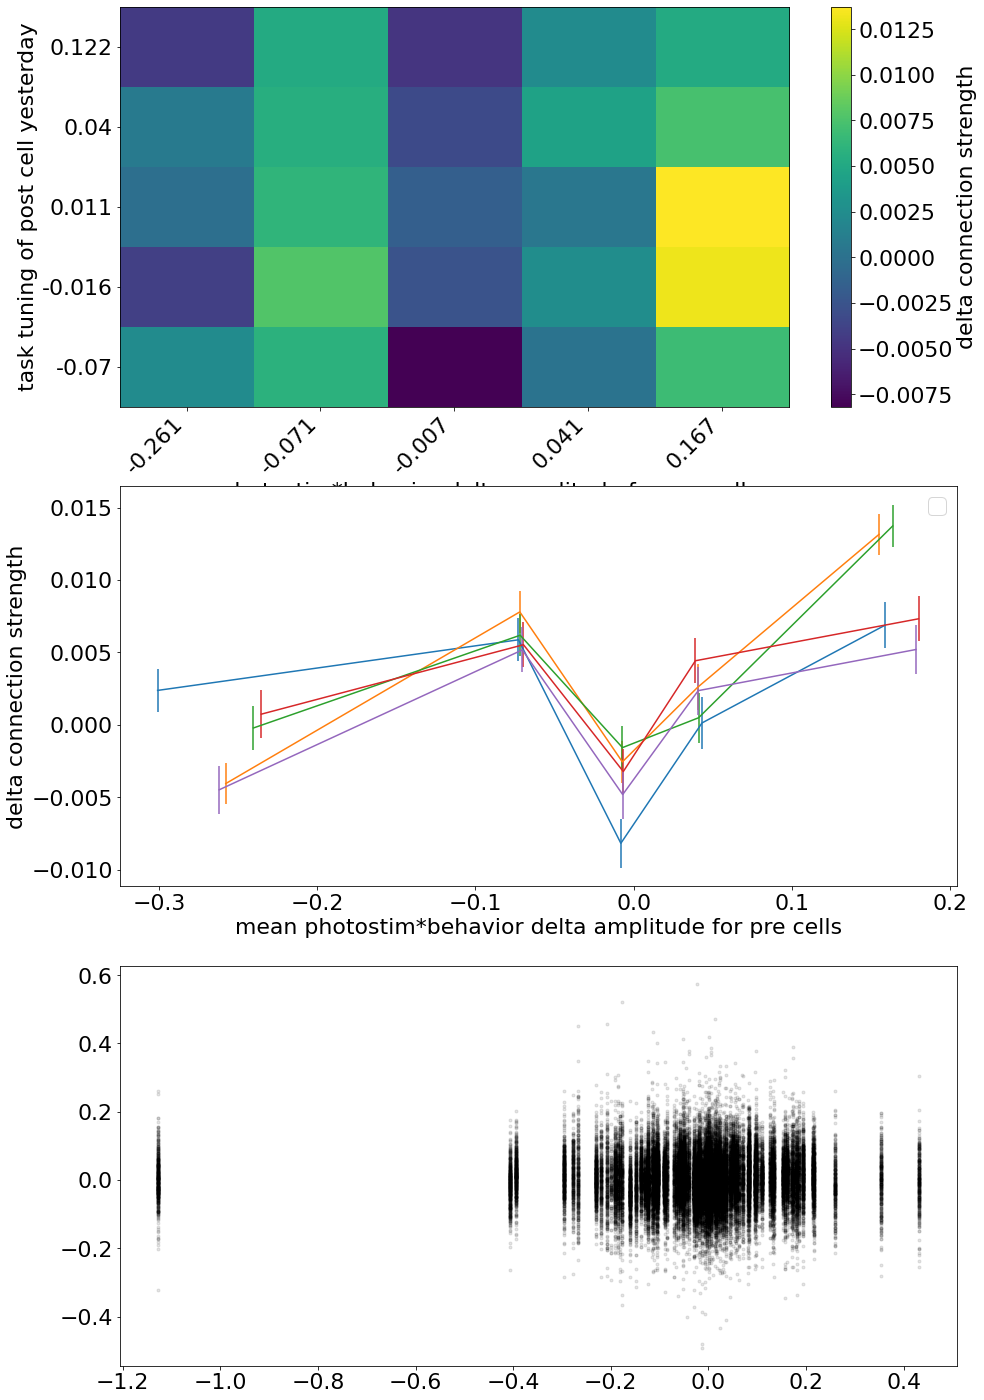

In [55]:
#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 5
subtract_median = False


x_list_all =np.concatenate(all_kayvon_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean photostim*behavior delta amplitude for pre cells'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)#
y_base_list_all =  np.concatenate(all_post_amplitudes_yesterday_list)#-np.concatenate(all_post_reward_amplitudes)#np.nanmean([np.concatenate(all_post_amplitudes_list),np.concatenate(all_post_amplitudes_yesterday_list)],0)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
#y_base_list_all =  np.concatenate(all_post_amplitudes_list)
third_axis_label = 'task tuning of post cell yesterday'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'correlation')

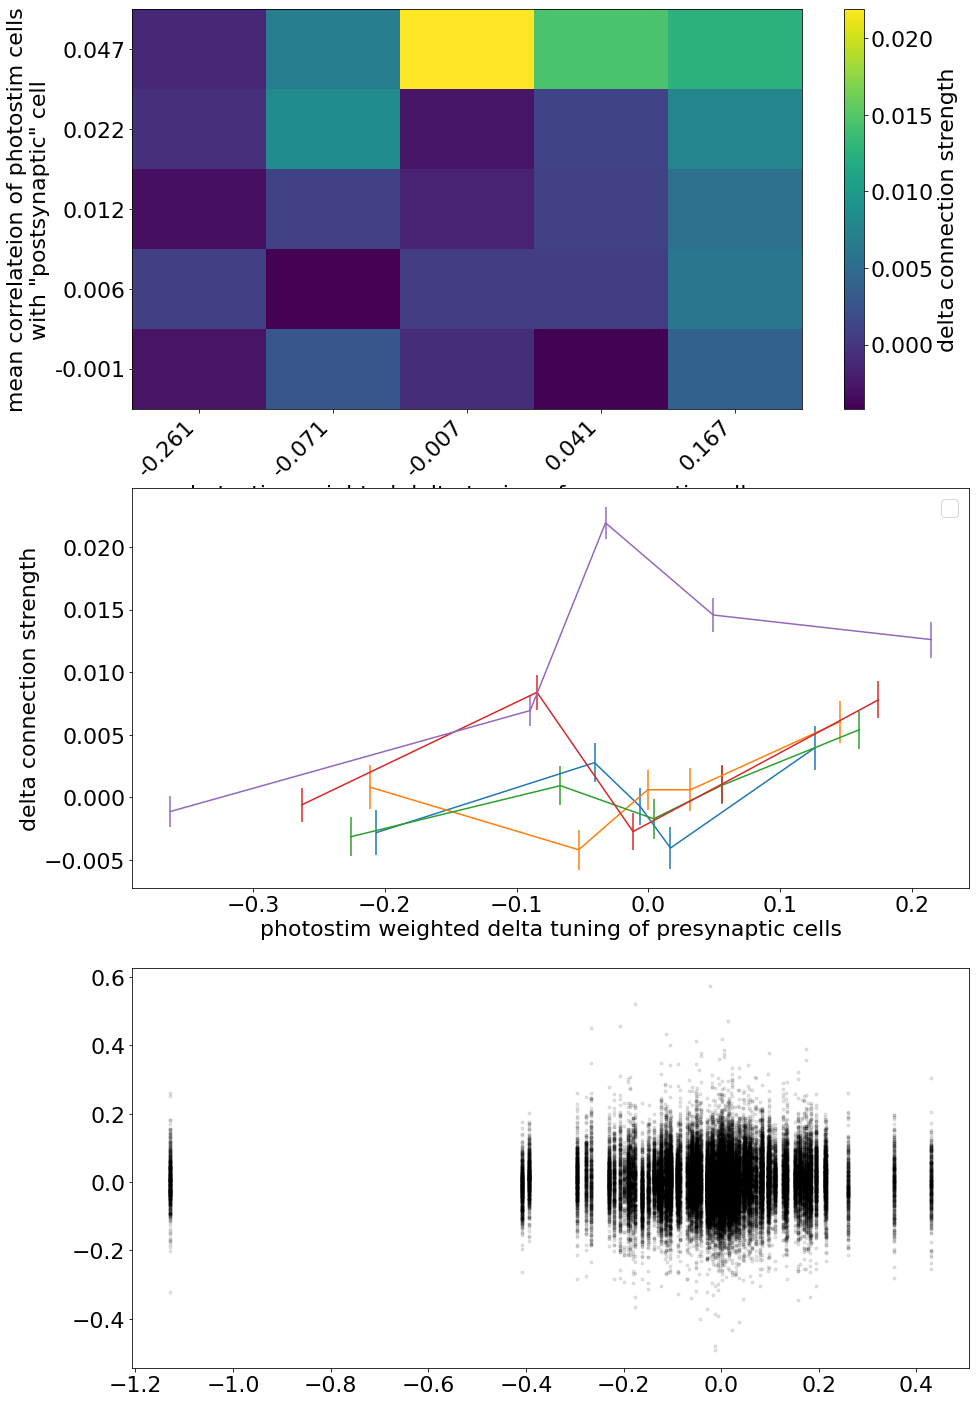

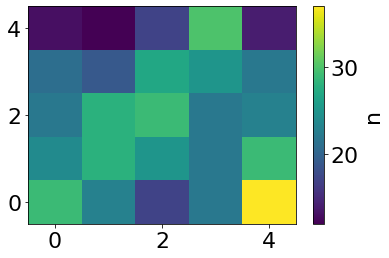

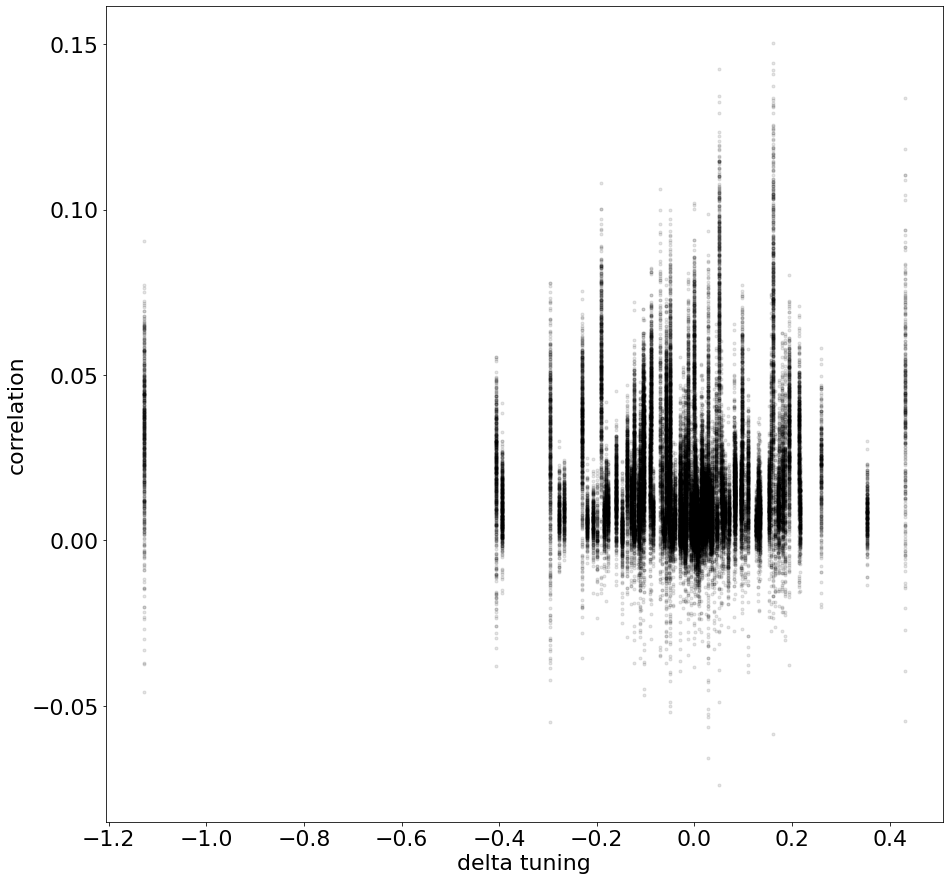

In [56]:
#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 5
subtract_median = False

#
x_list_all =np.concatenate(all_kayvon_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'photostim weighted delta tuning of presynaptic cells'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)
y_base_list_all =  np.concatenate(all_x_lists) 
third_axis_label = 'mean correlateion of photostim cells\nwith "postsynaptic" cell'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
n_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    x_sorted = np.sort(x_list)

    x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num_x)))-1]
    x_ends = x_starts[1:]
    x_starts = x_starts[:-1]
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)
        n_matrix[xi,yi] =len(np.unique(x_list[needed_indices]))
fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(n_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
fig.colorbar(im,ax = ax,label = 'n')



fig = plt.figure(figsize = [15,15])
ax = fig.add_subplot(1,1,1)
ax.plot(np.concatenate(all_kayvon_x_lists),np.concatenate(all_x_lists),'k.',alpha = .1)
ax.set_xlabel('delta tuning')
ax.set_ylabel('correlation')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


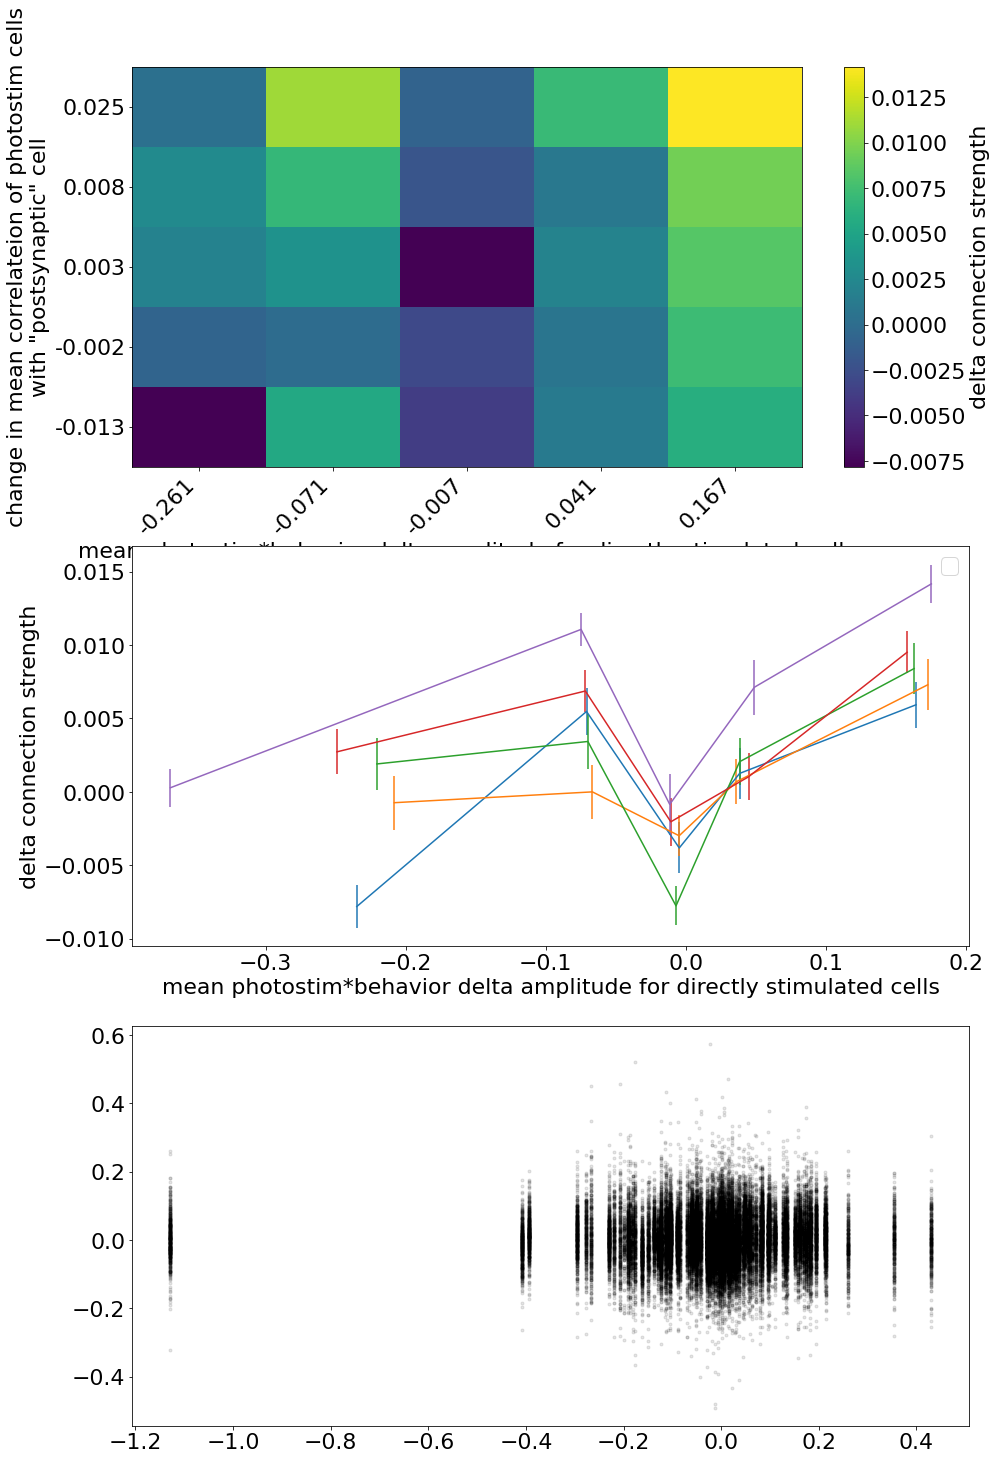

In [57]:
#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 5
subtract_median = False


x_list_all =np.concatenate(all_kayvon_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean photostim*behavior delta amplitude for directly stimulated cells'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)
y_base_list_all =  (np.concatenate(all_x_lists)- np.concatenate(all_x_yesterday_lists))#all_y_base_lists)#all_x_lists)##np.concatenate(all_post_amplitudes_list) - np.concatenate(all_post_amplitudes_yesterday_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'change in mean correlateion of photostim cells\nwith "postsynaptic" cell'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

/opt/conda/envs/bci_with_suite2p/lib/python3.8/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


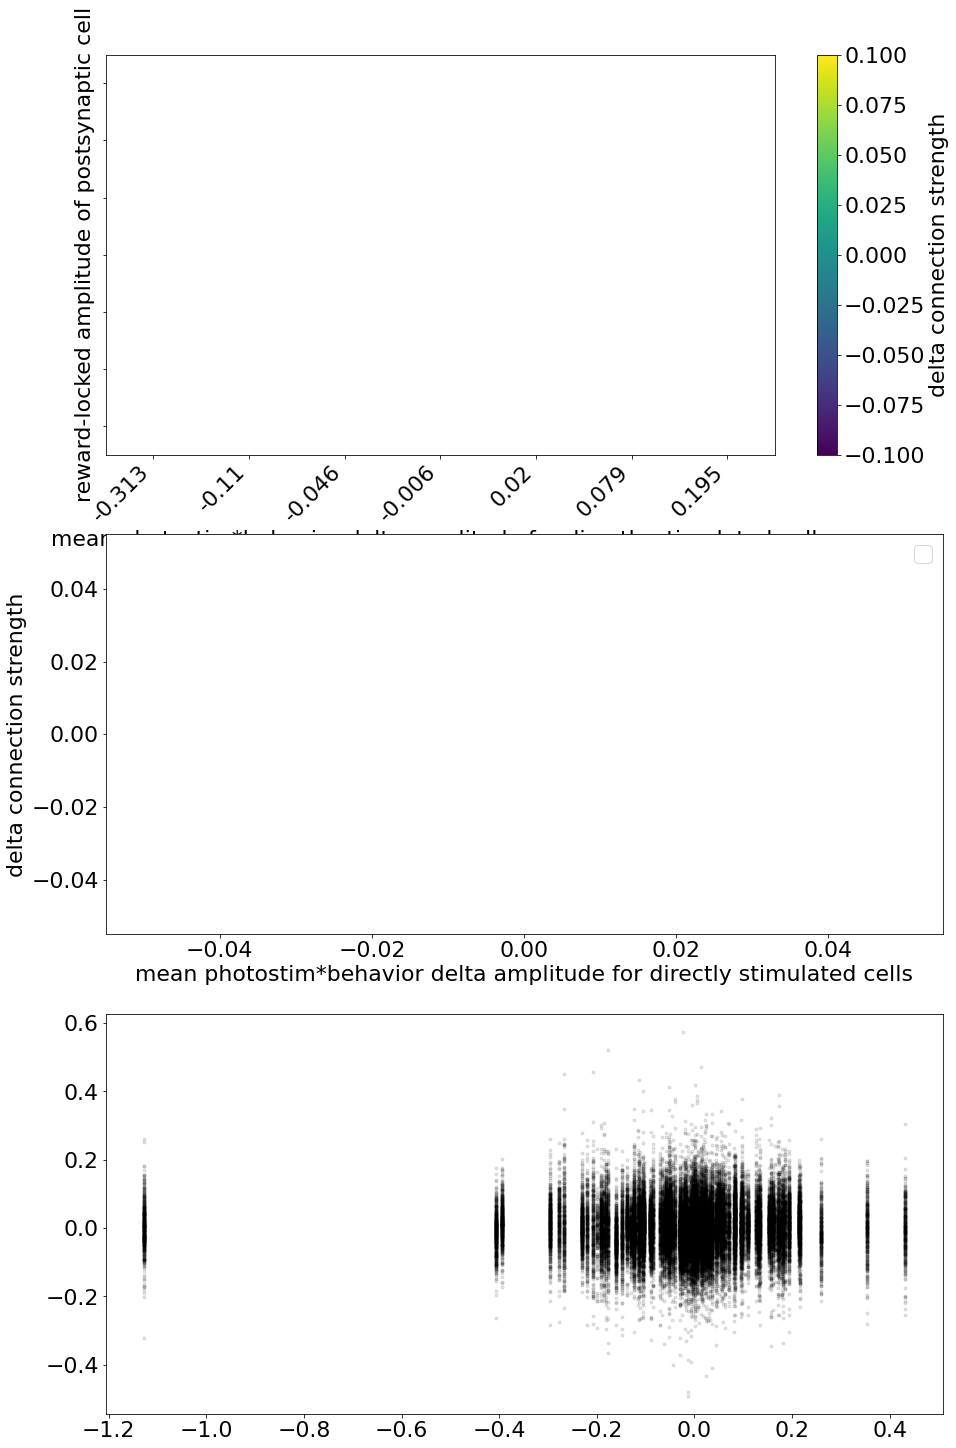

In [58]:
#meg mindig kayvon stuff

bin_num_x= 7
bin_num_y= 7
subtract_median = False


x_list_all =np.concatenate(all_kayvon_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean photostim*behavior delta amplitude for directly stimulated cells'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)
y_base_list_all =  np.concatenate(all_post_reward_amplitudes)#all_y_base_lists)#all_x_lists)##np.concatenate(all_post_amplitudes_list) - np.concatenate(all_post_amplitudes_yesterday_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'reward-locked amplitude of postsynaptic cell'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


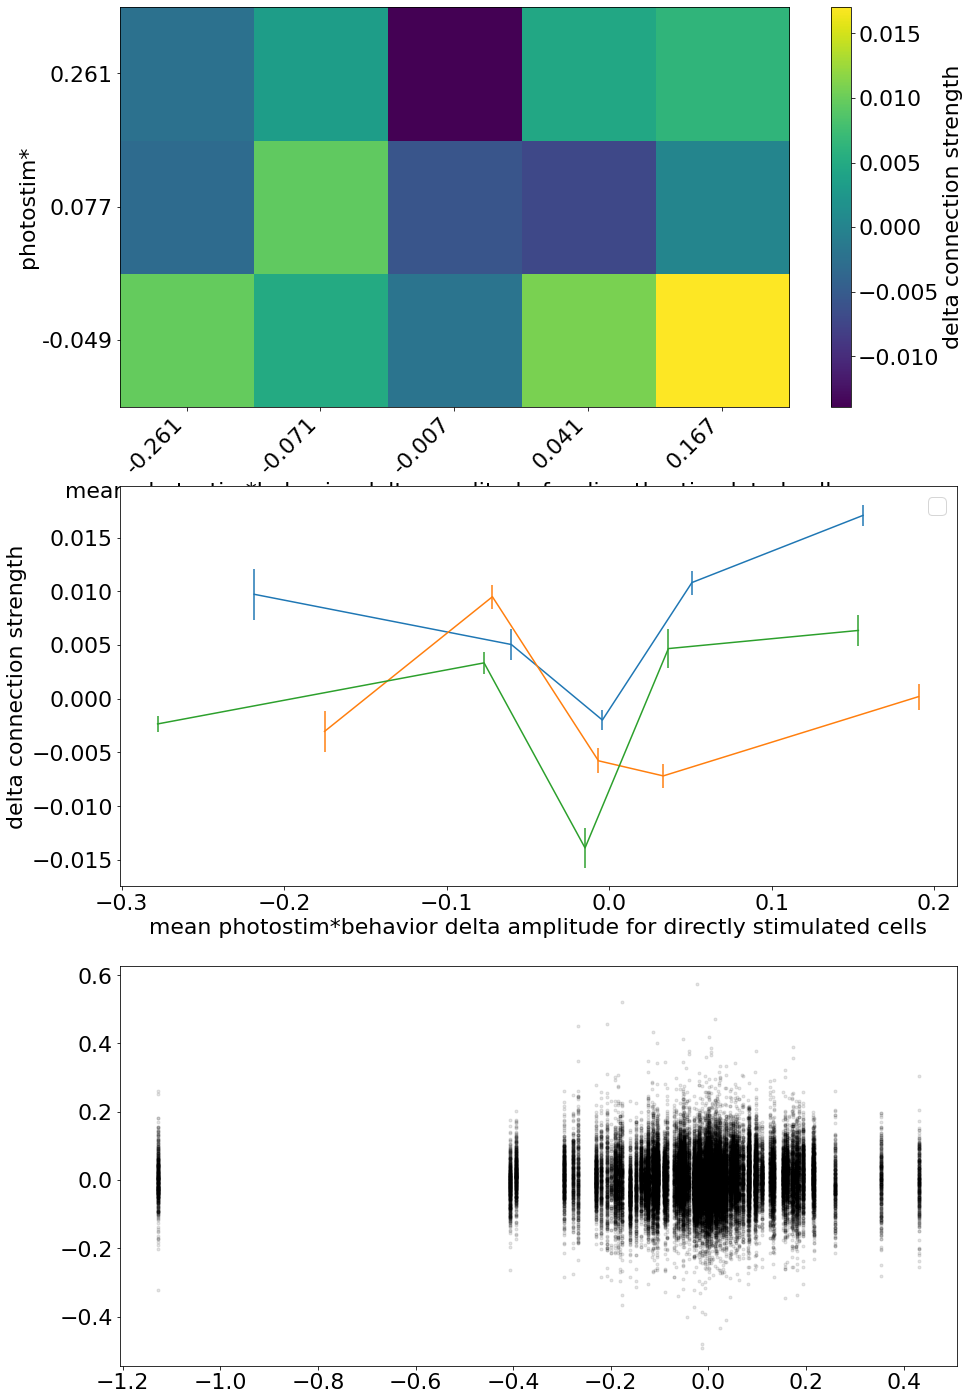

In [59]:

#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 3
subtract_median = False


x_list_all =np.concatenate(all_kayvon_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean photostim*behavior delta amplitude for directly stimulated cells'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)
y_base_list_all =  np.concatenate(all_pre_weighted_amplitudes_yesterday_list)#all_y_base_lists)#all_x_lists)##np.concatenate(all_post_amplitudes_list) - np.concatenate(all_post_amplitudes_yesterday_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'photostim*'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


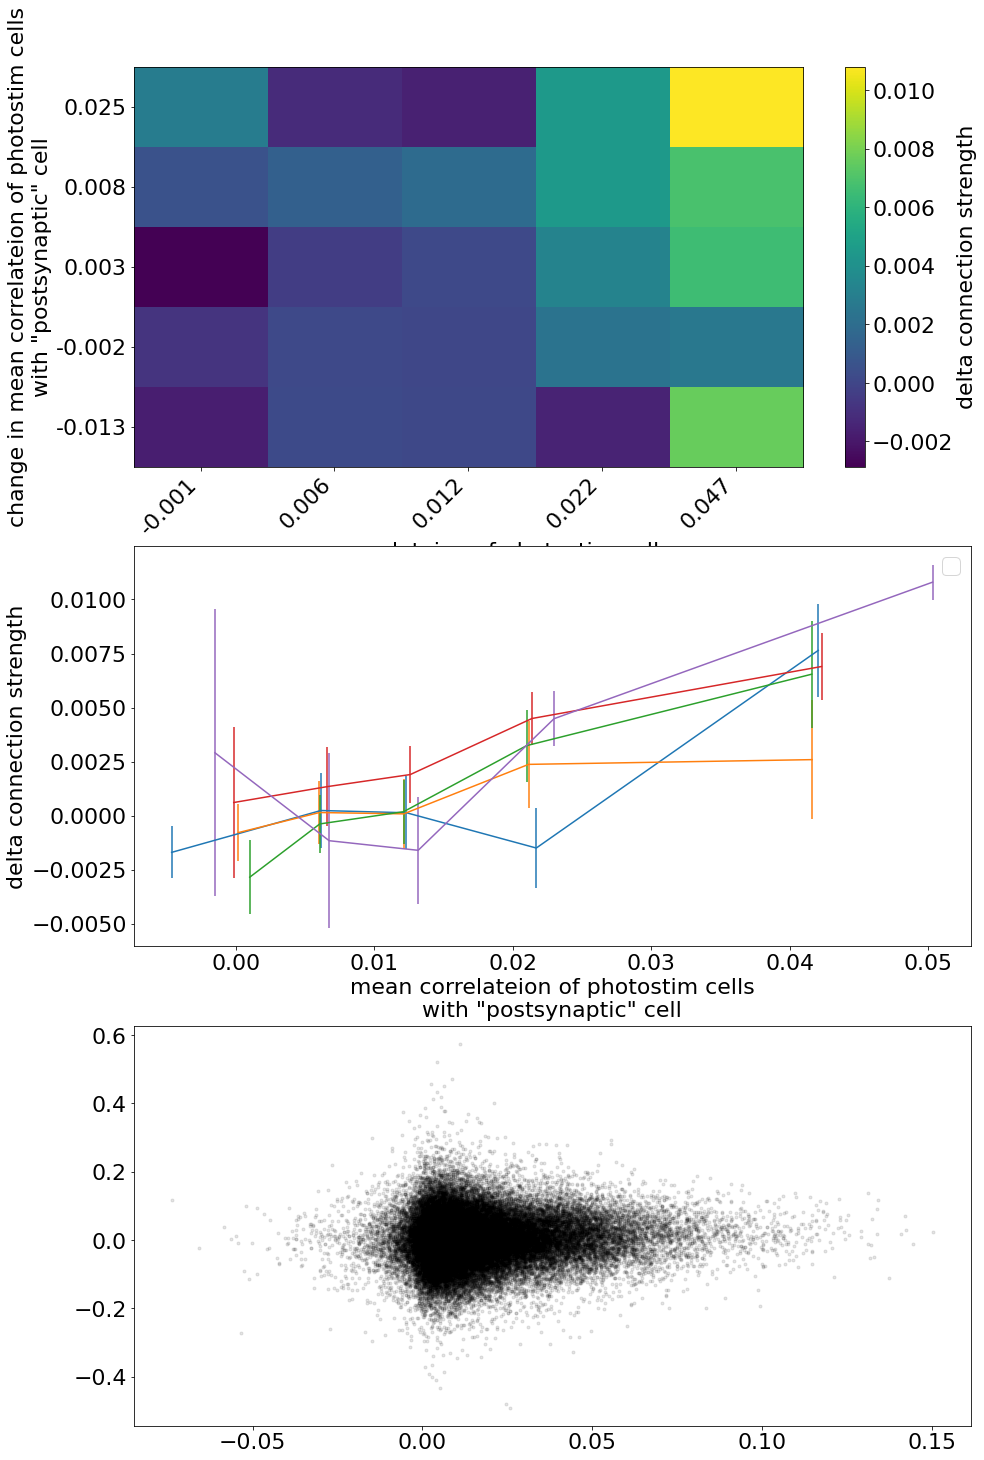

In [60]:
#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 5
subtract_median = False


x_list_all =np.concatenate(all_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean correlateion of photostim cells\nwith "postsynaptic" cell'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)
y_base_list_all =  (np.concatenate(all_x_lists)- np.concatenate(all_x_yesterday_lists))#all_y_base_lists)#all_x_lists)##np.concatenate(all_post_amplitudes_list) - np.concatenate(all_post_amplitudes_yesterday_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'change in mean correlateion of photostim cells\nwith "postsynaptic" cell'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


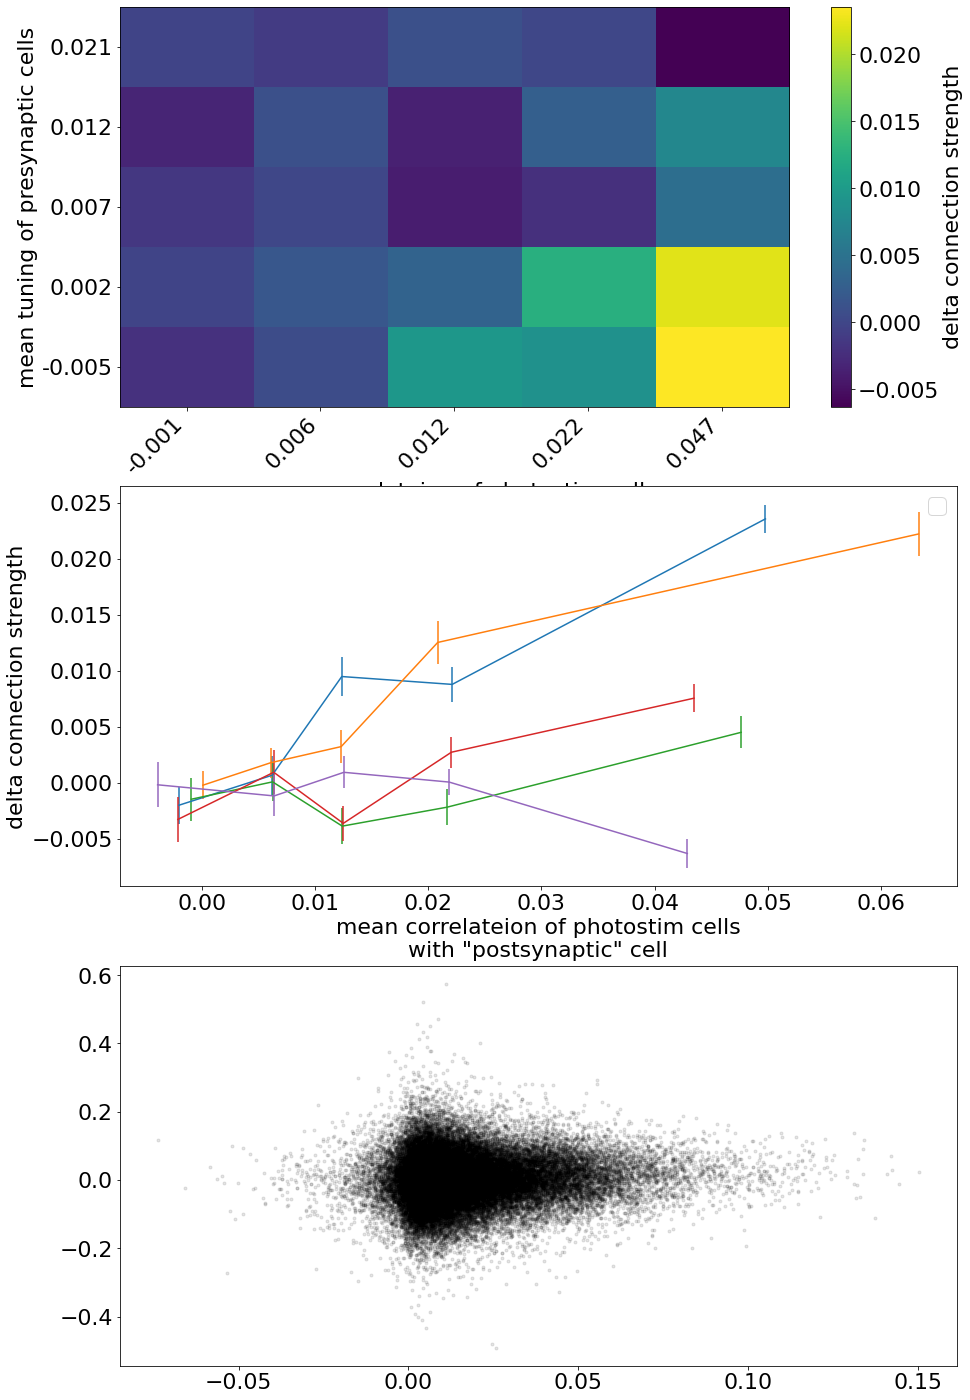

In [61]:


#meg mindig kayvon stuff

bin_num_x= 5
bin_num_y= 5
subtract_median = False


x_list_all =np.concatenate(all_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean correlateion of photostim cells\nwith "postsynaptic" cell'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_kayvon_y_lists)
y_base_list_all =  np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_y_base_lists)#all_x_lists)##np.concatenate(all_post_amplitudes_list) - np.concatenate(all_post_amplitudes_yesterday_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'mean tuning of presynaptic cells'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

Text(0.5, 1.0, 'all sessions')

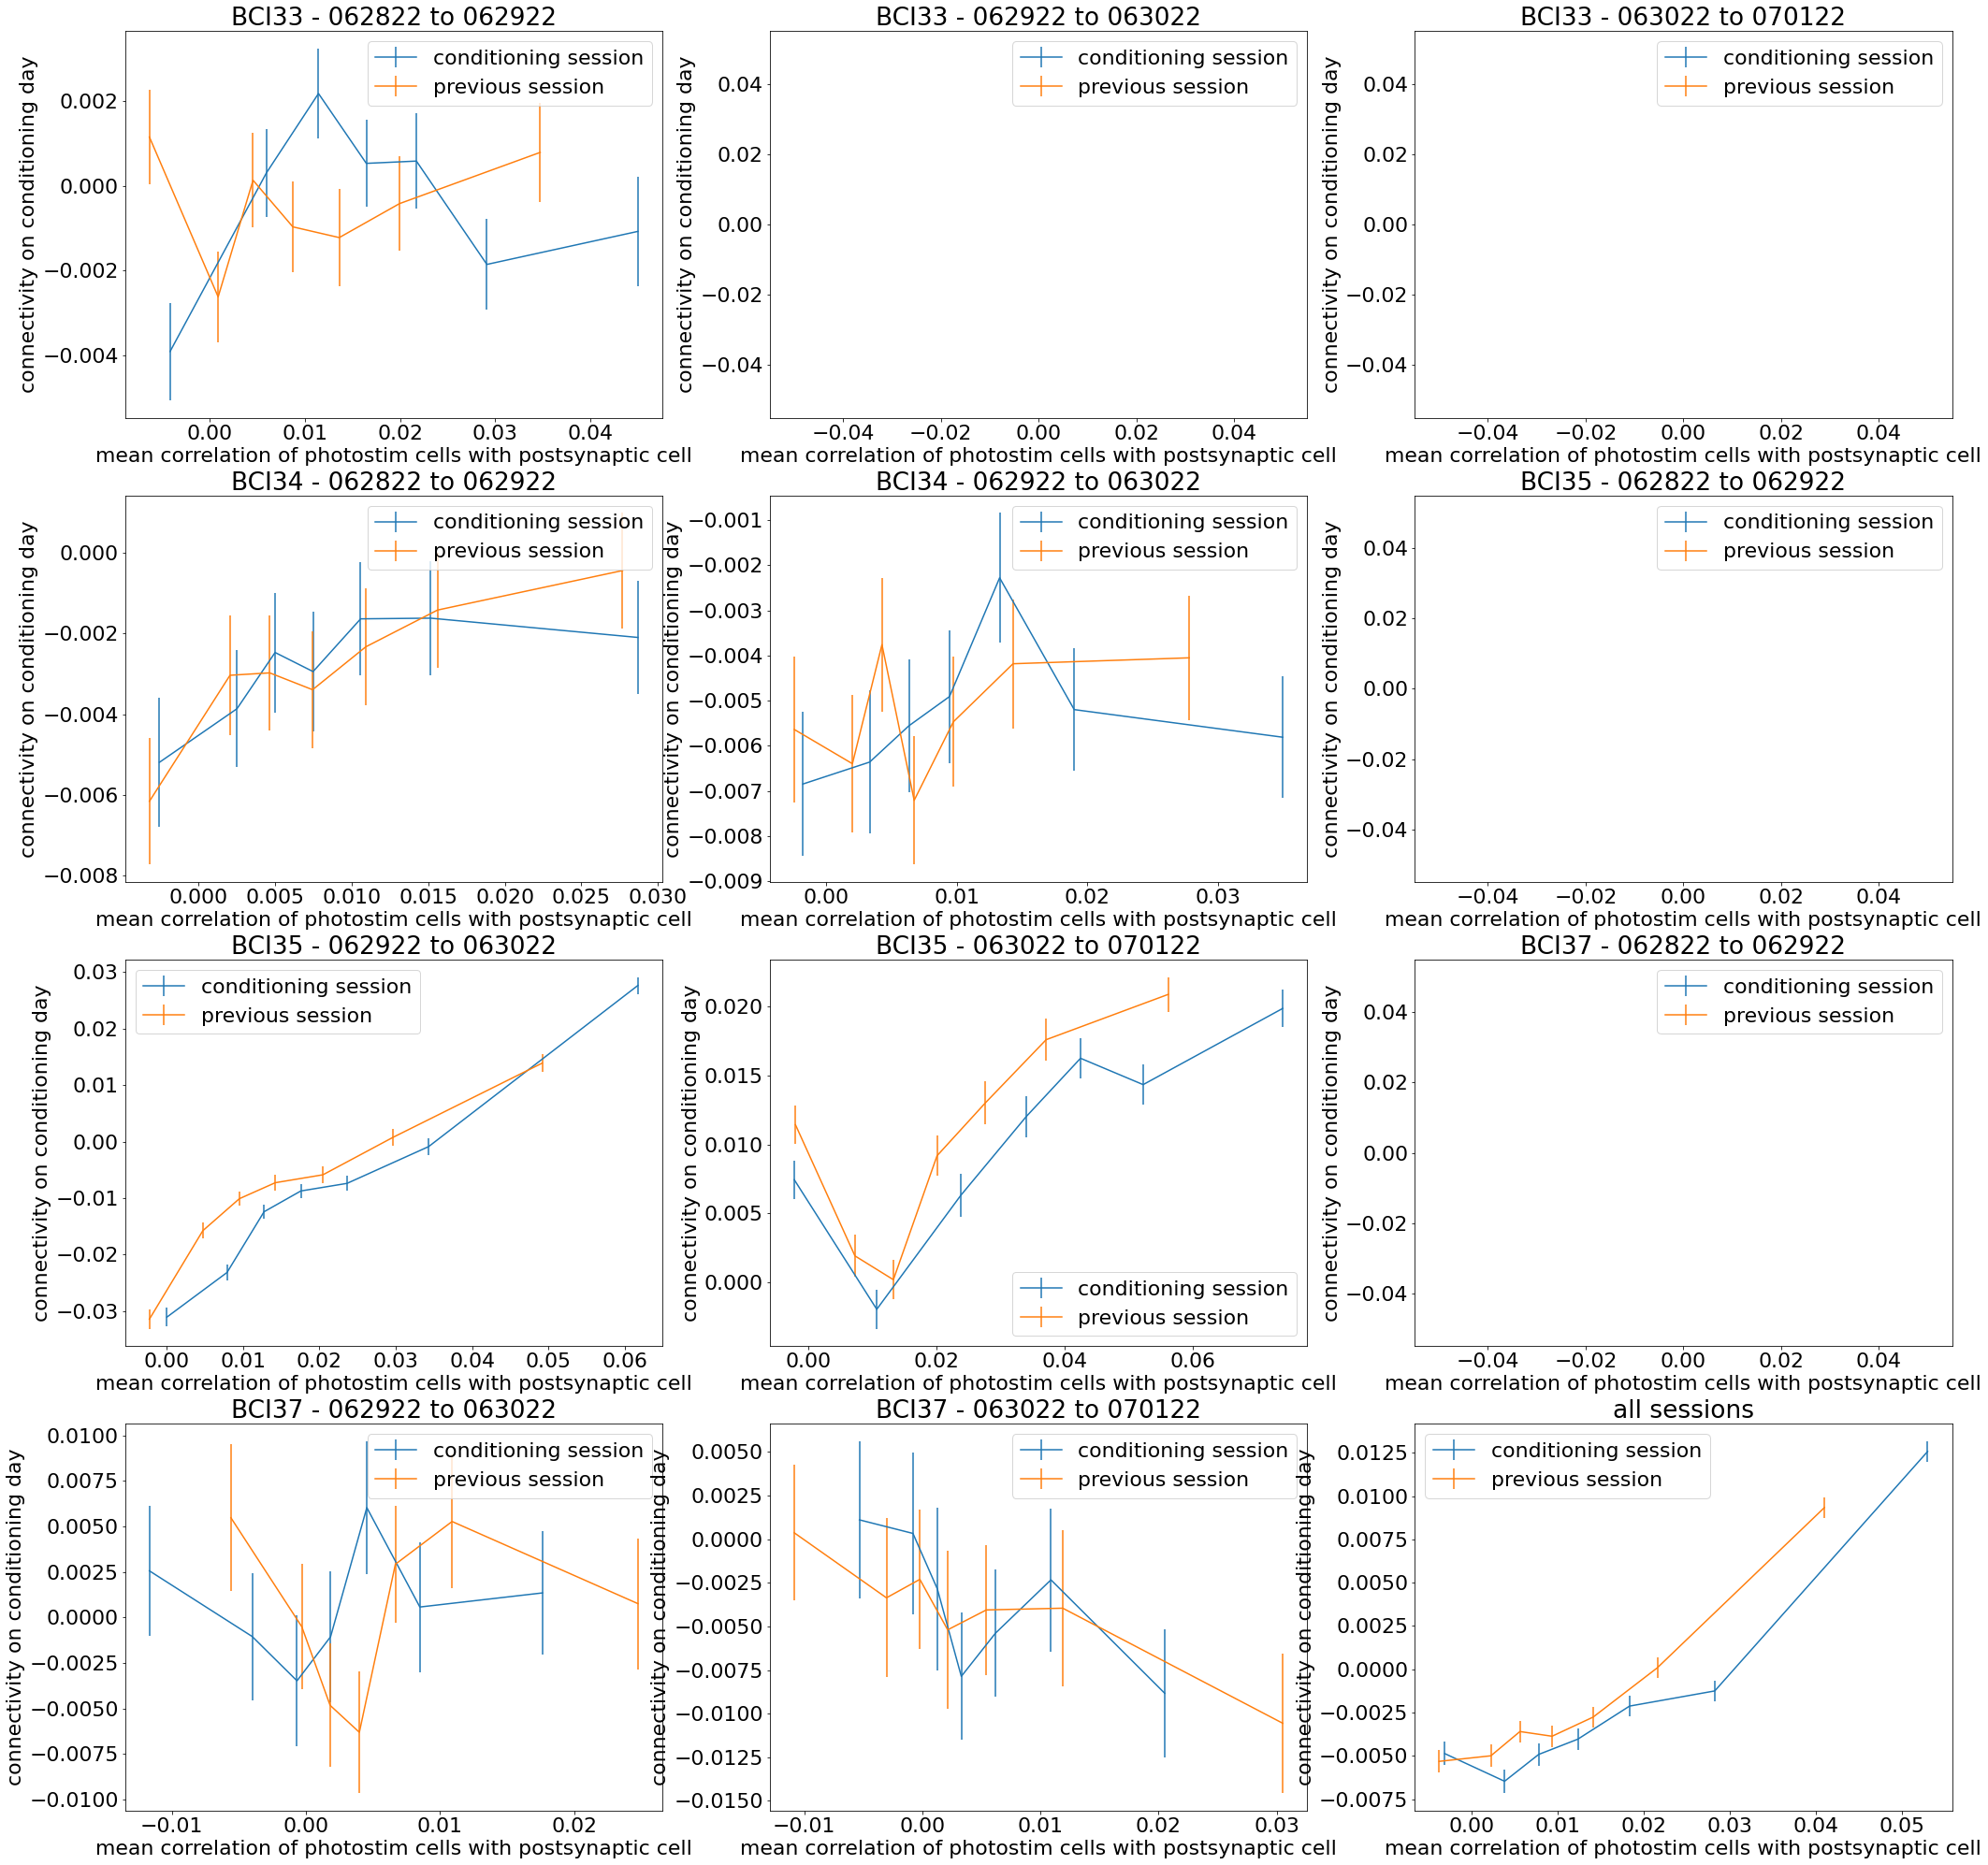

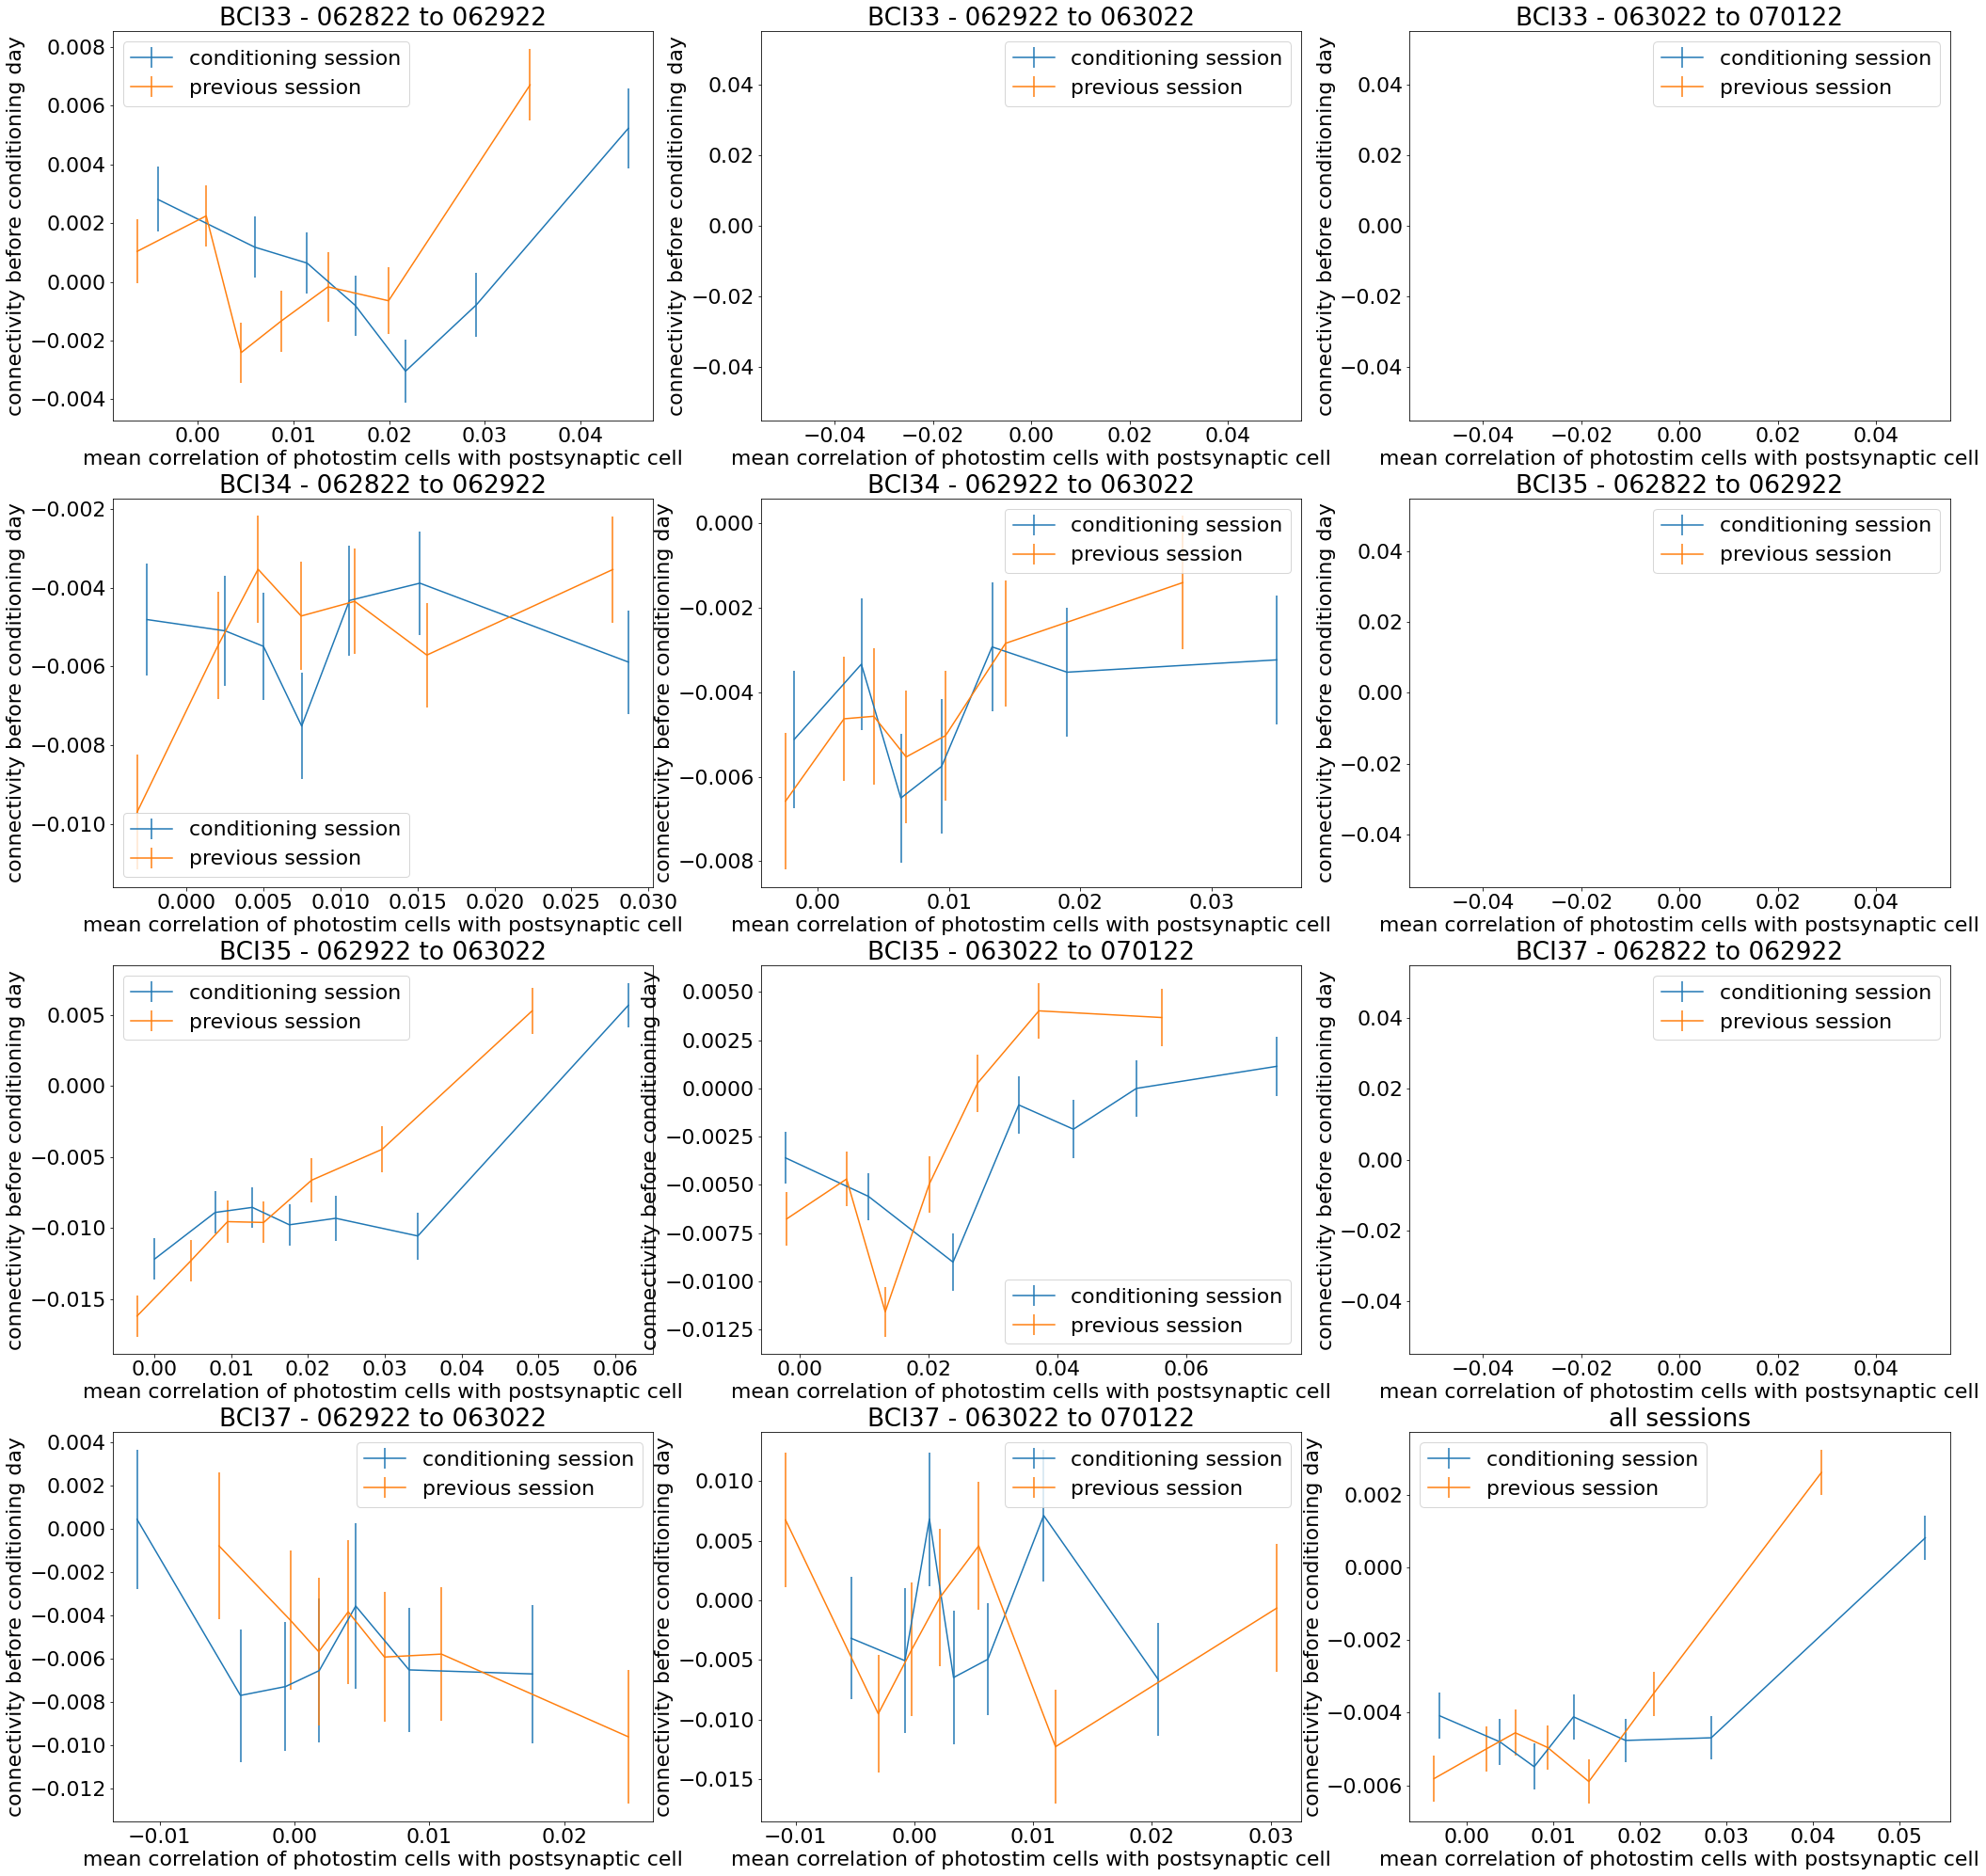

In [62]:
#photostim amplitude (not difference)

bin_num = 7
xlabel = 'mean correlation of photostim cells with postsynaptic cell'#'direct photostim in cells coactivate during reward'
fig = plt.figure(figsize = [35,35])
#ax = fig.add_subplot(1,1,1)


for i,(x_list,y_list_,x_list_yesterday,title) in enumerate(zip(all_x_lists, all_photostim_amplitude,all_x_yesterday_lists,plot_titles_list)):# #all_photostim_amplitude_yesterday
    
    # if i == 0:
    #     ax = fig.add_subplot(4,3,i+1)
    # else:
    #     ax = fig.add_subplot(4,3,i+1,sharex = ax,sharey = ax)
    ax = fig.add_subplot(4,3,i+1)
    try:
        todel = x_list==0
        x_list = x_list[todel == False]
        y_list = y_list_[todel == False]

        bin_x = []
        bin_y = []
        bin_y_error = []
        if len(x_list)>0:


            x_sorted = np.sort(x_list)
            x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]


            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list>=x_s)&(x_list<=x_e)
                n = sum(needed_indices)
                bin_x.append(np.nanmean(x_list[needed_indices]))
                bin_y.append(np.nanmean(y_list[needed_indices]))
                bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
        # plt.plot(x_list,y_list,'k.',alpha = .1)


        todel = x_list_yesterday==0
        x_list_yesterday = x_list_yesterday[todel == False]
        y_list = y_list_[todel == False]

        bin_x_yesterday = []
        bin_y_yesterday = []
        bin_y_error_yesterday = []
        if len(x_list_yesterday)>0:
            x_sorted = np.sort(x_list_yesterday)
            x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]

            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
                n = sum(needed_indices)
                bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
                bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
                bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


        # plt.xlim(np.percentile(x_list,[1,99]))

        ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
        ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('connectivity on conditioning day')
        ax.set_title(title)
        ax.legend()
    except:
        pass
#fig = plt.figure()
ax = fig.add_subplot(4,3,i+2)#,sharex = ax,sharey = ax)
x_list = np.concatenate(all_x_lists)#all_x_lists
y_list_= np.concatenate(all_photostim_amplitude)#all_y_lists
x_list_yesterday= np.concatenate(all_x_yesterday_lists)#np.concatenate(all_x_yesterday_lists)
title = 'all sessions'

todel = x_list==0
x_list = x_list[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list)
x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

bin_x = []
bin_y = []
bin_y_error = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list>=x_s)&(x_list<=x_e)
    n = sum(needed_indices)
    bin_x.append(np.nanmean(x_list[needed_indices]))
    bin_y.append(np.nanmean(y_list[needed_indices]))
    bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
# plt.plot(x_list,y_list,'k.',alpha = .1)


todel = x_list_yesterday==0
x_list_yesterday = x_list_yesterday[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list_yesterday)
x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]
bin_x_yesterday = []
bin_y_yesterday = []
bin_y_error_yesterday = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
    n = sum(needed_indices)
    bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
    bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
    bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


# plt.xlim(np.percentile(x_list,[1,99]))
ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel('connectivity on conditioning day')
ax.set_title(title)



#photostim amplitude (not difference)


xlabel = 'mean correlation of photostim cells with postsynaptic cell'#'direct photostim in cells coactivate during reward'
fig = plt.figure(figsize = [35,35])
#ax = fig.add_subplot(1,1,1)


for i,(x_list,y_list_,x_list_yesterday,title) in enumerate(zip(all_x_lists, all_photostim_amplitude_yesterday,all_x_yesterday_lists,plot_titles_list)):# #all_photostim_amplitude_yesterday
    
    # if i == 0:
    #     ax = fig.add_subplot(4,3,i+1)
    # else:
    #     ax = fig.add_subplot(4,3,i+1,sharex = ax,sharey = ax)
    ax = fig.add_subplot(4,3,i+1)
    try:
        todel = x_list==0
        x_list = x_list[todel == False]
        y_list = y_list_[todel == False]

        bin_x = []
        bin_y = []
        bin_y_error = []
        if len(x_list)>0:


            x_sorted = np.sort(x_list)
            x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]


            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list>=x_s)&(x_list<=x_e)
                n = sum(needed_indices)
                bin_x.append(np.nanmean(x_list[needed_indices]))
                bin_y.append(np.nanmean(y_list[needed_indices]))
                bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
        # plt.plot(x_list,y_list,'k.',alpha = .1)


        todel = x_list_yesterday==0
        x_list_yesterday = x_list_yesterday[todel == False]
        y_list = y_list_[todel == False]

        bin_x_yesterday = []
        bin_y_yesterday = []
        bin_y_error_yesterday = []
        if len(x_list_yesterday)>0:
            x_sorted = np.sort(x_list_yesterday)
            x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]

            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
                n = sum(needed_indices)
                bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
                bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
                bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


        # plt.xlim(np.percentile(x_list,[1,99]))

        ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
        ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('connectivity before conditioning day')
        ax.set_title(title)
        ax.legend()
    except:
        pass
#fig = plt.figure()
ax = fig.add_subplot(4,3,i+2)#,sharex = ax,sharey = ax)
x_list = np.concatenate(all_x_lists)#all_x_lists
y_list_= np.concatenate(all_photostim_amplitude_yesterday)#all_y_lists
x_list_yesterday= np.concatenate(all_x_yesterday_lists)#np.concatenate(all_x_yesterday_lists)
title = 'all sessions'

todel = x_list==0
x_list = x_list[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list)
x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

bin_x = []
bin_y = []
bin_y_error = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list>=x_s)&(x_list<=x_e)
    n = sum(needed_indices)
    bin_x.append(np.nanmean(x_list[needed_indices]))
    bin_y.append(np.nanmean(y_list[needed_indices]))
    bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
# plt.plot(x_list,y_list,'k.',alpha = .1)


todel = x_list_yesterday==0
x_list_yesterday = x_list_yesterday[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list_yesterday)
x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]
bin_x_yesterday = []
bin_y_yesterday = []
bin_y_error_yesterday = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
    n = sum(needed_indices)
    bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
    bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
    bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


# plt.xlim(np.percentile(x_list,[1,99]))
ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel('connectivity before conditioning day')
ax.set_title(title)

Text(0.5, 1.0, 'all sessions')

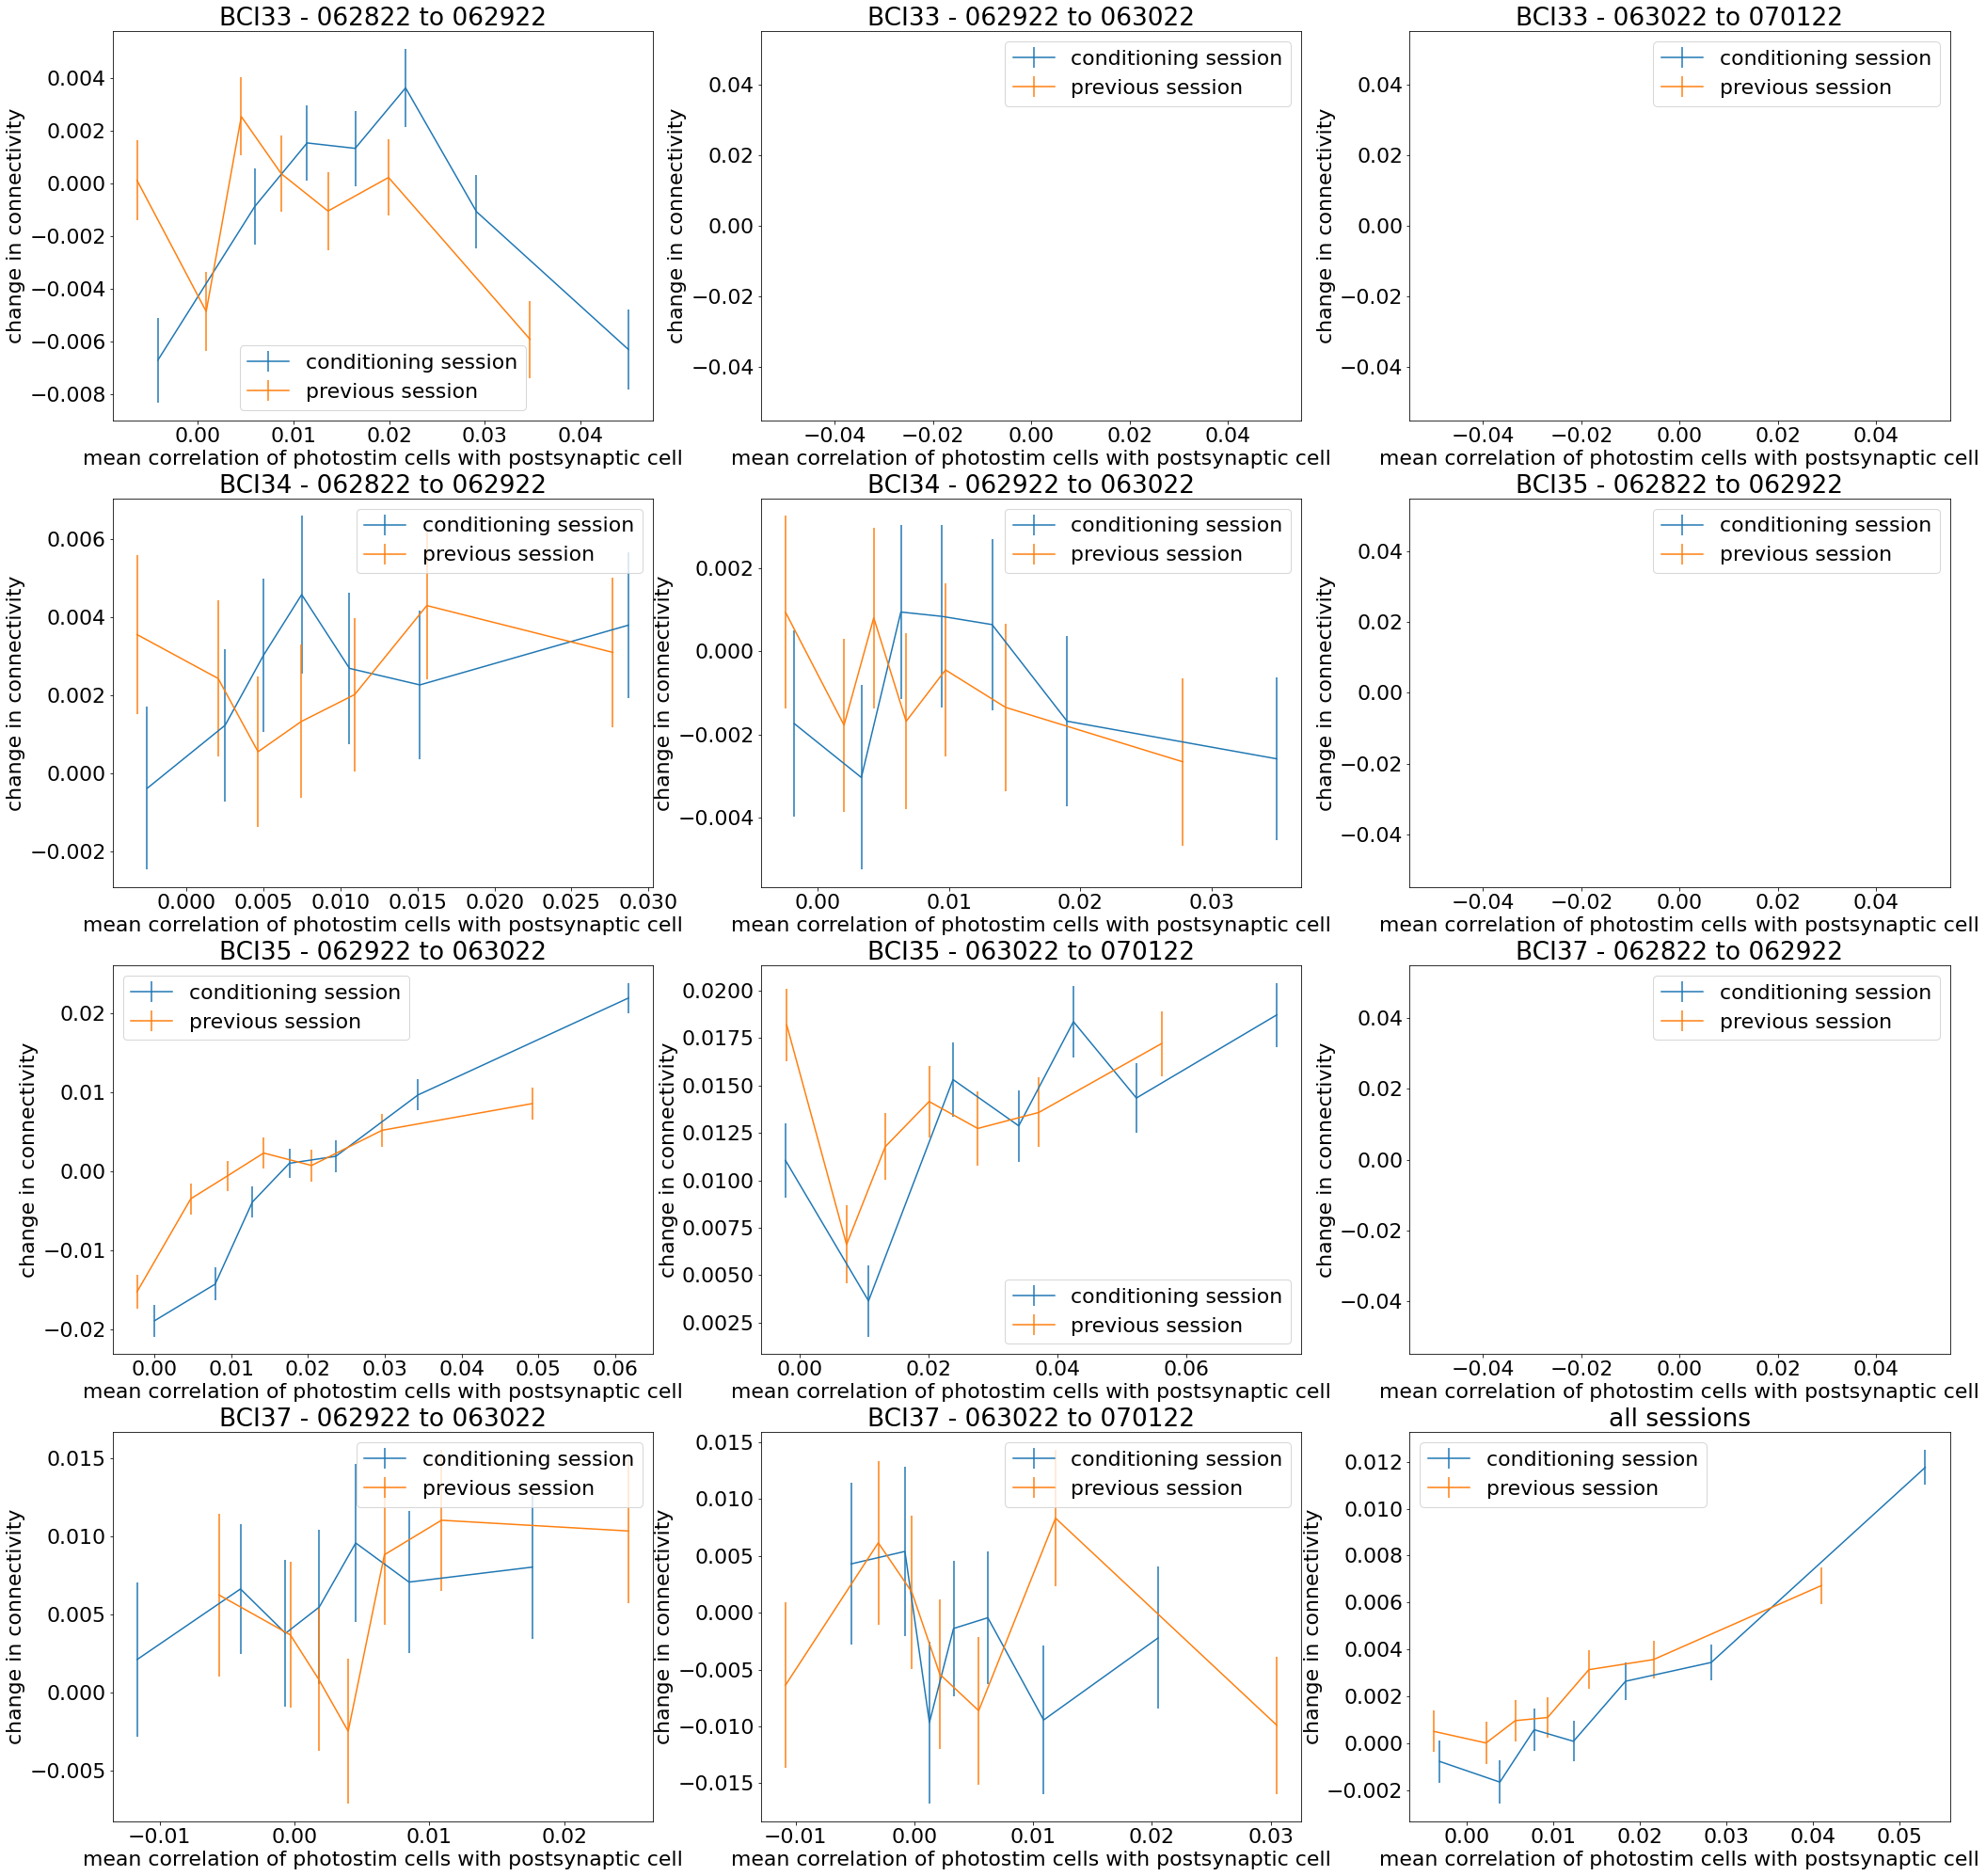

In [63]:
bin_num = 7
xlabel = 'mean correlation of photostim cells with postsynaptic cell'#'direct photostim in cells coactivate during reward'
fig = plt.figure(figsize = [35,35])
#ax = fig.add_subplot(1,1,1)


for i,(x_list,y_list_,x_list_yesterday,title) in enumerate(zip(all_x_lists, all_y_lists,all_x_yesterday_lists,plot_titles_list)):#
    
    # if i == 0:
    #     ax = fig.add_subplot(4,3,i+1)
    # else:
    #     ax = fig.add_subplot(4,3,i+1,sharex = ax,sharey = ax)
    ax = fig.add_subplot(4,3,i+1)
    try:
        todel = x_list==0
        x_list = x_list[todel == False]
        y_list = y_list_[todel == False]

        bin_x = []
        bin_y = []
        bin_y_error = []
        if len(x_list)>0:


            x_sorted = np.sort(x_list)
            x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]


            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list>=x_s)&(x_list<=x_e)
                n = sum(needed_indices)
                bin_x.append(np.nanmean(x_list[needed_indices]))
                bin_y.append(np.nanmean(y_list[needed_indices]))
                bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
        # plt.plot(x_list,y_list,'k.',alpha = .1)


        todel = x_list_yesterday==0
        x_list_yesterday = x_list_yesterday[todel == False]
        y_list = y_list_[todel == False]

        bin_x_yesterday = []
        bin_y_yesterday = []
        bin_y_error_yesterday = []
        if len(x_list_yesterday)>0:
            x_sorted = np.sort(x_list_yesterday)
            x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
            x_ends = x_starts[1:]
            x_starts = x_starts[:-1]

            for x_s,x_e in zip(x_starts,x_ends):
                needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
                n = sum(needed_indices)
                bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
                bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
                bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


        # plt.xlim(np.percentile(x_list,[1,99]))

        ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
        ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('change in connectivity')
        ax.set_title(title)
        ax.legend()
    except:
        pass
#fig = plt.figure()
ax = fig.add_subplot(4,3,i+2)#,sharex = ax,sharey = ax)
x_list = np.concatenate(all_x_lists)#all_x_lists
y_list_= np.concatenate(all_y_lists)#all_y_lists
x_list_yesterday= np.concatenate(all_x_yesterday_lists)#np.concatenate(all_x_yesterday_lists)
title = 'all sessions'

todel = x_list==0
x_list = x_list[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list)
x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

bin_x = []
bin_y = []
bin_y_error = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list>=x_s)&(x_list<=x_e)
    n = sum(needed_indices)
    bin_x.append(np.nanmean(x_list[needed_indices]))
    bin_y.append(np.nanmean(y_list[needed_indices]))
    bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
# plt.plot(x_list,y_list,'k.',alpha = .1)


todel = x_list_yesterday==0
x_list_yesterday = x_list_yesterday[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list_yesterday)
x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]
bin_x_yesterday = []
bin_y_yesterday = []
bin_y_error_yesterday = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
    n = sum(needed_indices)
    bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
    bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
    bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


# plt.xlim(np.percentile(x_list,[1,99]))
ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel('change in connectivity')
ax.set_title(title)

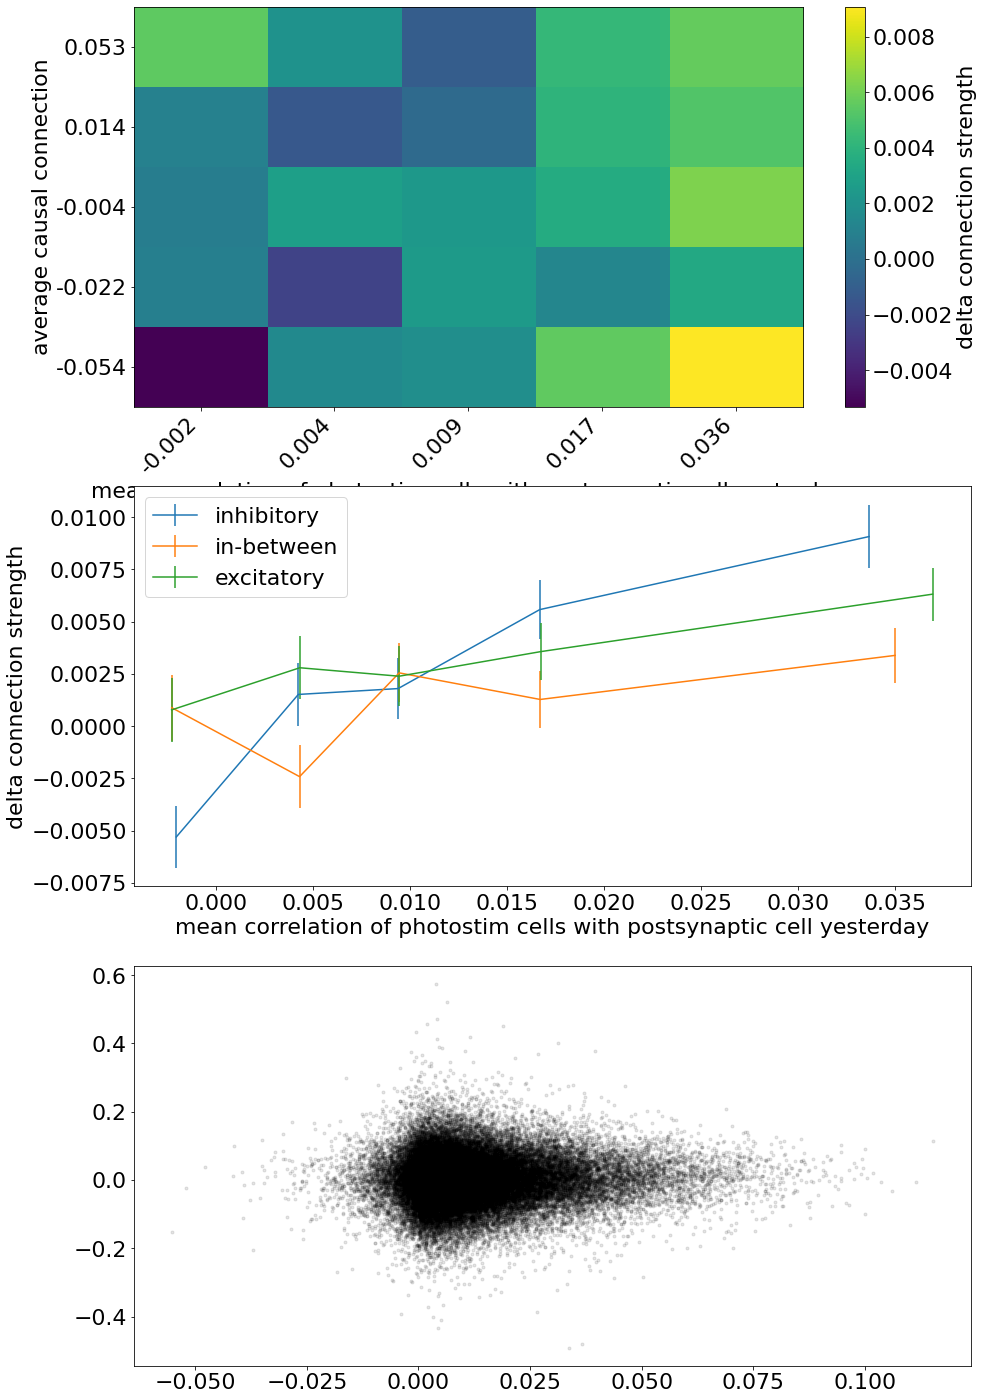

In [64]:
bin_num_x= 5
bin_num_y= 5
subtract_median = False


x_list_all =np.concatenate(all_x_yesterday_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean correlation of photostim cells with postsynaptic cell yesterday'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all =  np.concatenate(all_y_base_lists)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'average causal connection'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err,l in zip(x_matrix.T,bin_matrix.T,error_matrix.T,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

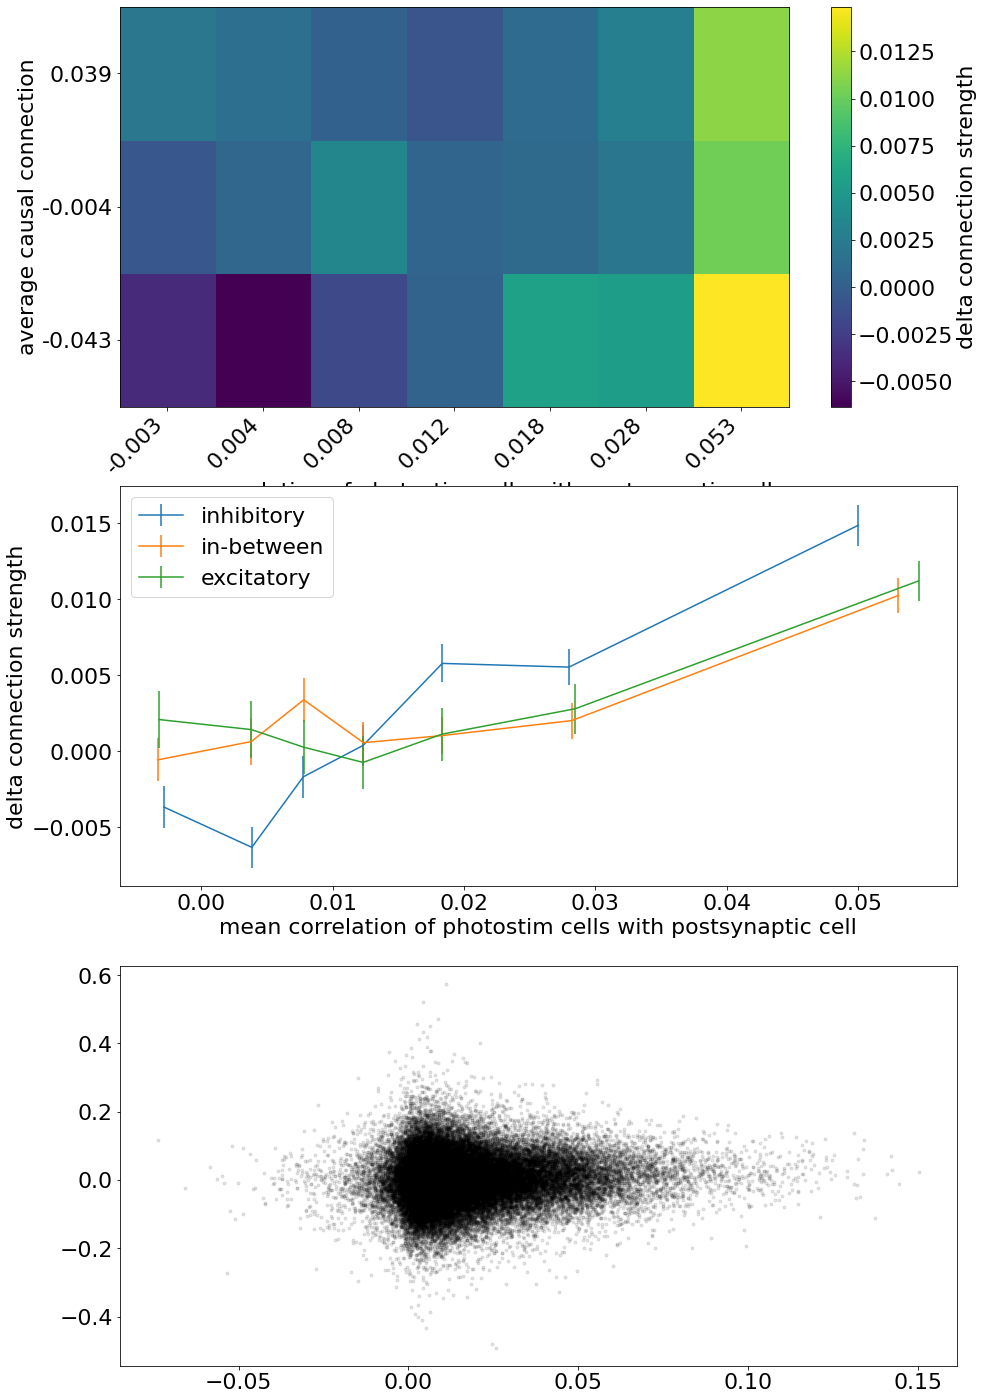

In [65]:
bin_num_x= 7
bin_num_y= 3

x_list_all =np.concatenate(all_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean correlation of photostim cells with postsynaptic cell'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all =  np.concatenate(all_y_base_lists)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'average causal connection'



todel = x_list_all==0
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err,l in zip(x_matrix.T,bin_matrix.T,error_matrix.T,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()


ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

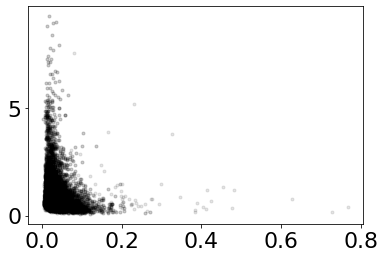

In [784]:
plt.plot(baseline_coactivity_matrix.flatten(),reward_coactivation.flatten(),'k.',alpha = .1)

In [ ]:
#plt.hist(reward_coactivation.flatten()/baseline_coactivity_matrix.flatten(),np.arange(-25,25,.1))
plt.hist(reward_coactivation.flatten(),np.arange(-25,25,.1))
plt.title('reward / baseline')
#plt.hist(reward_coactivation.flatten()-baseline_coactivity_matrix.flatten(),np.arange(-.1,.1,.001))
#plt.title('reward - baseline')

In [ ]:
plt.hist(baseline_coactivity_matrix.flatten(),np.arange(-1,1,.01))
plt.yscale('log')
print('asd')
fig = plt.figure()
plt.hist(reward_coactivation.flatten(),np.arange(-1,1,.01))
plt.yscale('log')
print('asd')

In [66]:
# are reward-correlated cells becoming more connected?

####p_increasing = .01 # post cells are the increasing ones with p<this number
distance_threshold = 30 # for direct photostim
distance_border = 0 # threshold +- this will be ignored..
max_distance = 1000 # for indirect photostim
step_back = 40 #baseline before trial start (in frames)
step_forward = 100 #integration time after trial start (frames)
amplitude_min_std = 3 # for directly photostimmed cells
overlap_min_photostim = .7 # minimum overlap in photostimmed cells
all_pre_amplitudes = []
all_pre_errors = []
baseline_trace_name = 'F'
fraction_of_session_to_use = .3 # from the beginning
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise'] = [] #time x neuron x trial
multi_session_dict['F_trial_start'] = [] #time x neuron x trial

all_x_lists = []
all_x_yesterday_lists = []
all_y_lists = []
all_y_base_lists = []
all_corr_with_cn_today = []
all_corr_with_prev_cn_yesterday = []
plot_titles_list =[]


all_pre_mean_amplitudes_list = []
all_post_amplitudes_list = []
all_pre_mean_amplitudes_yesterday_list = []
all_post_amplitudes_yesterday_list = []

all_photostim_overlap_list = []
ALL_photostim_overlaps = []
session_blacklist = []#['BCI37 - 062822 to 062922']
all_photostim_direct_cell_num_list = []
all_average_correlation_with_post_cell = []
all_average_correlation_with_post_cell_yesterday = []
for session_i,session in enumerate(multi_session_dict['session']):
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                           multi_session_dict['reward_original'][session_i],
                                                                           max_frames=None,
                                                                           frames_after=80, 
                                                                           frames_before=0,
                                                                           include_next_trial=False)
    
#     F_after_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
#                                                                             multi_session_dict['reward_original'][session_i],
#                                                                             max_frames=None,
#                                                                             frames_after=60, 
#                                                                             frames_before=-40,
#                                                                             include_next_trial=False)
    
#     F_trial_start = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
#                                                                             trial_start_trace,
#                                                                             max_frames=None,
#                                                                             frames_after=20, 
#                                                                             frames_before=0,
#                                                                            include_next_trial=False)
    #F_rewardwise[F_rewardwise<0] = 0
    multi_session_dict['F_trialwise'].append(F_trialwise)
    multi_session_dict['F_rewardwise'].append(F_rewardwise)
    #multi_session_dict['F_trial_start'].append(F_trial_start)
    
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session
            same_fov_sessions = []
            for session_i__ in np.arange(len(multi_session_dict['session'])):
                if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i__].shape[0] and multi_session_dict['mouse'][session_i] == multi_session_dict['mouse'][session_i__]: #there is a previous session
                    same_fov_sessions.append(session_i__)
                    
            session_title = '{} - {} to {}'.format(multi_session_dict['mouse'][session_i],multi_session_dict['session'][session_i-1],multi_session_dict['session'][session_i])
            if session_title in session_blacklist:
                continue
            
            correlations = multi_session_dict['pairwise_correlations_matrix'][session_i]# -  multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            correlations = np.nanmean([correlations,correlations.T],0).squeeze()
            correlations[np.isnan(correlations)] = 0
            
            try:
                correlations_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]# -  multi_session_dict['pairwise_correlations_matrix'][session_i-1]
                correlations_yesterday = np.nanmean([correlations_yesterday,correlations_yesterday.T],0).squeeze()
                correlations_yesterday[np.isnan(correlations_yesterday)] = 0
            except:
                correlations_yesterday = correlations.copy()*np.nan
            
            
            # try:
            #     change_in_correlations_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]# -  multi_session_dict['pairwise_correlations_matrix'][session_i-2]
            #     change_in_correlations_yesterday = np.nanmean([change_in_correlations_yesterday,change_in_correlations_yesterday.T],0).squeeze()
            #     change_in_correlations_yesterday[np.isnan(change_in_correlations_yesterday)] = 0
            # except:
            #     change_in_correlations_yesterday = change_in_correlations*0
                
            
            
            
            
            #reward_matrix = np.nanmean(multi_session_dict['F_rewardwise'][session_i],0).squeeze()
            r_list = []
            for a in multi_session_dict['F_rewardwise'][session_i].T:
                r_list.append(a)
            reward_matrix = np.concatenate(r_list,1)
            
            
            reward_matrix[reward_matrix<0] = 0
            #reward_matrix+=np.nanmin(reward_matrix,axis = 1)[:,np.newaxis]
            reward_coactivation = np.matmul(reward_matrix,reward_matrix.T)/reward_matrix.shape[1]
            baseline_matrix_ = multi_session_dict[baseline_trace_name][session_i].copy()
            baseline_matrix_[baseline_matrix_<0] = 0
            #baseline_matrix_+=np.nanmin(baseline_matrix_,axis = 1)[:,np.newaxis]
            baseline_coactivity_matrix = np.matmul(baseline_matrix_,baseline_matrix_.T)/baseline_matrix_.shape[1]    
            
            reward_coactivation = reward_coactivation/baseline_coactivity_matrix
            #reward_coactivation = reward_coactivation/multi_session_dict['pairwise_correlations_matrix'][session_i]
            reward_coactivation[reward_coactivation<-10] = -10
            reward_coactivation[reward_coactivation>10] = 10
            
            
            
            #reward_matrix_yesterday = np.nanmean(multi_session_dict['F_rewardwise'][session_i-1],0).squeeze()
            r_list = []
            for a in multi_session_dict['F_rewardwise'][session_i-1].T:
                r_list.append(a)
            reward_matrix_yesterday = np.concatenate(r_list,1)
            reward_matrix_yesterday[reward_matrix_yesterday<0] = 0
            #reward_matrix_yesterday+=np.nanmin(reward_matrix_yesterday,axis = 1)[:,np.newaxis]
            reward_coactivation_yesterday = np.matmul(reward_matrix_yesterday,reward_matrix_yesterday.T)/reward_matrix_yesterday.shape[1]
            
            
            baseline_matrix_ = multi_session_dict[baseline_trace_name][session_i-1].copy()
            baseline_matrix_[baseline_matrix_<0] = 0
            #baseline_matrix_+=np.nanmin(baseline_matrix_,axis = 1)[:,np.newaxis]
            baseline_coactivity_matrix_yesterday = np.matmul(baseline_matrix_,baseline_matrix_.T)/baseline_matrix_.shape[1]
            reward_coactivation_yesterday = reward_coactivation_yesterday/baseline_coactivity_matrix_yesterday
            #reward_coactivation_yesterday = reward_coactivation_yesterday/multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            reward_coactivation_yesterday[reward_coactivation_yesterday<-10] = -10
            reward_coactivation_yesterday[reward_coactivation_yesterday>10] = 10
            
            
            
            # r_list = []
            # for a in multi_session_dict['F_rewardwise'][session_i].T:
            #     r_list.append(a)
            # r_list = np.concatenate(r_list,1)
            # reward_coactivation = np.corrcoef(r_list)
            # reward_coactivation = reward_coactivation-multi_session_dict['pairwise_correlations_matrix'][session_i]
            # reward_coactivation = np.nanmean([reward_coactivation,reward_coactivation.T],0)
            # r_list = []
            # for a in multi_session_dict['F_rewardwise'][session_i-1].T:
            #     r_list.append(a)
            # r_list = np.concatenate(r_list,1)
            # reward_coactivation_yesterday = np.corrcoef(r_list)
            # reward_coactivation_yesterday = reward_coactivation_yesterday-multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            # reward_coactivation_yesterday = np.nanmean([reward_coactivation_yesterday,reward_coactivation_yesterday.T],0)

            
            change_in_correlations = reward_coactivation
            change_in_correlations_yesterday = reward_coactivation_yesterday
            
            
            
            if len(multi_session_dict['photostim_amplitude'][session_i])>10 and len(multi_session_dict['photostim_amplitude'][session_i-1])>10:
                x_list = []
                x_list_yesterday = []
                y_list = []
                y_baseline = []
                corr_with_cn_today = []
                corr_with_prev_cn_yesterday = []
                pre_mean_amplitudes_list = []
                post_amplitudes_list = []
                pre_mean_amplitudes_yesterday_list = []
                post_amplitudes_yesterday_list = []
                photostim_overlap_list = []
                photostim_direct_cell_num_list = []
                average_correlation_with_post_cell = []
                average_correlation_with_post_cell_yesterday = []
                amplitude_base = np.nanmean([multi_session_dict['photostim_amplitude'][session_i],multi_session_dict['photostim_amplitude'][session_i-1]],0)
#                 amplitude_base_list = []
#                 for session_i__ in same_fov_sessions:
#                     if len(multi_session_dict['photostim_amplitude'][session_i__])>10:
#                         amplitude_base_list.append(multi_session_dict['photostim_amplitude'][session_i__])
#                     # if session_i__ == session_i:
#                     #     break
#                 amplitude_base = np.nanmean(amplitude_base_list,0)
                
                amplitude_difference = multi_session_dict['photostim_amplitude'][session_i]-multi_session_dict['photostim_amplitude'][session_i-1]
                
                
                amplitude = multi_session_dict['photostim_amplitude'][session_i]
                
                # find threshold for directly stimulated cells
                threshold_list = []
                threshold_list_yesterday = []
                for pre_cell_now in np.arange(len(np.unique(np.asarray(multi_session_dict['photostim_cell'][session_i])))):
                    all_amplitudes =  multi_session_dict['photostim_amplitude'][session_i][(np.asarray(multi_session_dict['photostim_cell'][session_i])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i]>=distance_threshold+distance_border)]
                    threshold = np.nanmedian(all_amplitudes)+np.nanstd(all_amplitudes)*amplitude_min_std
                    threshold_list.append(threshold)

                    all_amplitudes_yesterday =  multi_session_dict['photostim_amplitude'][session_i-1][(np.asarray(multi_session_dict['photostim_cell'][session_i-1])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i-1]>=distance_threshold+distance_border)]
                    threshold = np.nanmedian(all_amplitudes_yesterday)+np.nanstd(all_amplitudes_yesterday)*amplitude_min_std
                    threshold_list_yesterday.append(threshold)
                threshold_list = np.asarray(threshold_list)
                threshold_list_yesterday = np.asarray(threshold_list_yesterday)
                
                photostim_overlap_list = []
                photostim_direct_cell_num = []
                for photostim_group in np.unique(multi_session_dict['photostim_group'][session_i]):
                    pre_cells = np.asarray(multi_session_dict['photostim_cell'][session_i][(multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)],int)-1
                    pre_cell_indices = (multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)
                    pre_amplitudes = multi_session_dict['photostim_amplitude'][session_i][pre_cell_indices] # on second day
                    pre_cells_yesterday = np.asarray(multi_session_dict['photostim_cell'][session_i-1][(multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)],int)-1
                    pre_cell_indices_yesterday = (multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)
                    pre_amplitudes_yesterday = multi_session_dict['photostim_amplitude'][session_i-1][pre_cell_indices_yesterday] # on second day
                    pre_active_cells = pre_amplitudes>threshold_list[pre_cells]

                    pre_active_cells_yesterday = pre_amplitudes_yesterday>threshold_list_yesterday[pre_cells_yesterday]
                    
                    photostimmed_in_both = 0
                    photostimmed_in_one = 0
                    pre_cells_yesterday_ = pre_cells_yesterday.copy()
                    pre_active_cells_yesterday_ = pre_active_cells_yesterday.copy()
                    for pre_cell_now,isactive in zip(pre_cells,pre_active_cells):
                        if pre_cell_now in pre_cells_yesterday_:
                            pre_idx_yesterday = np.where(pre_cell_now == pre_cells_yesterday_)[0][0]
                            isactive_yesterday = pre_active_cells_yesterday_[pre_idx_yesterday]
                            if isactive and isactive_yesterday:
                                photostimmed_in_both += 1
                            elif isactive or isactive_yesterday:
                                photostimmed_in_one+=1
                            needed_indices__ = np.ones(len(pre_cells_yesterday_))==1
                            needed_indices__[pre_idx_yesterday] = False
                            pre_cells_yesterday_ = pre_cells_yesterday_[needed_indices__]
                            pre_active_cells_yesterday_ = pre_active_cells_yesterday_[needed_indices__]
                        else:
                            if isactive:
                                photostimmed_in_one+=1

                    for pre_cell_now,isactive in zip(pre_cells_yesterday_,pre_active_cells_yesterday_):
                        if isactive:
                            photostimmed_in_one+=1
                    try:
                        photostim_overlap = photostimmed_in_both/(photostimmed_in_one+photostimmed_in_both)     
                    except:
                        photostim_overlap = 0
                    photostim_overlap_list.append(photostim_overlap)
                    photostim_direct_cell_num.append(photostimmed_in_both)
                photostim_overlap_list  = np.asarray(photostim_overlap_list)
                photostim_direct_cell_num = np.asarray(photostim_direct_cell_num)
                ALL_photostim_overlaps.append(photostim_overlap_list)
                
                
                for photostim_i in np.arange(len(multi_session_dict['photostim_cell'][session_i])):
                    if multi_session_dict['photostim_distance'][session_i][photostim_i]>=distance_threshold+distance_border and  multi_session_dict['photostim_distance'][session_i][photostim_i]<=max_distance:
                        # if amplitude_base[photostim_i]<0:#(np.abs(amplitude_base[photostim_i])<.2 and np.abs(amplitude[photostim_i])<.2):# or 
                        #     continue
                        
                        post_cell = int(multi_session_dict['photostim_cell'][session_i][photostim_i])-1
                        # if multi_session_dict['p_increase'][session_i][post_cell]>.05:
                        #     continue
                        
                        photostim_group = multi_session_dict['photostim_group'][session_i][photostim_i]
                        pre_cells = np.asarray(multi_session_dict['photostim_cell'][session_i][(multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)],int)-1
                        
                        pre_cell_indices = (multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)
                        pre_amplitudes = multi_session_dict['photostim_amplitude'][session_i][pre_cell_indices] # on second day
                        #pre_amplitude_errors = multi_session_dict['photostim_amplitude_error'][session_i][pre_cell_indices] # on second day
                        
                        pre_cells_yesterday = np.asarray(multi_session_dict['photostim_cell'][session_i-1][(multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)],int)-1
                        pre_cell_indices_yesterday = (multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)
                        pre_amplitudes_yesterday = multi_session_dict['photostim_amplitude'][session_i-1][pre_cell_indices_yesterday] # on second day
                        #pre_amplitude_errors_yesterday = multi_session_dict['photostim_amplitude_error'][session_i-1][pre_cell_indices] # on second day
                        
                        
                        
                        
                        
                        #threshold_list = np.asarray(threshold_list) & np.asarray(threshold_list_yesterday)
                        #mean_pre_amplitudes = np.nanmin([pre_amplitudes,pre_amplitudes_yesterday],0)>np.asarray(threshold_list)# hard coded threshold because photostim amplitude SEM variable seems wrong
                        pre_active_cells = pre_amplitudes>threshold_list[pre_cells]
                        
                        pre_active_cells_yesterday = pre_amplitudes_yesterday>threshold_list_yesterday[pre_cells_yesterday]
                        
                        photostim_overlap = photostim_overlap_list[int(photostim_group-1)]
                        
                        if photostim_overlap < overlap_min_photostim: # skip if presynaptic activation was different
                            continue
                        photostim_direct_cell_num_list.append(photostim_direct_cell_num[int(photostim_group-1)])
                            
                        #all_pre_amplitudes.append(pre_amplitudes_yesterday)
                        #all_pre_errors.append(pre_amplitude_errors_yesterday)
                        #mean_pre_amplitudes[mean_pre_amplitudes<0] = 0
                        
                        
                        x = np.nanmean(change_in_correlations[post_cell,pre_cells]*pre_active_cells)#pre_active_cells#pre_amplitudes
                        # below: positive amplitude is increasing cell, negative amplitude is non-increasing cell, just like for Kayvon
                        #x = np.sum((multi_session_dict['p_increase'][session_i][pre_cells]<0.05)*mean_pre_amplitudes) - np.sum((multi_session_dict['p_increase'][session_i][pre_cells]>0.1)*mean_pre_amplitudes)
                        
                        x_list.append(x)
                        x = np.nanmean(change_in_correlations_yesterday[post_cell,pre_cells_yesterday]*pre_active_cells_yesterday)#pre_active_cells_yesterday#pre_amplitudes_yesterday
                        x_list_yesterday.append(x)

                        y_list.append(amplitude_difference[photostim_i])##
                        y_baseline.append(amplitude_base[photostim_i])
                        corr_with_cn_today_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i][multi_session_dict['cn'][session_i],post_cell],
                                                        multi_session_dict['pairwise_correlations_matrix'][session_i][post_cell,multi_session_dict['cn'][session_i]]])
                        corr_with_cn_today.append(corr_with_cn_today_)
                        corr_with_prev_cn_yesterday_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i-1][multi_session_dict['cn'][session_i-1],post_cell],
                                                                multi_session_dict['pairwise_correlations_matrix'][session_i-1][post_cell,multi_session_dict['cn'][session_i-1]]])
                        corr_with_prev_cn_yesterday.append(corr_with_prev_cn_yesterday_)
                        
                        
                        
                        
                        
                        pre_mean_amplitudes_list.append(np.nanmean(multi_session_dict['amplitude'][session_i][pre_cells]*pre_active_cells))
                        post_amplitudes_list.append(multi_session_dict['amplitude'][session_i][post_cell])
                        pre_mean_amplitudes_yesterday_list.append(np.nanmean(multi_session_dict['previous_amplitude'][session_i][pre_cells_yesterday]*pre_active_cells_yesterday))
                        post_amplitudes_yesterday_list.append(multi_session_dict['previous_amplitude'][session_i][post_cell])
                        
                        average_correlation_with_post_cell.append(np.nanmean(correlations[post_cell,pre_cells]*pre_active_cells))#pre_amplitudes#pre_active_cells
                        average_correlation_with_post_cell_yesterday.append(np.nanmean(correlations_yesterday[post_cell,pre_cells_yesterday]*pre_active_cells_yesterday))#pre_amplitudes_yesterday#pre_active_cells_yesterday
                        
                        
                
                x_list = np.asarray(x_list)
                x_list_yesterday = np.asarray(x_list_yesterday)
                y_list = np.asarray(y_list)
                corr_with_prev_cn_yesterday = np.asarray(corr_with_prev_cn_yesterday)
                corr_with_cn_today = np.asarray(corr_with_cn_today)
                pre_mean_amplitudes_list =np.asarray(pre_mean_amplitudes_list)
                post_amplitudes_list = np.asarray(post_amplitudes_list)
                pre_mean_amplitudes_yesterday_list = np.asarray(pre_mean_amplitudes_yesterday_list)
                post_amplitudes_yesterday_list = np.asarray(post_amplitudes_yesterday_list)
                average_correlation_with_post_cell = np.asarray(average_correlation_with_post_cell)
                
                
                all_pre_mean_amplitudes_list.append(pre_mean_amplitudes_list)
                all_post_amplitudes_list.append(post_amplitudes_list)
                all_pre_mean_amplitudes_yesterday_list.append(pre_mean_amplitudes_yesterday_list)
                all_post_amplitudes_yesterday_list.append(post_amplitudes_yesterday_list)
                
                all_x_lists.append(x_list)
                all_x_yesterday_lists.append(x_list_yesterday)
                all_y_lists.append(y_list)
                all_y_base_lists.append(y_baseline)
                plot_titles_list.append(session_title)
                
                all_corr_with_cn_today.append(corr_with_cn_today)
                all_corr_with_prev_cn_yesterday.append(corr_with_prev_cn_yesterday)
                
                all_photostim_overlap_list.append(photostim_overlap_list)
                all_photostim_direct_cell_num_list.append(photostim_direct_cell_num_list)
                all_average_correlation_with_post_cell.append(average_correlation_with_post_cell)
                all_average_correlation_with_post_cell_yesterday.append(average_correlation_with_post_cell_yesterday)

/tmp/ipykernel_2902/174698603.py:86: RuntimeWarning: Mean of empty slice
  correlations = np.nanmean([correlations,correlations.T],0).squeeze()
/tmp/ipykernel_2902/174698603.py:91: RuntimeWarning: Mean of empty slice
  correlations_yesterday = np.nanmean([correlations_yesterday,correlations_yesterday.T],0).squeeze()
/tmp/ipykernel_2902/174698603.py:314: RuntimeWarning: All-NaN axis encountered
  corr_with_cn_today_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i][multi_session_dict['cn'][session_i],post_cell],
/tmp/ipykernel_2902/174698603.py:317: RuntimeWarning: All-NaN axis encountered
  corr_with_prev_cn_yesterday_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i-1][multi_session_dict['cn'][session_i-1],post_cell],


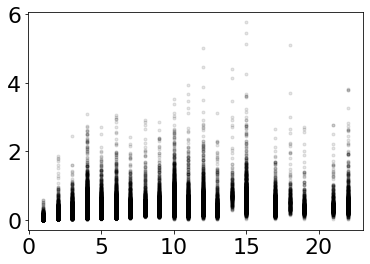

In [67]:
plt.plot(np.concatenate(all_photostim_direct_cell_num_list),np.concatenate(all_x_lists),'k.',alpha = .1)

Text(0.5, 1.0, 'all sessions')

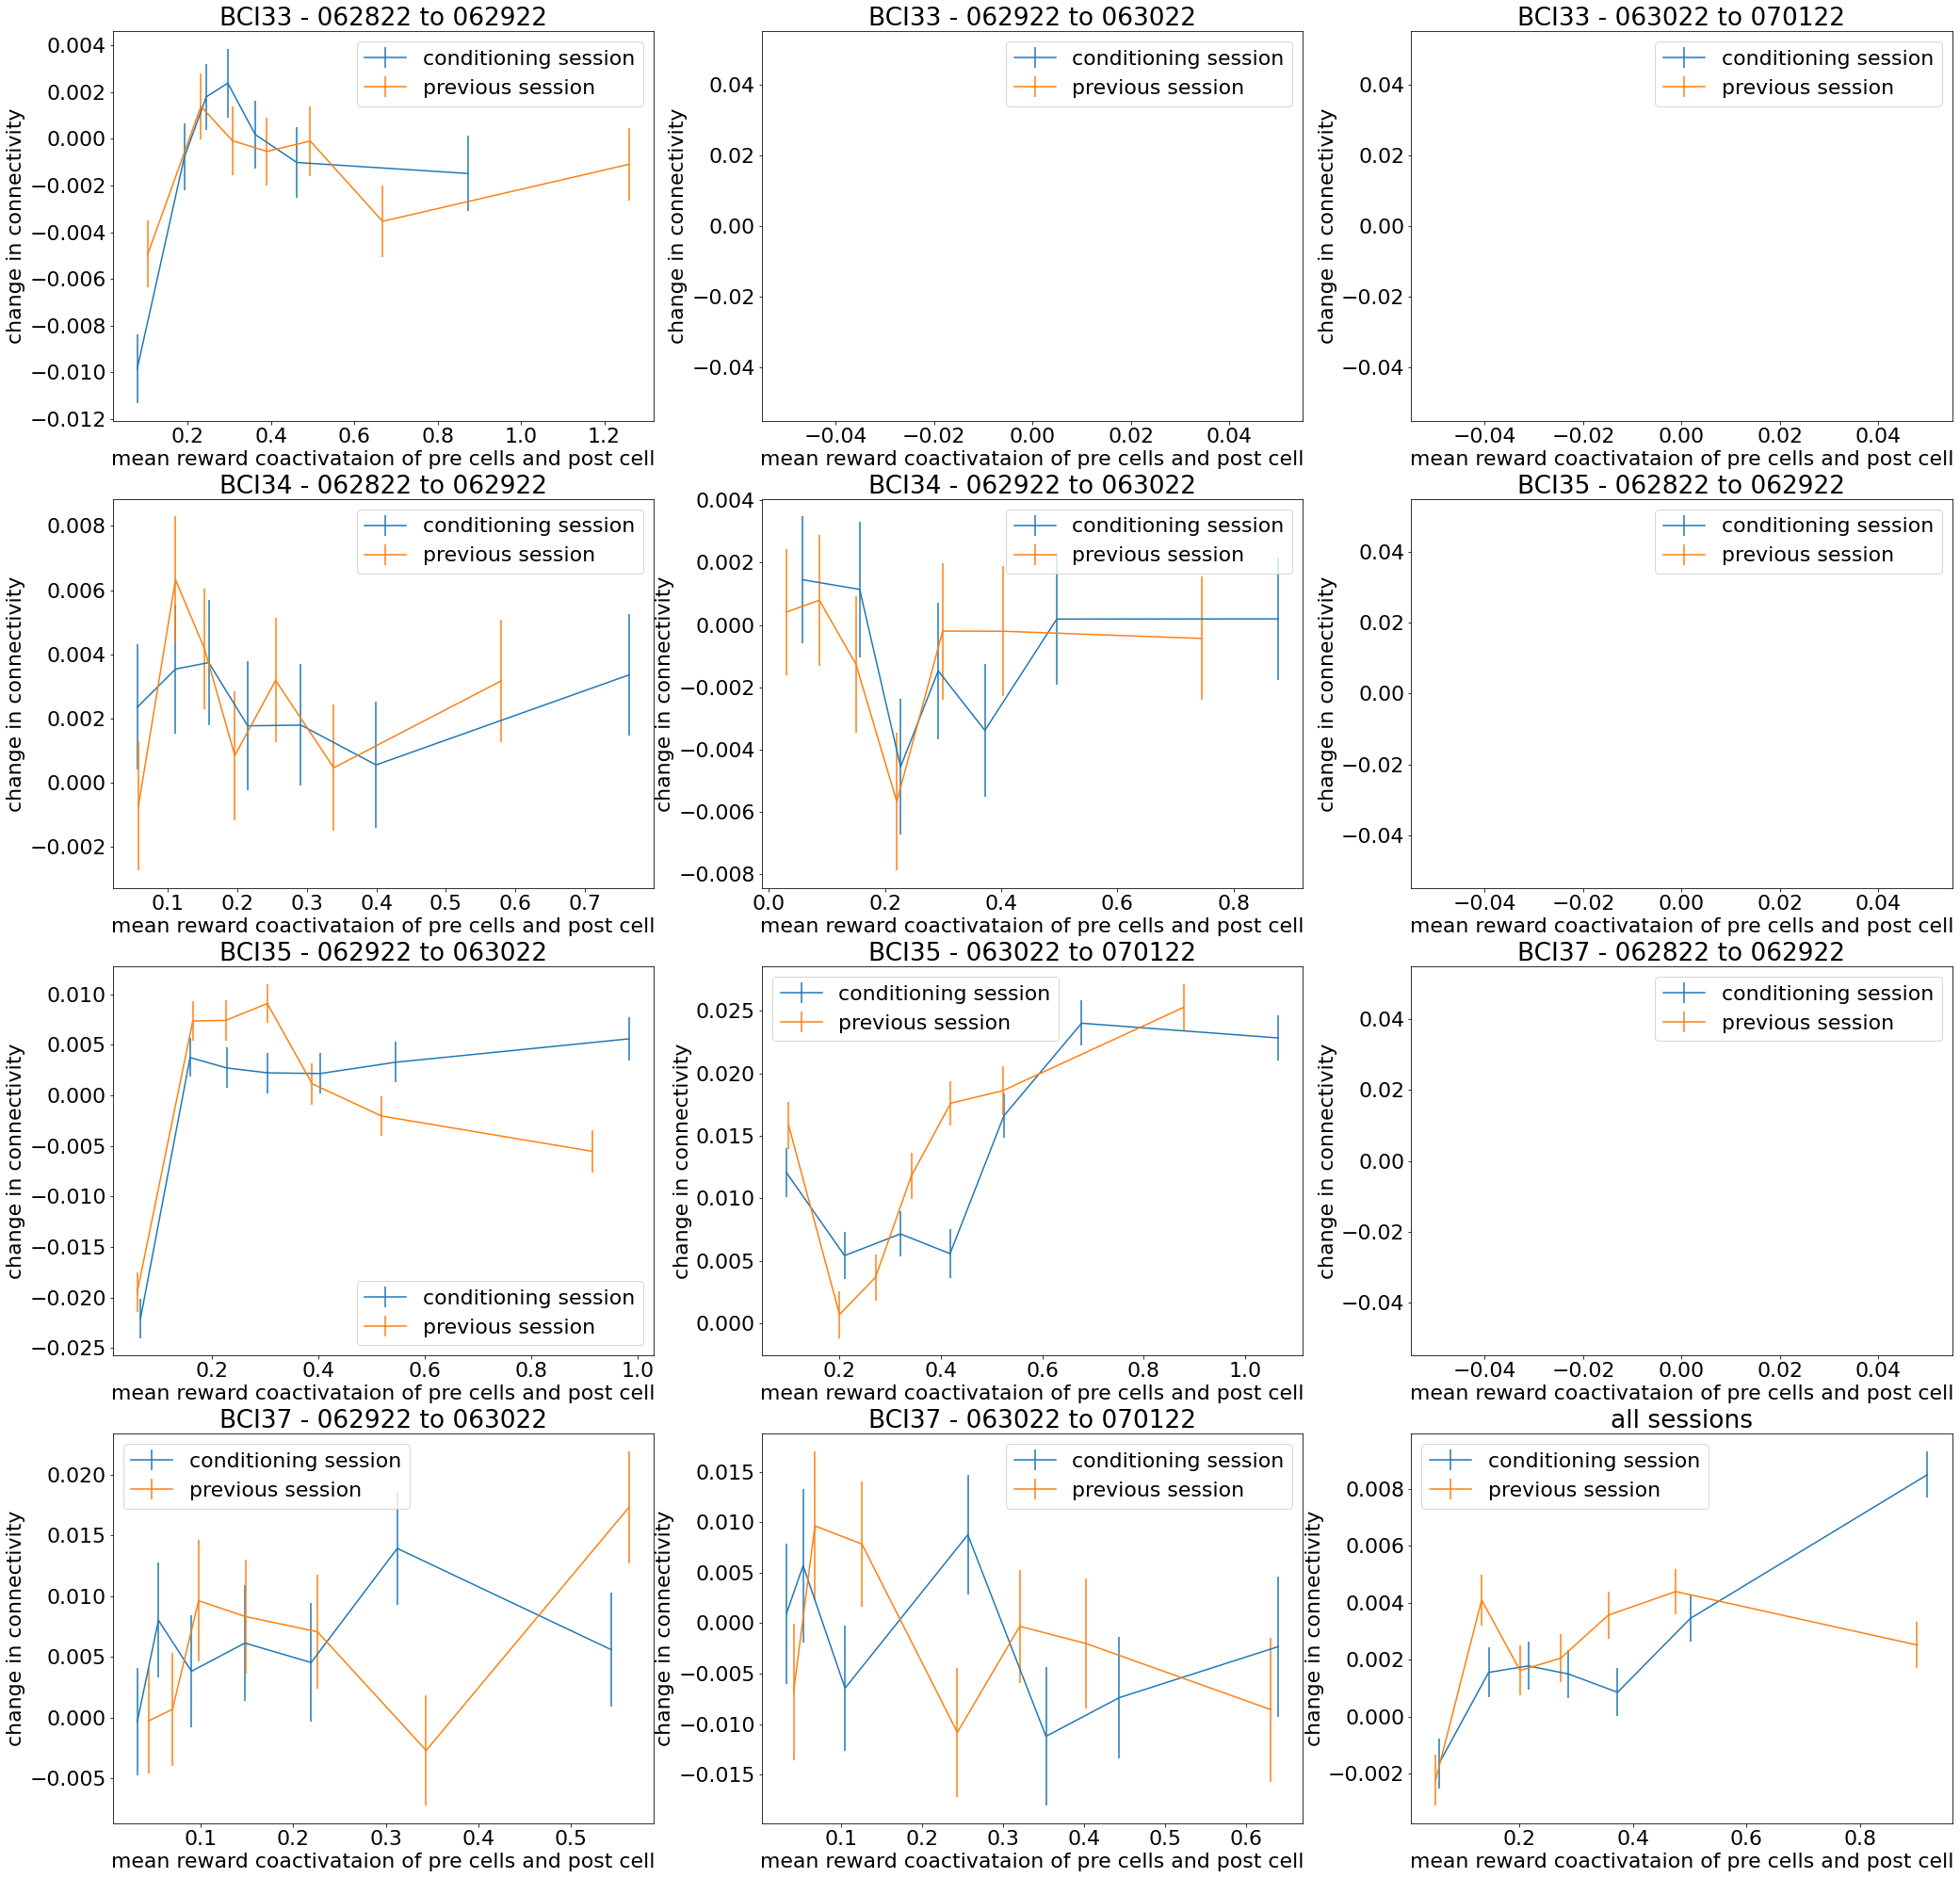

In [68]:
bin_num = 7
xlabel = 'mean reward coactivataion of pre cells and post cell'#'direct photostim in cells coactivate during reward'
fig = plt.figure(figsize = [35,35])
#ax = fig.add_subplot(1,1,1)
for i,(x_list,y_list_,x_list_yesterday,title) in enumerate(zip(all_x_lists,all_y_lists,all_x_yesterday_lists,plot_titles_list)):
    
    # if i == 0:
    #     ax = fig.add_subplot(4,3,i+1)
    # else:
    #     ax = fig.add_subplot(4,3,i+1,sharex = ax,sharey = ax)
    ax = fig.add_subplot(4,3,i+1)
    
    todel = x_list<=0
    x_list = x_list[todel == False]
    y_list = y_list_[todel == False]
    
    bin_x = []
    bin_y = []
    bin_y_error = []
    if len(x_list)>0:
        

        x_sorted = np.sort(x_list)
        x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
        x_ends = x_starts[1:]
        x_starts = x_starts[:-1]


        for x_s,x_e in zip(x_starts,x_ends):
            needed_indices = (x_list>=x_s)&(x_list<=x_e)
            n = sum(needed_indices)
            bin_x.append(np.nanmean(x_list[needed_indices]))
            bin_y.append(np.nanmean(y_list[needed_indices]))
            bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
    # plt.plot(x_list,y_list,'k.',alpha = .1)
    
    
    todel = x_list_yesterday==0
    x_list_yesterday = x_list_yesterday[todel == False]
    y_list = y_list_[todel == False]
    
    bin_x_yesterday = []
    bin_y_yesterday = []
    bin_y_error_yesterday = []
    if len(x_list_yesterday)>0:
        x_sorted = np.sort(x_list_yesterday)
        x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
        x_ends = x_starts[1:]
        x_starts = x_starts[:-1]

        for x_s,x_e in zip(x_starts,x_ends):
            needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
            n = sum(needed_indices)
            bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
            bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
            bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


    # plt.xlim(np.percentile(x_list,[1,99]))

    ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
    ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('change in connectivity')
    ax.set_title(title)
    ax.legend()
#fig = plt.figure()
ax = fig.add_subplot(4,3,i+2)#,sharex = ax,sharey = ax)
x_list = np.concatenate(all_x_lists)
y_list_= np.concatenate(all_y_lists)
x_list_yesterday= np.concatenate(all_x_yesterday_lists)
title = 'all sessions'

todel = x_list==0
x_list = x_list[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list)
x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

bin_x = []
bin_y = []
bin_y_error = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list>=x_s)&(x_list<=x_e)
    n = sum(needed_indices)
    bin_x.append(np.nanmean(x_list[needed_indices]))
    bin_y.append(np.nanmean(y_list[needed_indices]))
    bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
# plt.plot(x_list,y_list,'k.',alpha = .1)


todel = x_list_yesterday==0
x_list_yesterday = x_list_yesterday[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list_yesterday)
x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]
bin_x_yesterday = []
bin_y_yesterday = []
bin_y_error_yesterday = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
    n = sum(needed_indices)
    bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
    bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
    bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


# plt.xlim(np.percentile(x_list,[1,99]))
ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel('change in connectivity')
ax.set_title(title)

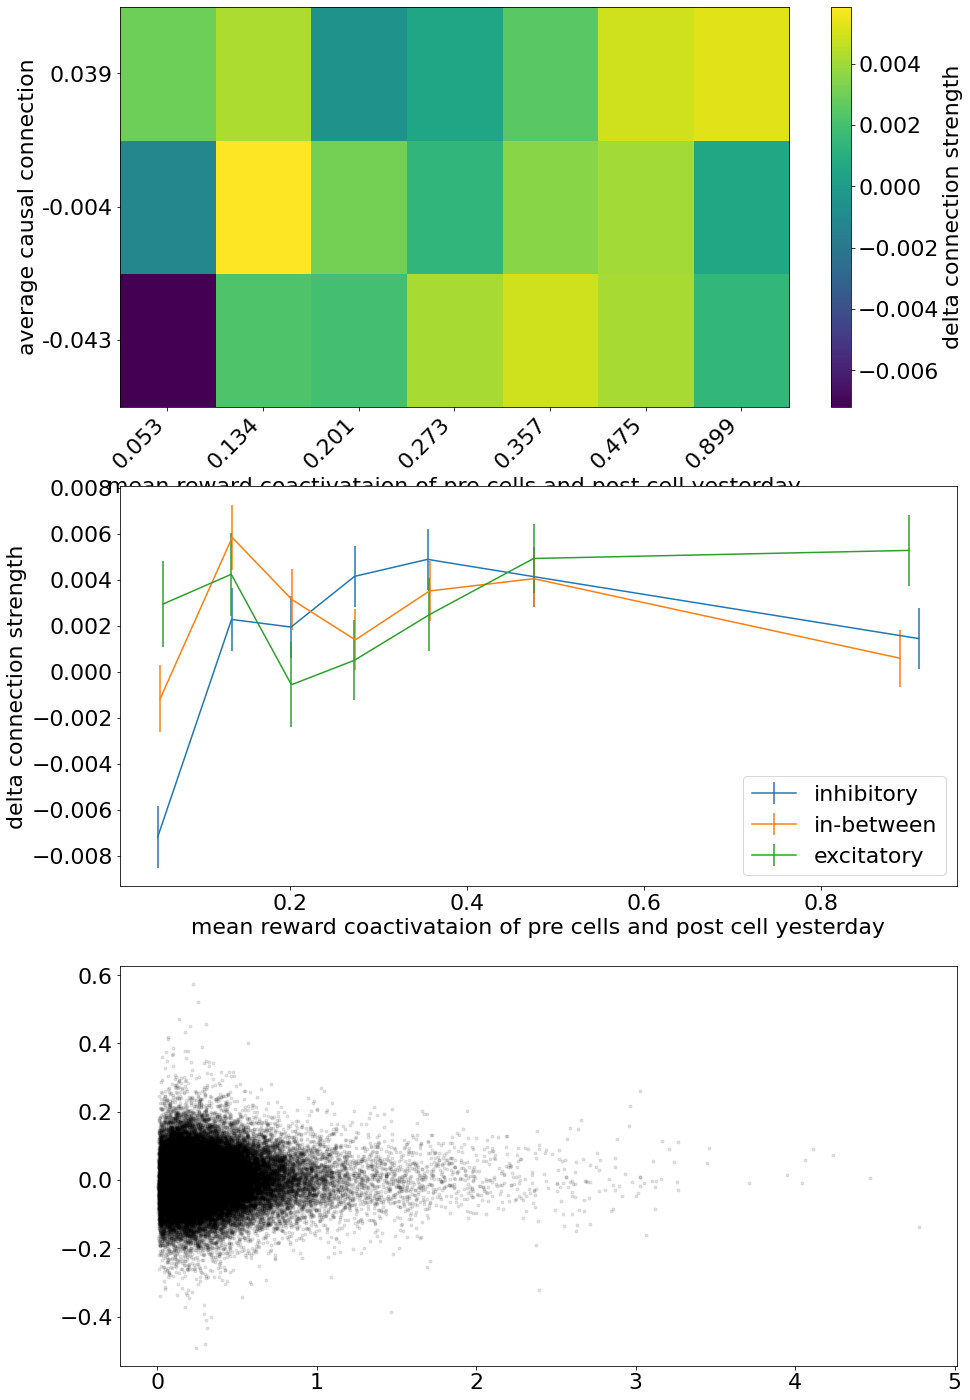

In [69]:
bin_num_x= 7
bin_num_y= 3
subtract_median = False


x_list_all =np.concatenate(all_x_yesterday_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean reward coactivataion of pre cells and post cell yesterday'#'direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all =  np.concatenate(all_y_base_lists)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'average causal connection'



todel = (x_list_all==0) #| (x_list_all>np.percentile(x_list_all,99.9)) |  (x_list_all<np.percentile(x_list_all,.1))
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err,l in zip(x_matrix.T,bin_matrix.T,error_matrix.T,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()

ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

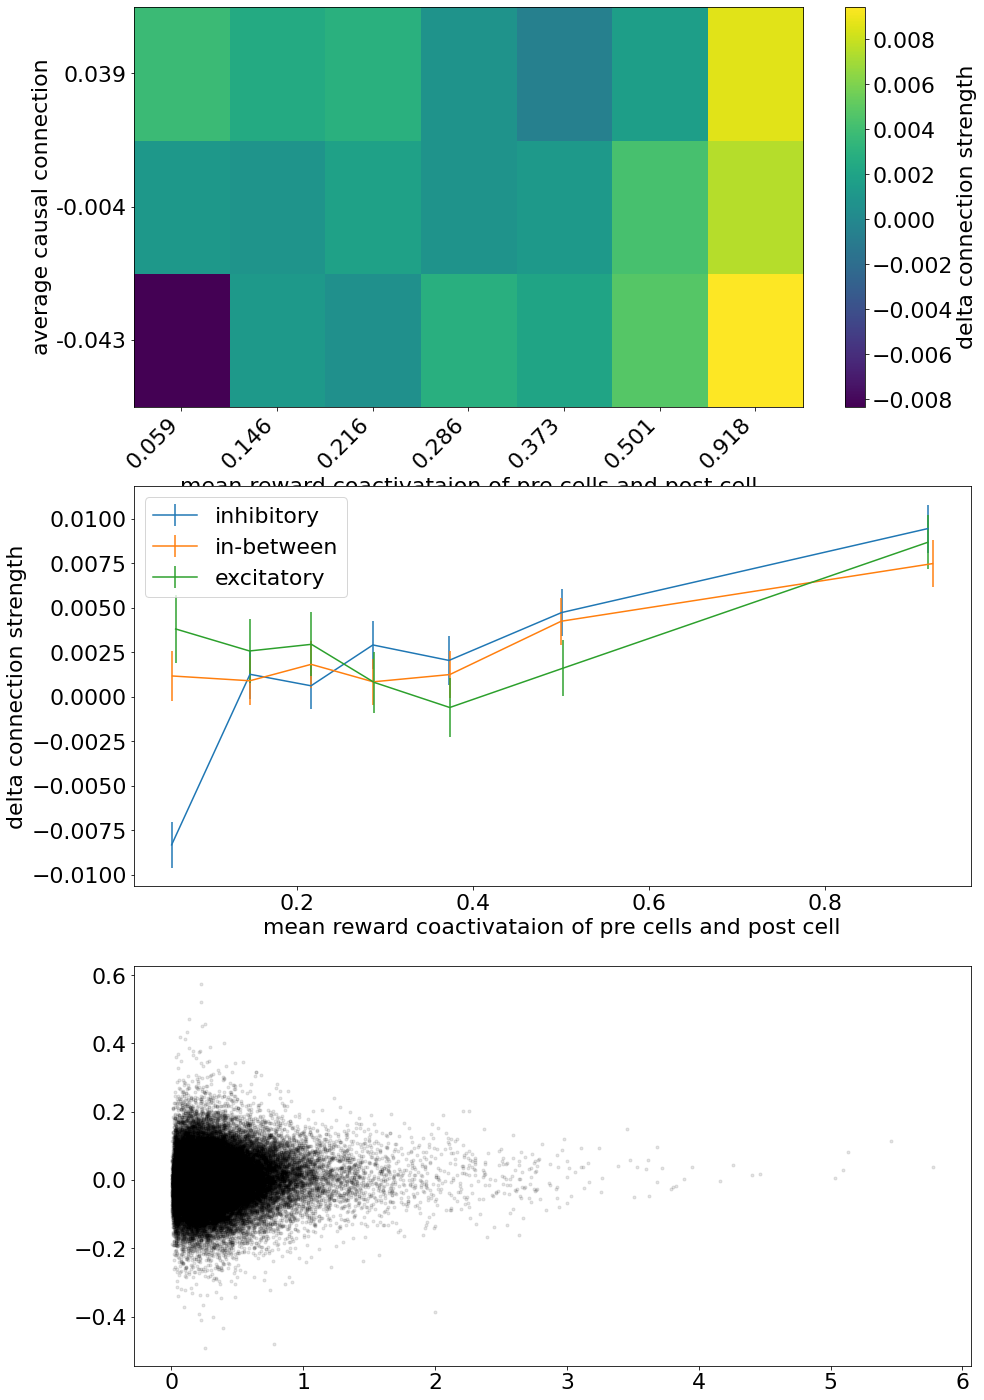

In [70]:
bin_num_x= 7
bin_num_y= 3

x_list_all =np.concatenate(all_x_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean reward coactivataion of pre cells and post cell'#direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all =  np.concatenate(all_y_base_lists)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'average causal connection'



todel = (x_list_all==0)#| (x_list_all>np.percentile(x_list_all,99.1)) |  (x_list_all<np.percentile(x_list_all,.1))
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err,l in zip(x_matrix.T,bin_matrix.T,error_matrix.T,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()


ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)

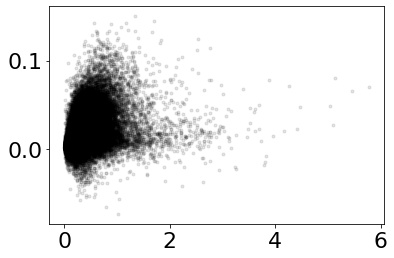

In [71]:
plt.plot(np.concatenate(all_x_lists),np.concatenate(all_average_correlation_with_post_cell),'k.',alpha = .1)
#plt.plot(np.concatenate(all_x_yesterday_lists),np.concatenate(all_average_correlation_with_post_cell_yesterday),'k.',alpha = .1)
#plt.xlim([-.1,.1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


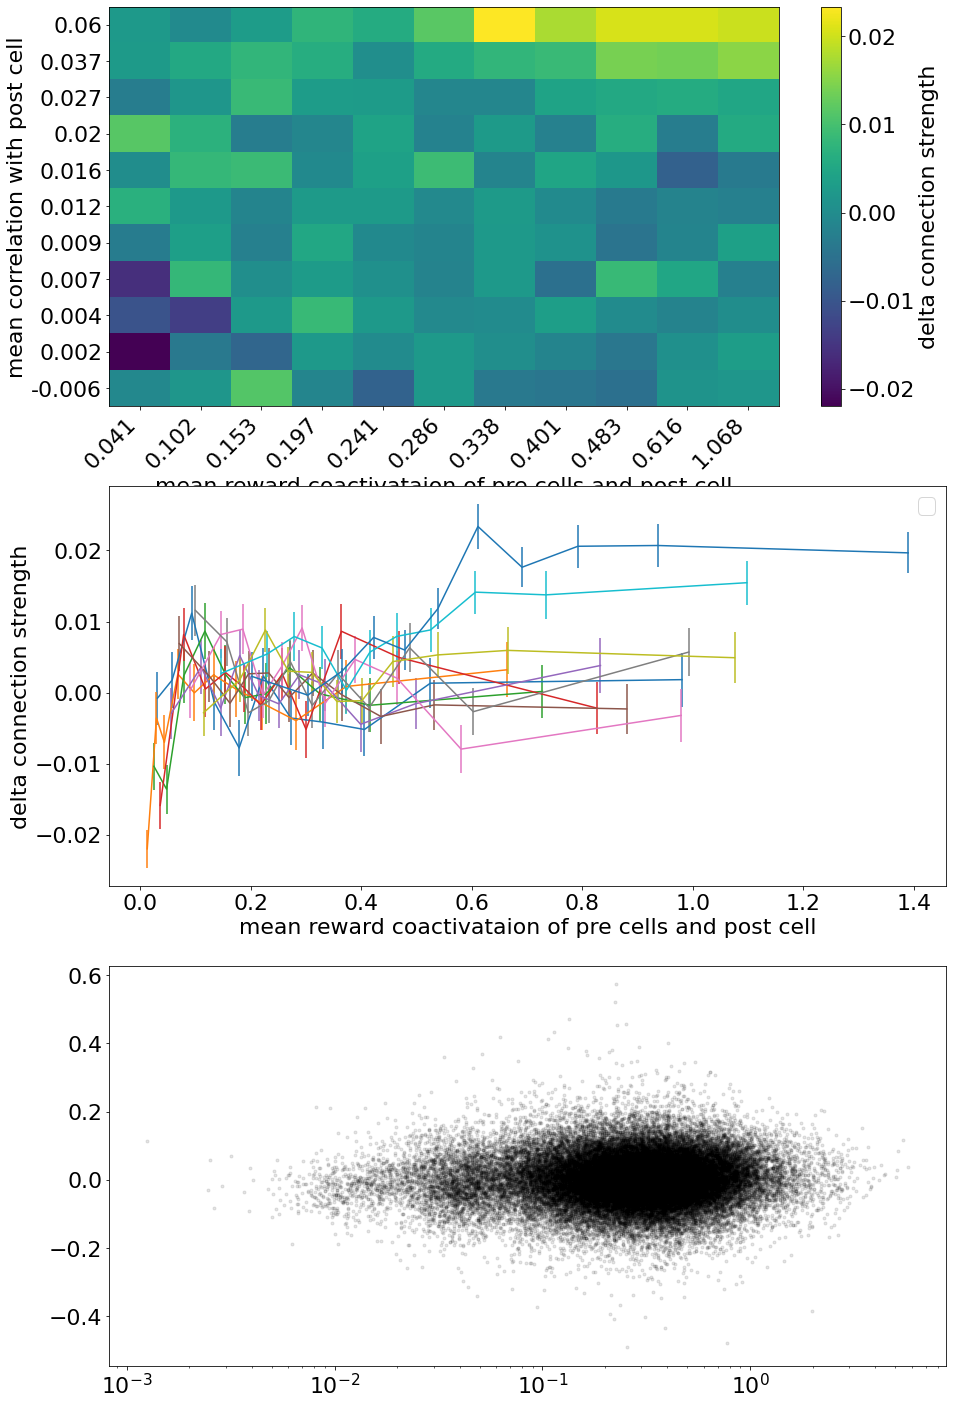

In [72]:
bin_num_x= 11
bin_num_y= 11
#all_x_lists
x_list_all =np.concatenate(all_x_lists)## np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean reward coactivataion of pre cells and post cell'#direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all = np.concatenate(all_average_correlation_with_post_cell)# np.concatenate(all_average_correlation_with_post_cell)#np.concatenate(all_post_amplitudes_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'mean correlation with post cell'#'Trial-locked delta amplitude of post cell'



todel = (x_list_all==0)#| (x_list_all>np.percentile(x_list_all,99.1)) |  (x_list_all<np.percentile(x_list_all,.1))
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
n_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan

for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    x_sorted = np.sort(x_list)

    x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num_x)))-1]
    x_ends = x_starts[1:]
    x_starts = x_starts[:-1]
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)
        n_matrix[xi,yi] = n#len(np.unique(x_list[needed_indices]))
fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()


ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)
ax.set_xscale('log')

In [73]:
n

420

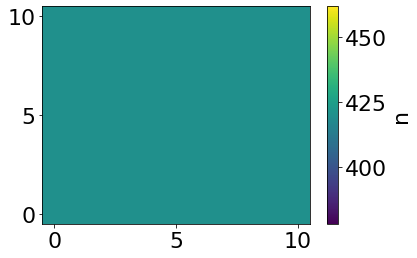

In [74]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(n_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
fig.colorbar(im,ax = ax,label = 'n')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


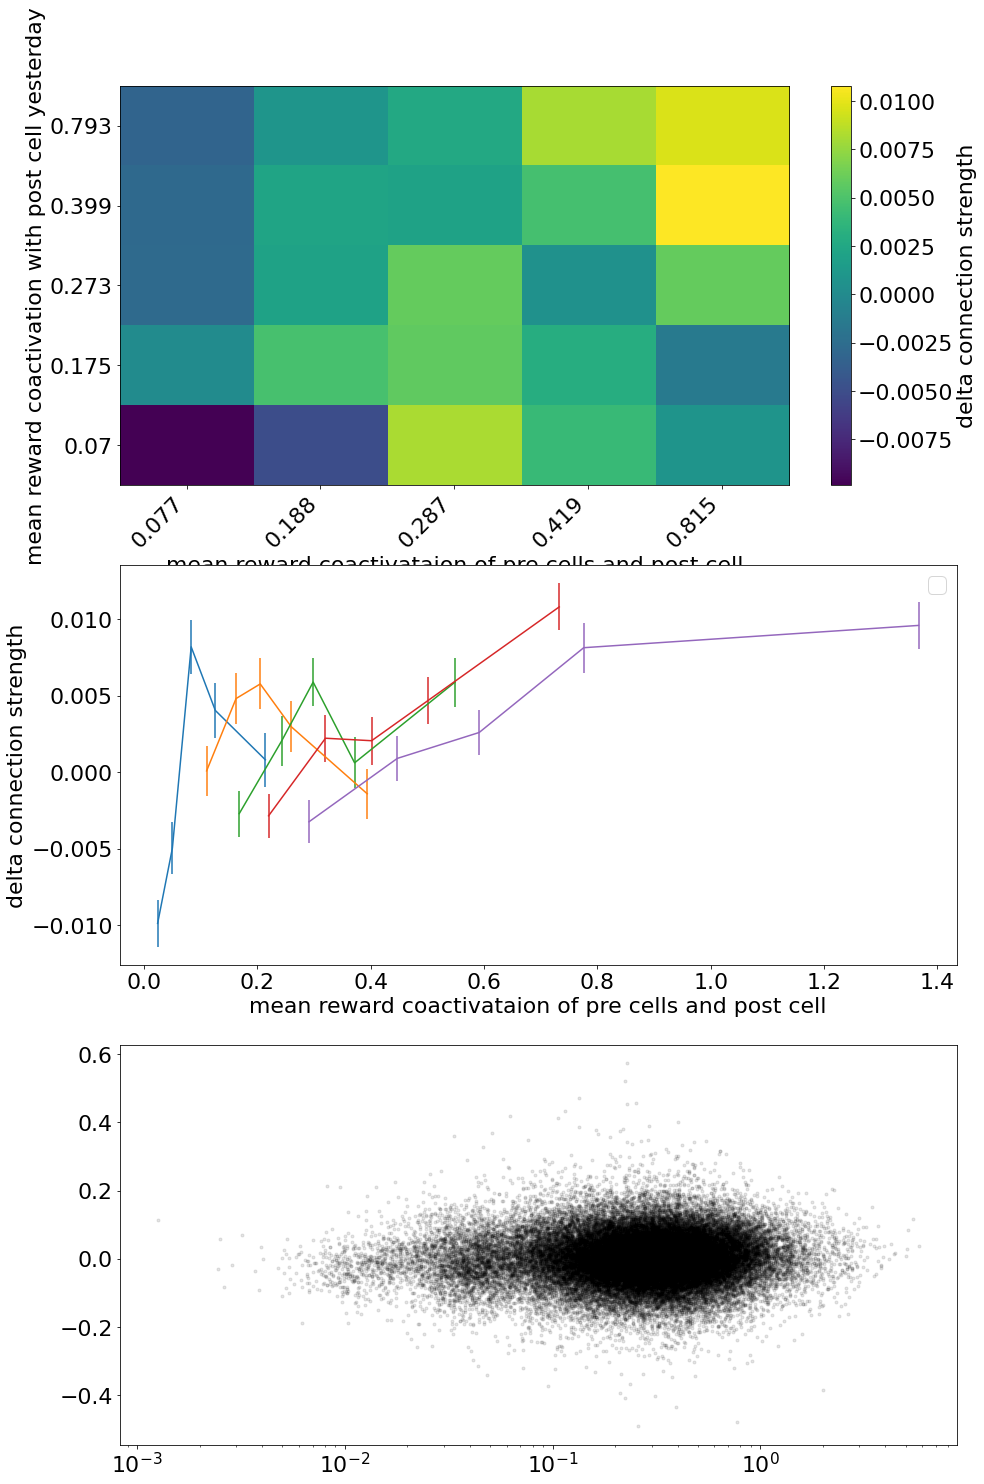

In [75]:
bin_num_x= 5
bin_num_y= 5
#all_x_lists
x_list_all =np.concatenate(all_x_lists)## np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean reward coactivataion of pre cells and post cell'#direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all = np.concatenate(all_x_yesterday_lists)# np.concatenate(all_average_correlation_with_post_cell)#np.concatenate(all_post_amplitudes_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'mean reward coactivation with post cell yesterday'#'Trial-locked delta amplitude of post cell'



todel = (x_list_all==0)#| (x_list_all>np.percentile(x_list_all,99.1)) |  (x_list_all<np.percentile(x_list_all,.1))
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    x_sorted = np.sort(x_list)

    x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num_x)))-1]
    x_ends = x_starts[1:]
    x_starts = x_starts[:-1]
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()


ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)
ax.set_xscale('log')

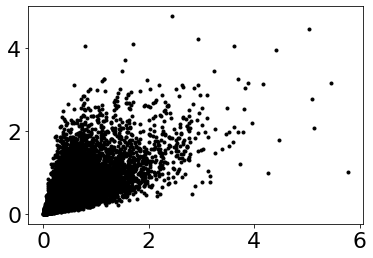

In [76]:
plt.plot(np.concatenate(all_x_lists),np.concatenate(all_x_yesterday_lists),'k.')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


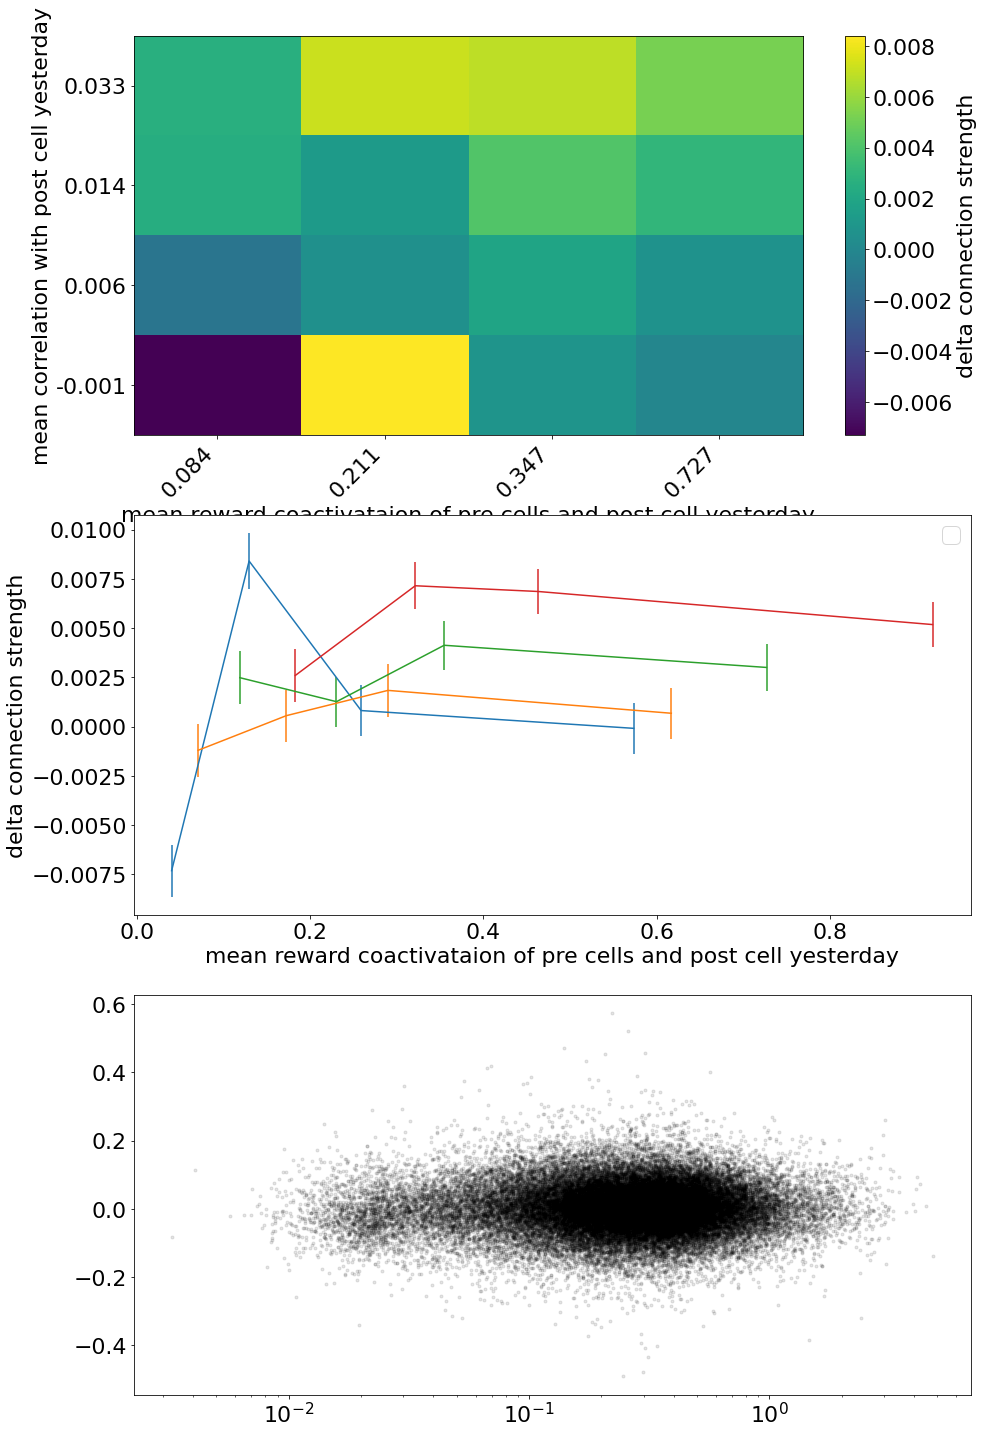

In [77]:
bin_num_x= 4
bin_num_y= 4

x_list_all =np.concatenate(all_x_yesterday_lists)## np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean reward coactivataion of pre cells and post cell yesterday'#direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all = np.concatenate(all_average_correlation_with_post_cell_yesterday)# np.concatenate(all_average_correlation_with_post_cell)#np.concatenate(all_post_amplitudes_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'mean correlation with post cell yesterday'#'Trial-locked delta amplitude of post cell'



todel = (x_list_all==0)#| (x_list_all>np.percentile(x_list_all,99.1)) |  (x_list_all<np.percentile(x_list_all,.1))
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    x_sorted = np.sort(x_list)

    x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num_x)))-1]
    x_ends = x_starts[1:]
    x_starts = x_starts[:-1]
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()


ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)
ax.set_xscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


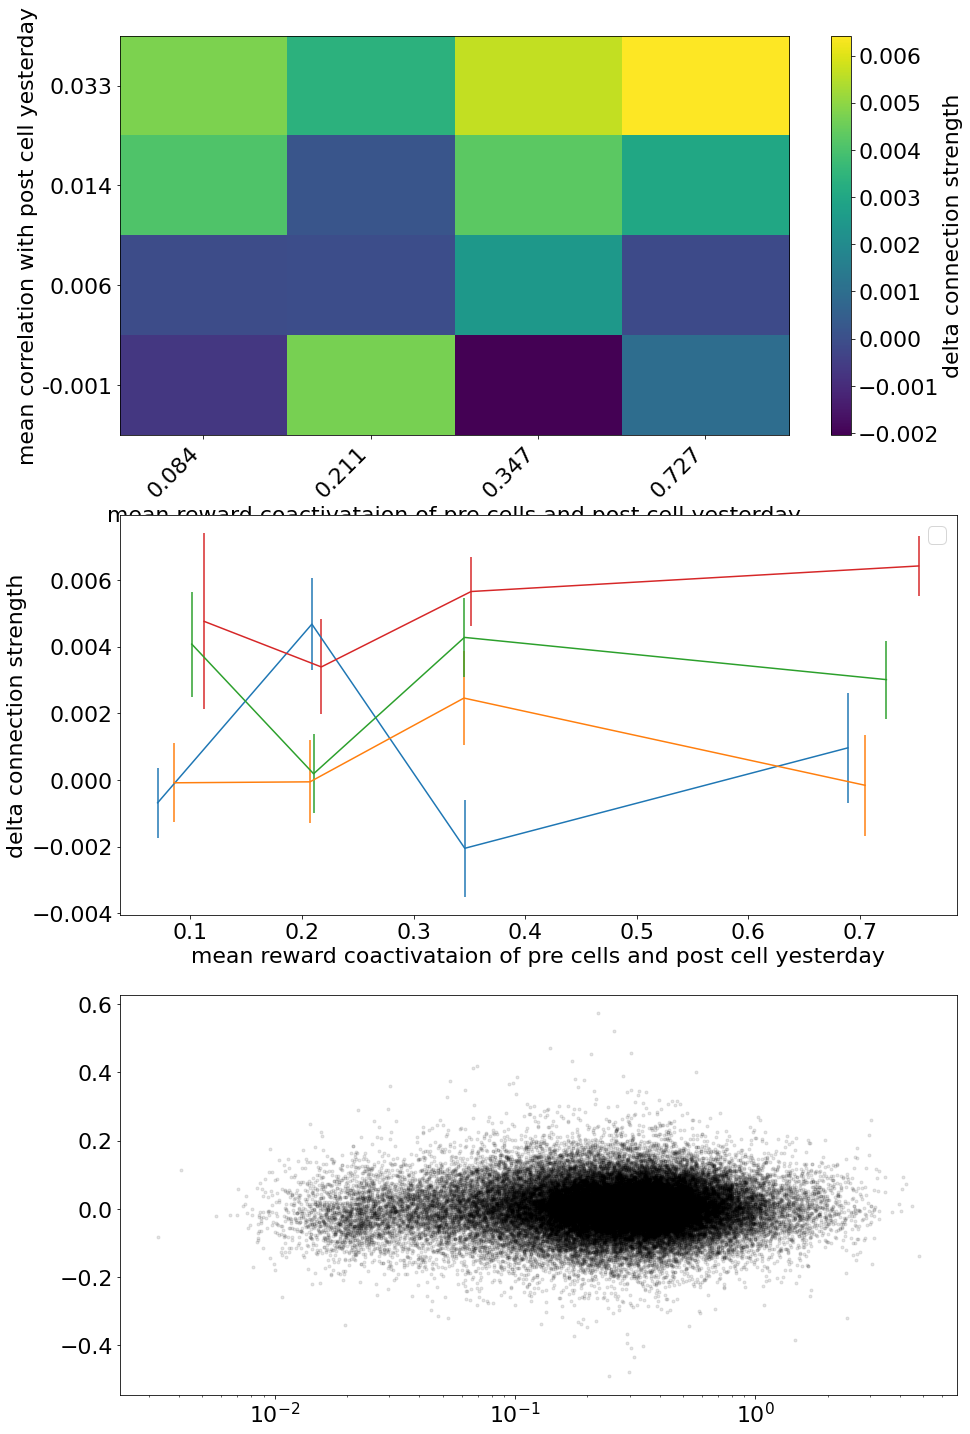

In [78]:
bin_num_x= 4
bin_num_y= 4

x_list_all =np.concatenate(all_x_yesterday_lists)## np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean reward coactivataion of pre cells and post cell yesterday'#direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all = np.concatenate(all_average_correlation_with_post_cell_yesterday)# np.concatenate(all_average_correlation_with_post_cell)#np.concatenate(all_post_amplitudes_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'mean correlation with post cell yesterday'#'Trial-locked delta amplitude of post cell'



todel = (x_list_all==0)#| (x_list_all>np.percentile(x_list_all,99.1)) |  (x_list_all<np.percentile(x_list_all,.1))
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()


ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)
ax.set_xscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


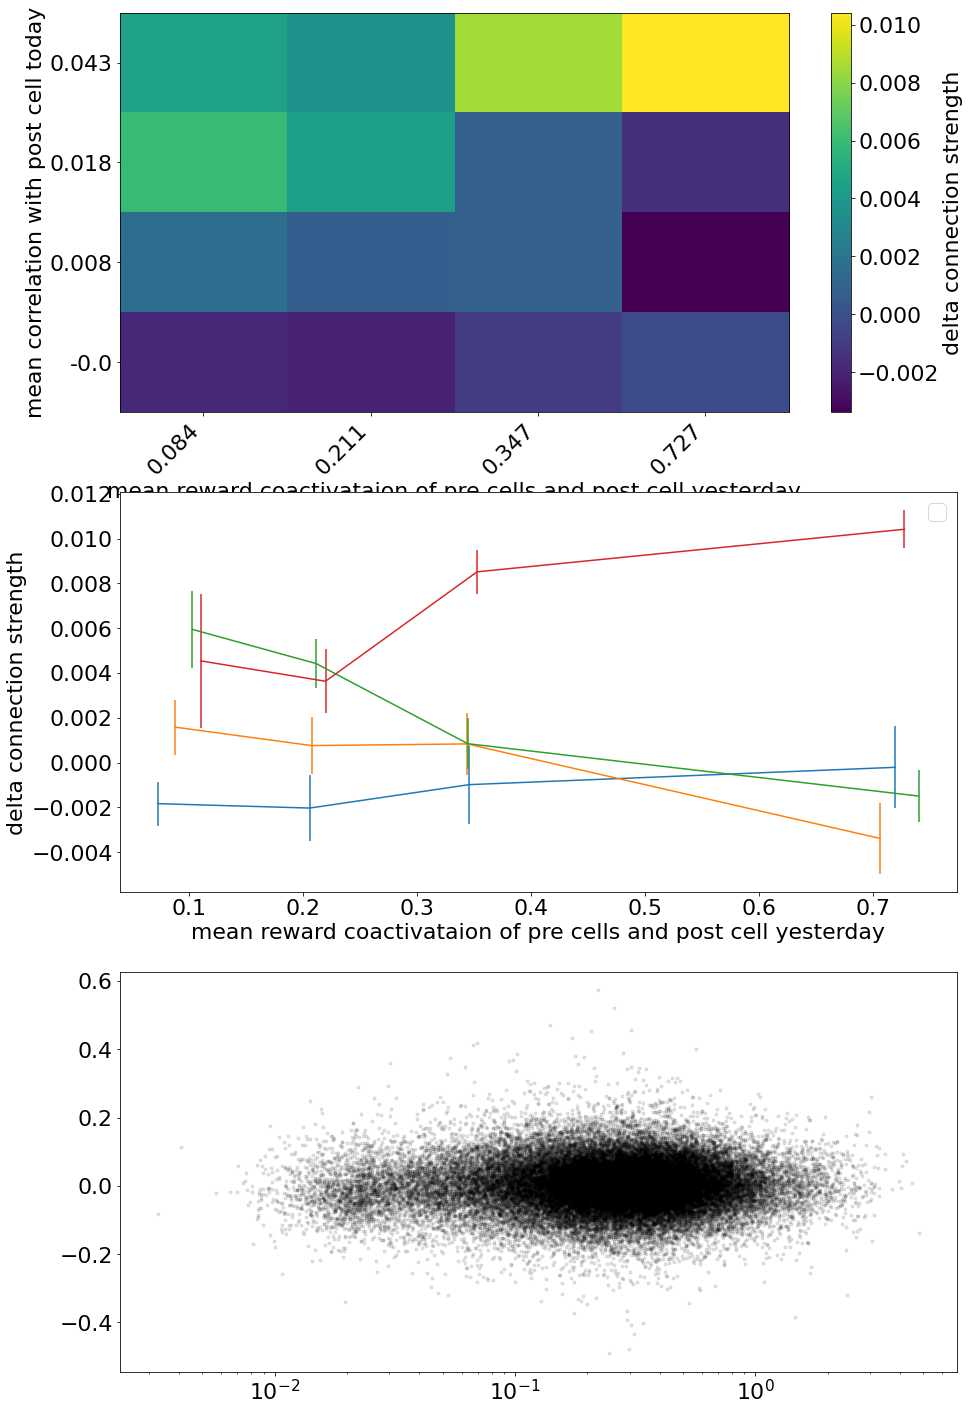

In [79]:
bin_num_x= 4
bin_num_y= 4

x_list_all =np.concatenate(all_x_yesterday_lists)## np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean reward coactivataion of pre cells and post cell yesterday'#direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all = np.concatenate(all_average_correlation_with_post_cell)# np.concatenate(all_average_correlation_with_post_cell)#np.concatenate(all_post_amplitudes_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'mean correlation with post cell today'#'Trial-locked delta amplitude of post cell'



todel = (x_list_all==0)#| (x_list_all>np.percentile(x_list_all,99.1)) |  (x_list_all<np.percentile(x_list_all,.1))
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()


ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)
ax.set_xscale('log')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


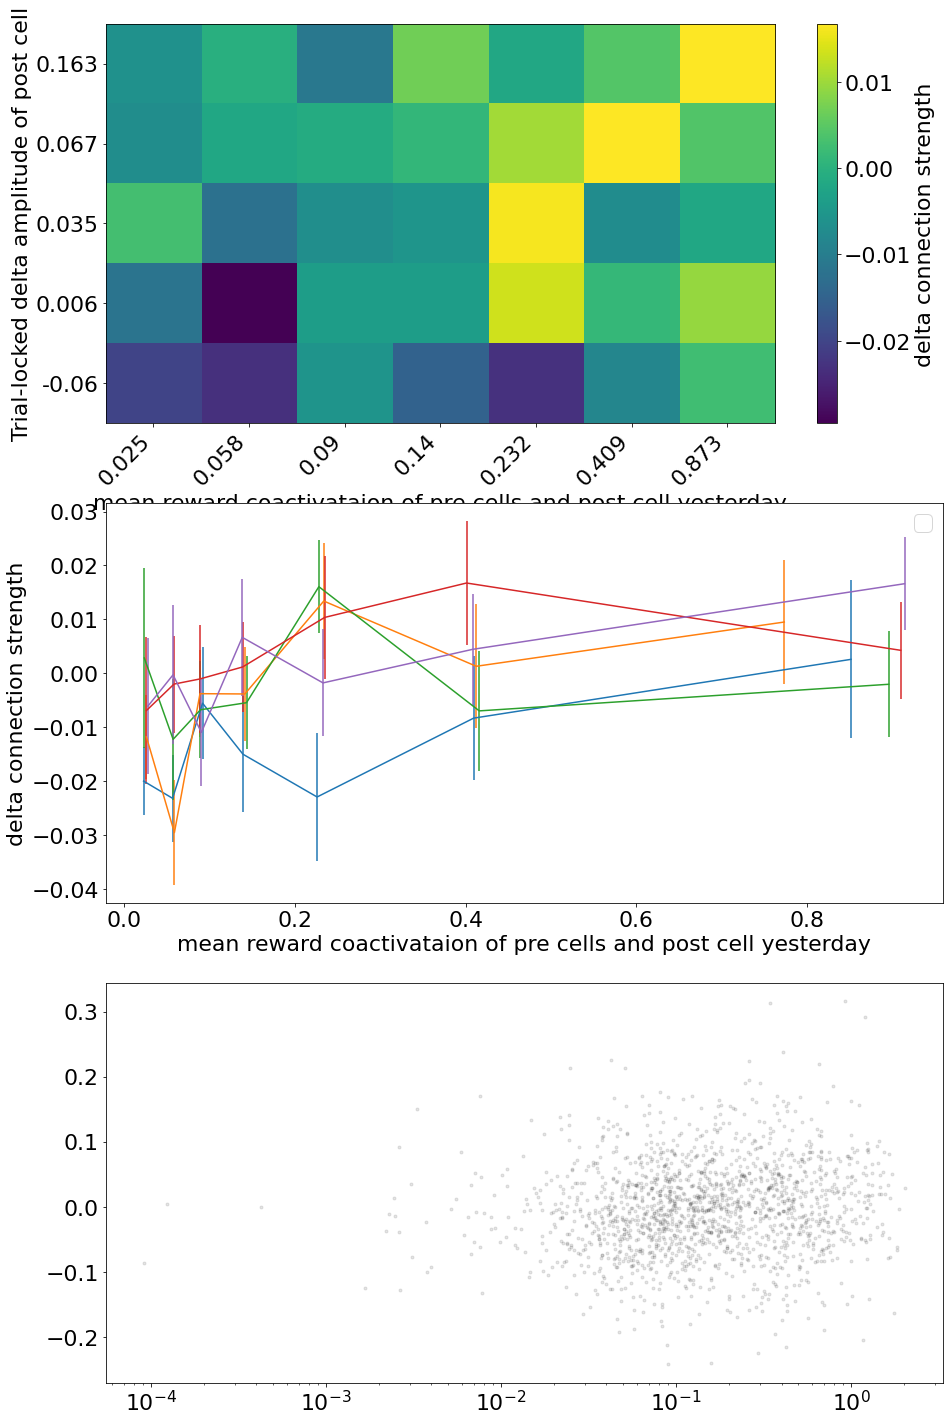

In [1801]:
bin_num_x= 7
bin_num_y= 5

x_list_all =np.concatenate(all_x_yesterday_lists)# np.concatenate(all_pre_mean_amplitudes_list)-np.concatenate(all_pre_mean_amplitudes_yesterday_list)#all_x_lists#all_pre_mean_amplitudes_list#all_x_yesterday_lists
xlabel = 'mean reward coactivataion of pre cells and post cell yesterday'#direct photostim in cells coactivate during reward'
y_list_all= np.concatenate(all_y_lists)
y_base_list_all =  np.concatenate(all_post_amplitudes_list)# np.concatenate(all_post_amplitudes_list)- np.concatenate(all_post_amplitudes_yesterday_list)#np.concatenate(all_corr_with_cn_today)# all_corr_with_cn_today # all_corr_with_prev_cn_yesterday #all_y_base_lists np.concatenate(all_post_amplitudes_list)-
third_axis_label = 'Trial-locked delta amplitude of post cell'



todel = (x_list_all<=0)#| (x_list_all>np.percentile(x_list_all,99.1)) |  (x_list_all<np.percentile(x_list_all,.1))
x_list_all = x_list_all[todel == False]
y_list_all = y_list_all[todel == False]
y_base_list_all = y_base_list_all[todel == False]

x_sorted = np.sort(x_list_all)

x_starts = x_sorted[::int(np.floor(len(x_list_all)/(bin_num_x)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

y_base_sorted = np.sort(y_base_list_all)
y_base_sorted = y_base_sorted[np.isnan(y_base_sorted)==False]
y_starts = y_base_sorted[::int(np.floor(len(y_base_sorted)/(bin_num_y)))-1]
y_ends = y_starts[1:]
y_starts = y_starts[:-1]

x_values_plotted = []
for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
    needed_indices = (x_list_all>=x_s)&(x_list_all<=x_e)
    x_values_plotted.append(np.nanmean(x_list_all[needed_indices]))


bin_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
y_base_values= []
x_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
error_matrix = np.zeros([bin_num_x,bin_num_y])*np.nan
for yi,(y_s,y_e) in enumerate(zip(y_starts,y_ends)):
    needed_indices = (y_base_list_all>=y_s)&(y_base_list_all<=y_e)
    y_base_values.append(np.nanmean(y_base_list_all[needed_indices]))
    x_list = x_list_all[needed_indices]
    y_list = y_list_all[needed_indices]
    if subtract_median:
        y_list -= np.nanmedian(y_list)
    for xi,(x_s,x_e) in enumerate(zip(x_starts,x_ends)):
        needed_indices = (x_list>=x_s)&(x_list<=x_e)
        n = sum(needed_indices)
        bin_matrix[xi,yi] = np.nanmean(y_list[needed_indices])
        x_matrix[xi,yi] = np.nanmean(x_list[needed_indices])
        error_matrix[xi,yi] = np.nanstd(y_list[needed_indices])/np.sqrt(n)

fig = plt.figure(figsize = [15,25])
ax = fig.add_subplot(3,1,1)
im = ax.imshow(bin_matrix.T,aspect = 'auto',interpolation = 'none',origin = 'lower')
ax.set_yticks(np.arange(bin_num_y))
ax.set_yticklabels(np.round(y_base_values,3))
ax.set_xticks(np.arange(bin_num_x))
ax.set_xticklabels(np.round(x_values_plotted,3))
ax.set_ylabel(third_axis_label)
ax.set_xlabel(xlabel)
plt.xticks(rotation=45, ha='right')
fig.colorbar(im,ax = ax,label = 'delta connection strength')

ax = fig.add_subplot(3,1,2)
for x,y,err in zip(x_matrix.T,bin_matrix.T,error_matrix.T):#,['inhibitory','in-between','excitatory']):
    ax.errorbar(x,y,err)#,label = l)
ax.set_ylabel('delta connection strength')
ax.set_xlabel(xlabel)
ax.legend()


ax = fig.add_subplot(3,1,3)
ax.plot(x_list_all,y_list_all,'k.',alpha = .1)
ax.set_xscale('log')

In [646]:
# are reward-correlated cells becoming more connected? - connections onto increasing cells

####p_increasing = .01 # post cells are the increasing ones with p<this number
distance_threshold = 25 # for direct photostim
distance_border = 5 # threshold +- this will be ignored..
max_distance = 2500 # for indirect photostim
step_back = 40 #baseline before trial start (in frames)
step_forward = 100 #integration time after trial start (frames)
amplitude_min_std = 3 # for directly photostimmed cells
overlap_min_photostim = .9 # minimum overlap in photostimmed cells
all_pre_amplitudes = []
all_pre_errors = []
baseline_trace_name = 'F'
fraction_of_session_to_use = .3 # from the beginning
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise'] = [] #time x neuron x trial
multi_session_dict['F_trial_start'] = [] #time x neuron x trial

all_x_lists = []
all_x_yesterday_lists = []
all_y_lists = []
all_y_base_lists = []
all_corr_with_cn_today = []
all_corr_with_prev_cn_yesterday = []
plot_titles_list =[]


all_pre_mean_amplitudes_list = []
all_post_amplitudes_list = []
all_pre_mean_amplitudes_yesterday_list = []
all_post_amplitudes_yesterday_list = []

all_photostim_overlap_list = []
ALL_photostim_overlaps = []
session_blacklist = []#['BCI37 - 062822 to 062922']
for session_i,session in enumerate(multi_session_dict['session']):
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                           multi_session_dict['reward_original'][session_i],
                                                                           max_frames=None,
                                                                           frames_after=10, 
                                                                           frames_before=10,
                                                                           include_next_trial=False)
    
#     F_after_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
#                                                                             multi_session_dict['reward_original'][session_i],
#                                                                             max_frames=None,
#                                                                             frames_after=60, 
#                                                                             frames_before=-40,
#                                                                             include_next_trial=False)
    
#     F_trial_start = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
#                                                                             trial_start_trace,
#                                                                             max_frames=None,
#                                                                             frames_after=20, 
#                                                                             frames_before=0,
#                                                                            include_next_trial=False)
    F_rewardwise[F_rewardwise<0] = 0
    multi_session_dict['F_trialwise'].append(F_trialwise)
    multi_session_dict['F_rewardwise'].append(F_rewardwise)
    #multi_session_dict['F_trial_start'].append(F_trial_start)
    
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session
            same_fov_sessions = []
            for session_i__ in np.arange(len(multi_session_dict['session'])):
                if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i__].shape[0] and multi_session_dict['mouse'][session_i] == multi_session_dict['mouse'][session_i__]: #there is a previous session
                    same_fov_sessions.append(session_i__)
                    
            session_title = '{} - {} to {}'.format(multi_session_dict['mouse'][session_i],multi_session_dict['session'][session_i-1],multi_session_dict['session'][session_i])
            if session_title in session_blacklist:
                continue
            
            # change_in_correlations = multi_session_dict['pairwise_correlations_matrix'][session_i]# -  multi_session_dict['pairwise_correlations_matrix'][session_i-1]
            # change_in_correlations = np.nanmean([change_in_correlations,change_in_correlations.T],0).squeeze()
            # change_in_correlations[np.isnan(change_in_correlations)] = 0
            # try:
            #     change_in_correlations_yesterday = multi_session_dict['pairwise_correlations_matrix'][session_i-1]# -  multi_session_dict['pairwise_correlations_matrix'][session_i-2]
            #     change_in_correlations_yesterday = np.nanmean([change_in_correlations_yesterday,change_in_correlations_yesterday.T],0).squeeze()
            #     change_in_correlations_yesterday[np.isnan(change_in_correlations_yesterday)] = 0
            # except:
            #     change_in_correlations_yesterday = change_in_correlations*0
                
            
            
            
            reward_matrix = np.nanmean(multi_session_dict['F_rewardwise'][session_i],0).squeeze()
            reward_coactivation = np.matmul(reward_matrix,reward_matrix.T)/reward_matrix.shape[1]
            baseline_matrix_ = multi_session_dict[baseline_trace_name][session_i].copy()
            baseline_matrix_[baseline_matrix_<0] = 0
            baseline_coactivity_matrix = np.matmul(baseline_matrix_,baseline_matrix_.T)/baseline_matrix_.shape[1]
            
            #reward_coactivation = (reward_coactivation-np.nanmean(reward_coactivation.flatten()))/np.nanstd(reward_coactivation.flatten())
            reward_coactivation = reward_coactivation/baseline_coactivity_matrix

            
            reward_matrix_yesterday = np.nanmean(multi_session_dict['F_rewardwise'][session_i-1],0).squeeze()
            
            reward_coactivation_yesterday = np.matmul(reward_matrix_yesterday,reward_matrix_yesterday.T)/reward_matrix_yesterday.shape[1]
            baseline_matrix_ = multi_session_dict[baseline_trace_name][session_i-1].copy()
            baseline_matrix_[baseline_matrix_<0] = 0
            baseline_coactivity_matrix_yesterday = np.matmul(baseline_matrix_,baseline_matrix_.T)/baseline_matrix_.shape[1]
            #reward_coactivation_yesterday = (reward_coactivation_yesterday-np.nanmean(reward_coactivation_yesterday.flatten()))/np.nanstd(reward_coactivation_yesterday.flatten())
            reward_coactivation_yesterday = reward_coactivation_yesterday/baseline_coactivity_matrix_yesterday
            
            change_in_correlations = reward_coactivation
            change_in_correlations_yesterday = reward_coactivation_yesterday
            
            
            
            if len(multi_session_dict['photostim_amplitude'][session_i])>10 and len(multi_session_dict['photostim_amplitude'][session_i-1])>10:
                x_list = []
                x_list_yesterday = []
                y_list = []
                y_baseline = []
                corr_with_cn_today = []
                corr_with_prev_cn_yesterday = []
                pre_mean_amplitudes_list = []
                post_amplitudes_list = []
                pre_mean_amplitudes_yesterday_list = []
                post_amplitudes_yesterday_list = []
                photostim_overlap_list = []
                
                
                amplitude_base = np.nanmean([multi_session_dict['photostim_amplitude'][session_i],multi_session_dict['photostim_amplitude'][session_i-1]],0)
#                 amplitude_base_list = []
#                 for session_i__ in same_fov_sessions:
#                     if len(multi_session_dict['photostim_amplitude'][session_i__])>10:
#                         amplitude_base_list.append(multi_session_dict['photostim_amplitude'][session_i__])
#                     # if session_i__ == session_i:
#                     #     break
#                 amplitude_base = np.nanmean(amplitude_base_list,0)
                
                amplitude_difference = multi_session_dict['photostim_amplitude'][session_i]-multi_session_dict['photostim_amplitude'][session_i-1]
                
                
                amplitude = multi_session_dict['photostim_amplitude'][session_i]
                
                # find threshold for directly stimulated cells
                threshold_list = []
                threshold_list_yesterday = []
                for pre_cell_now in np.arange(len(np.unique(np.asarray(multi_session_dict['photostim_cell'][session_i])))):
                    all_amplitudes =  multi_session_dict['photostim_amplitude'][session_i][(np.asarray(multi_session_dict['photostim_cell'][session_i])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i]>=distance_threshold+distance_border)]
                    threshold = np.nanmedian(all_amplitudes)+np.nanstd(all_amplitudes)*amplitude_min_std
                    threshold_list.append(threshold)

                    all_amplitudes_yesterday =  multi_session_dict['photostim_amplitude'][session_i-1][(np.asarray(multi_session_dict['photostim_cell'][session_i-1])==pre_cell_now+1)& (multi_session_dict['photostim_distance'][session_i-1]>=distance_threshold+distance_border)]
                    threshold = np.nanmedian(all_amplitudes_yesterday)+np.nanstd(all_amplitudes_yesterday)*amplitude_min_std
                    threshold_list_yesterday.append(threshold)
                threshold_list = np.asarray(threshold_list)
                threshold_list_yesterday = np.asarray(threshold_list_yesterday)
                
                photostim_overlap_list = []
                for photostim_group in np.unique(multi_session_dict['photostim_group'][session_i]):
                    pre_cells = np.asarray(multi_session_dict['photostim_cell'][session_i][(multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)],int)-1
                    pre_cell_indices = (multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)
                    pre_amplitudes = multi_session_dict['photostim_amplitude'][session_i][pre_cell_indices] # on second day
                    pre_cells_yesterday = np.asarray(multi_session_dict['photostim_cell'][session_i-1][(multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)],int)-1
                    pre_cell_indices_yesterday = (multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)
                    pre_amplitudes_yesterday = multi_session_dict['photostim_amplitude'][session_i-1][pre_cell_indices_yesterday] # on second day
                    pre_active_cells = pre_amplitudes>threshold_list[pre_cells]

                    pre_active_cells_yesterday = pre_amplitudes_yesterday>threshold_list_yesterday[pre_cells_yesterday]
                    
                    photostimmed_in_both = 0
                    photostimmed_in_one = 0
                    pre_cells_yesterday_ = pre_cells_yesterday.copy()
                    pre_active_cells_yesterday_ = pre_active_cells_yesterday.copy()
                    for pre_cell_now,isactive in zip(pre_cells,pre_active_cells):
                        if pre_cell_now in pre_cells_yesterday_:
                            pre_idx_yesterday = np.where(pre_cell_now == pre_cells_yesterday_)[0][0]
                            isactive_yesterday = pre_active_cells_yesterday_[pre_idx_yesterday]
                            if isactive and isactive_yesterday:
                                photostimmed_in_both += 1
                            elif isactive or isactive_yesterday:
                                photostimmed_in_one+=1
                            needed_indices__ = np.ones(len(pre_cells_yesterday_))==1
                            needed_indices__[pre_idx_yesterday] = False
                            pre_cells_yesterday_ = pre_cells_yesterday_[needed_indices__]
                            pre_active_cells_yesterday_ = pre_active_cells_yesterday_[needed_indices__]
                        else:
                            if isactive:
                                photostimmed_in_one+=1

                    for pre_cell_now,isactive in zip(pre_cells_yesterday_,pre_active_cells_yesterday_):
                        if isactive:
                            photostimmed_in_one+=1
                    try:
                        photostim_overlap = photostimmed_in_both/(photostimmed_in_one+photostimmed_in_both)     
                    except:
                        photostim_overlap = 0
                    photostim_overlap_list.append(photostim_overlap)
                photostim_overlap_list  = np.asarray(photostim_overlap_list)
                ALL_photostim_overlaps.append(photostim_overlap_list)
                
                
                for photostim_i in np.arange(len(multi_session_dict['photostim_cell'][session_i])):
                    if multi_session_dict['photostim_distance'][session_i][photostim_i]>=distance_threshold+distance_border and  multi_session_dict['photostim_distance'][session_i][photostim_i]<=max_distance:
                        # if amplitude_base[photostim_i]<0:#(np.abs(amplitude_base[photostim_i])<.2 and np.abs(amplitude[photostim_i])<.2):# or 
                        #     continue
                        
                        post_cell = int(multi_session_dict['photostim_cell'][session_i][photostim_i])-1
                        if multi_session_dict['p_increase'][session_i][post_cell]>.05:
                            continue
                        
                        photostim_group = multi_session_dict['photostim_group'][session_i][photostim_i]
                        pre_cells = np.asarray(multi_session_dict['photostim_cell'][session_i][(multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)],int)-1
                        
                        pre_cell_indices = (multi_session_dict['photostim_group'][session_i]==photostim_group) & (multi_session_dict['photostim_distance'][session_i]<distance_threshold-distance_border)
                        pre_amplitudes = multi_session_dict['photostim_amplitude'][session_i][pre_cell_indices] # on second day
                        #pre_amplitude_errors = multi_session_dict['photostim_amplitude_error'][session_i][pre_cell_indices] # on second day
                        
                        pre_cells_yesterday = np.asarray(multi_session_dict['photostim_cell'][session_i-1][(multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)],int)-1
                        pre_cell_indices_yesterday = (multi_session_dict['photostim_group'][session_i-1]==photostim_group) & (multi_session_dict['photostim_distance'][session_i-1]<distance_threshold-distance_border)
                        pre_amplitudes_yesterday = multi_session_dict['photostim_amplitude'][session_i-1][pre_cell_indices_yesterday] # on second day
                        #pre_amplitude_errors_yesterday = multi_session_dict['photostim_amplitude_error'][session_i-1][pre_cell_indices] # on second day
                        
                        
                        
                        
                        
                        #threshold_list = np.asarray(threshold_list) & np.asarray(threshold_list_yesterday)
                        #mean_pre_amplitudes = np.nanmin([pre_amplitudes,pre_amplitudes_yesterday],0)>np.asarray(threshold_list)# hard coded threshold because photostim amplitude SEM variable seems wrong
                        pre_active_cells = pre_amplitudes>threshold_list[pre_cells]
                        
                        pre_active_cells_yesterday = pre_amplitudes_yesterday>threshold_list_yesterday[pre_cells_yesterday]
                        
                        photostim_overlap = photostim_overlap_list[int(photostim_group-1)]
                        
                        if photostim_overlap < overlap_min_photostim: # skip if presynaptic activation was different
                            continue
                            
                        #all_pre_amplitudes.append(pre_amplitudes_yesterday)
                        #all_pre_errors.append(pre_amplitude_errors_yesterday)
                        #mean_pre_amplitudes[mean_pre_amplitudes<0] = 0
                        
                        
                        x = np.nanmean(change_in_correlations[post_cell,pre_cells]*pre_active_cells)
                        # below: positive amplitude is increasing cell, negative amplitude is non-increasing cell, just like for Kayvon
                        #x = np.sum((multi_session_dict['p_increase'][session_i][pre_cells]<0.05)*mean_pre_amplitudes) - np.sum((multi_session_dict['p_increase'][session_i][pre_cells]>0.1)*mean_pre_amplitudes)
                        
                        x_list.append(x)
                        x = np.nanmean(change_in_correlations_yesterday[post_cell,pre_cells_yesterday]*pre_active_cells_yesterday)
                        x_list_yesterday.append(x)

                        y_list.append(amplitude_difference[photostim_i])##
                        y_baseline.append(amplitude_base[photostim_i])
                        corr_with_cn_today_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i][multi_session_dict['cn'][session_i],post_cell],
                                                        multi_session_dict['pairwise_correlations_matrix'][session_i][post_cell,multi_session_dict['cn'][session_i]]])
                        corr_with_cn_today.append(corr_with_cn_today_)
                        corr_with_prev_cn_yesterday_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i-1][multi_session_dict['cn'][session_i-1],post_cell],
                                                                multi_session_dict['pairwise_correlations_matrix'][session_i-1][post_cell,multi_session_dict['cn'][session_i-1]]])
                        corr_with_prev_cn_yesterday.append(corr_with_prev_cn_yesterday_)
                        
                        
                        
                        
                        
                        pre_mean_amplitudes_list.append(np.nanmean(multi_session_dict['amplitude'][session_i][pre_cells]*pre_active_cells))
                        post_amplitudes_list.append(multi_session_dict['amplitude'][session_i][post_cell])
                        pre_mean_amplitudes_yesterday_list.append(np.nanmean(multi_session_dict['previous_amplitude'][session_i][pre_cells_yesterday]*pre_active_cells_yesterday))
                        post_amplitudes_yesterday_list.append(multi_session_dict['previous_amplitude'][session_i][post_cell])

                        
                        
                
                x_list = np.asarray(x_list)
                x_list_yesterday = np.asarray(x_list_yesterday)
                y_list = np.asarray(y_list)
                corr_with_prev_cn_yesterday = np.asarray(corr_with_prev_cn_yesterday)
                corr_with_cn_today = np.asarray(corr_with_cn_today)
                pre_mean_amplitudes_list =np.asarray(pre_mean_amplitudes_list)
                post_amplitudes_list = np.asarray(post_amplitudes_list)
                pre_mean_amplitudes_yesterday_list = np.asarray(pre_mean_amplitudes_yesterday_list)
                post_amplitudes_yesterday_list = np.asarray(post_amplitudes_yesterday_list)

                
                
                all_pre_mean_amplitudes_list.append(pre_mean_amplitudes_list)
                all_post_amplitudes_list.append(post_amplitudes_list)
                all_pre_mean_amplitudes_yesterday_list.append(pre_mean_amplitudes_yesterday_list)
                all_post_amplitudes_yesterday_list.append(post_amplitudes_yesterday_list)
                
                all_x_lists.append(x_list)
                all_x_yesterday_lists.append(x_list_yesterday)
                all_y_lists.append(y_list)
                all_y_base_lists.append(y_baseline)
                plot_titles_list.append(session_title)
                
                all_corr_with_cn_today.append(corr_with_cn_today)
                all_corr_with_prev_cn_yesterday.append(corr_with_prev_cn_yesterday)
                
                all_photostim_overlap_list.append(photostim_overlap_list)

/tmp/ipykernel_22177/789958143.py:256: RuntimeWarning: All-NaN axis encountered
  corr_with_cn_today_ = np.nanmax([multi_session_dict['pairwise_correlations_matrix'][session_i][multi_session_dict['cn'][session_i],post_cell],


Text(0.5, 1.0, 'all sessions')

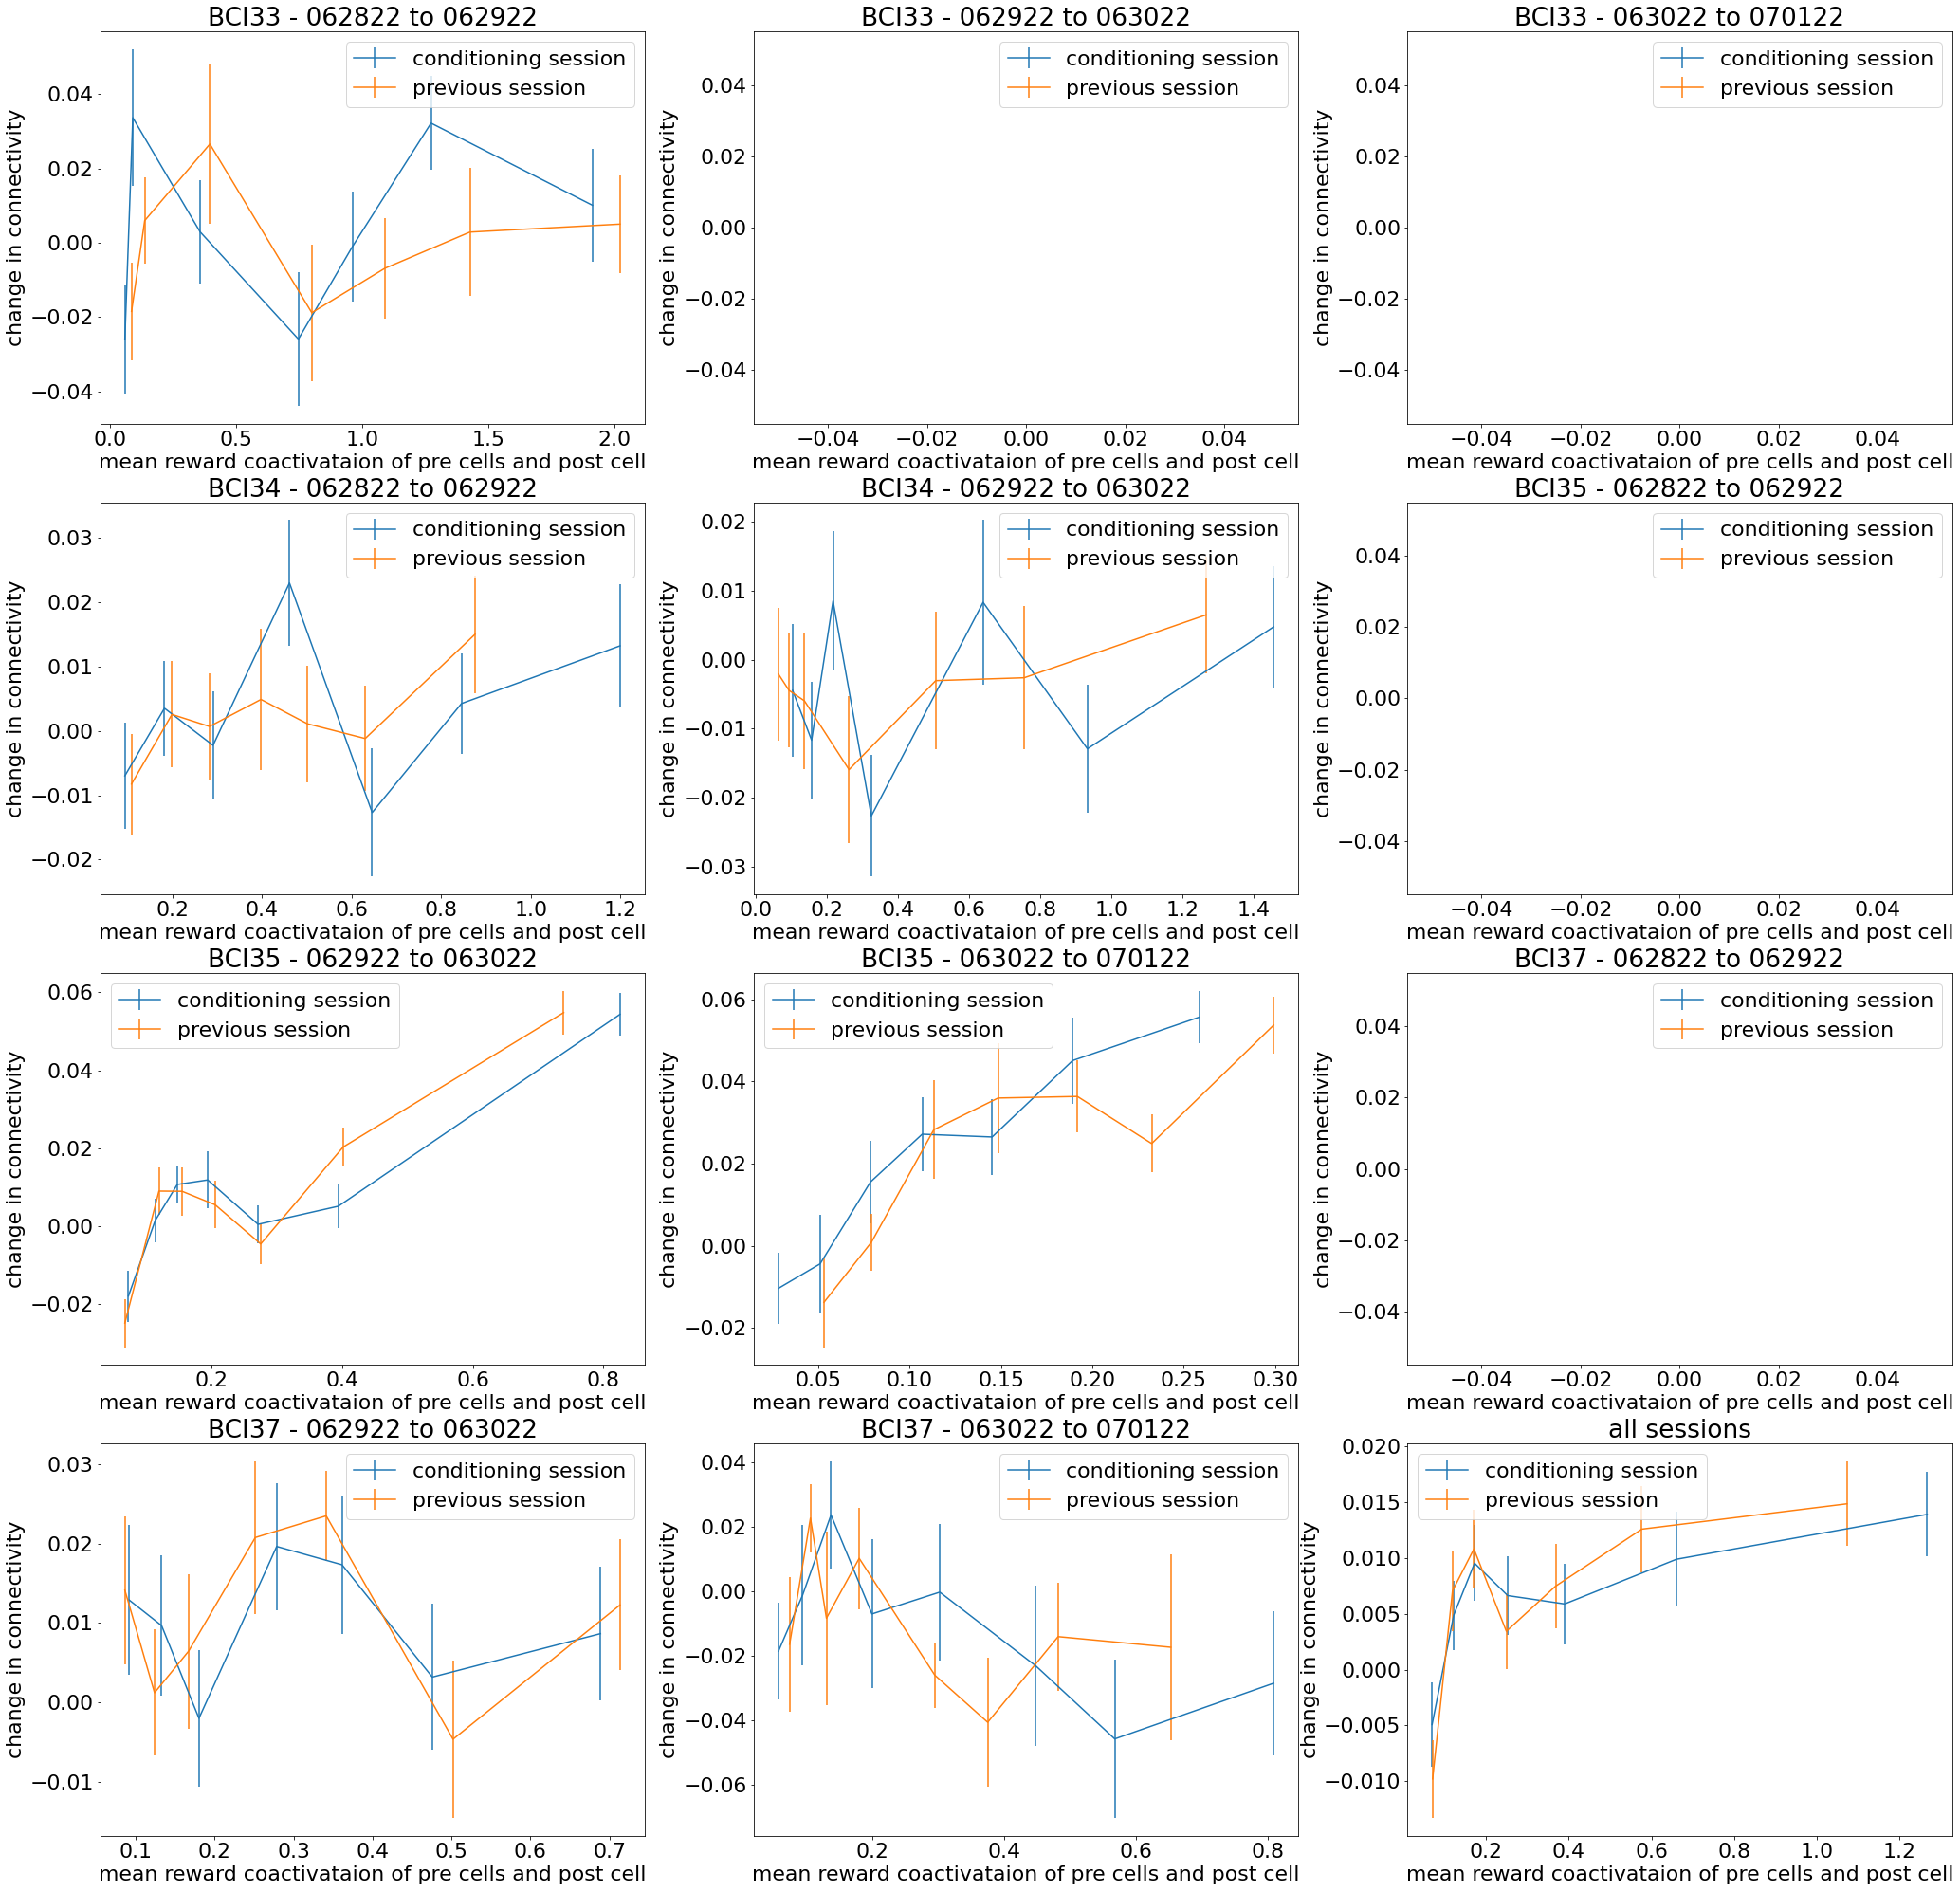

In [647]:
bin_num = 7
xlabel = 'mean reward coactivataion of pre cells and post cell'#'direct photostim in cells coactivate during reward'
fig = plt.figure(figsize = [35,35])
#ax = fig.add_subplot(1,1,1)
for i,(x_list,y_list_,x_list_yesterday,title) in enumerate(zip(all_x_lists,all_y_lists,all_x_yesterday_lists,plot_titles_list)):
    
    # if i == 0:
    #     ax = fig.add_subplot(4,3,i+1)
    # else:
    #     ax = fig.add_subplot(4,3,i+1,sharex = ax,sharey = ax)
    ax = fig.add_subplot(4,3,i+1)
    
    todel = x_list<=0
    x_list = x_list[todel == False]
    y_list = y_list_[todel == False]
    
    bin_x = []
    bin_y = []
    bin_y_error = []
    if len(x_list)>0:
        

        x_sorted = np.sort(x_list)
        x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
        x_ends = x_starts[1:]
        x_starts = x_starts[:-1]


        for x_s,x_e in zip(x_starts,x_ends):
            needed_indices = (x_list>=x_s)&(x_list<=x_e)
            n = sum(needed_indices)
            bin_x.append(np.nanmean(x_list[needed_indices]))
            bin_y.append(np.nanmean(y_list[needed_indices]))
            bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
    # plt.plot(x_list,y_list,'k.',alpha = .1)
    
    
    todel = x_list_yesterday<=0
    x_list_yesterday = x_list_yesterday[todel == False]
    y_list = y_list_[todel == False]
    
    bin_x_yesterday = []
    bin_y_yesterday = []
    bin_y_error_yesterday = []
    if len(x_list_yesterday)>0:
        x_sorted = np.sort(x_list_yesterday)
        x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
        x_ends = x_starts[1:]
        x_starts = x_starts[:-1]

        for x_s,x_e in zip(x_starts,x_ends):
            needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
            n = sum(needed_indices)
            bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
            bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
            bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


    # plt.xlim(np.percentile(x_list,[1,99]))

    ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
    ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('change in connectivity')
    ax.set_title(title)
    ax.legend()
#fig = plt.figure()
ax = fig.add_subplot(4,3,i+2)#,sharex = ax,sharey = ax)
x_list = np.concatenate(all_x_lists)
y_list_= np.concatenate(all_y_lists)
x_list_yesterday= np.concatenate(all_x_yesterday_lists)
title = 'all sessions'

todel = x_list<=0
x_list = x_list[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list)
x_starts = x_sorted[::int(np.floor(len(x_list)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]

bin_x = []
bin_y = []
bin_y_error = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list>=x_s)&(x_list<=x_e)
    n = sum(needed_indices)
    bin_x.append(np.nanmean(x_list[needed_indices]))
    bin_y.append(np.nanmean(y_list[needed_indices]))
    bin_y_error.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))
# plt.plot(x_list,y_list,'k.',alpha = .1)


todel = x_list_yesterday<=0
x_list_yesterday = x_list_yesterday[todel == False]
y_list = y_list_[todel == False]

x_sorted = np.sort(x_list_yesterday)
x_starts = x_sorted[::int(np.floor(len(x_list_yesterday)/(bin_num)))-1]
x_ends = x_starts[1:]
x_starts = x_starts[:-1]
bin_x_yesterday = []
bin_y_yesterday = []
bin_y_error_yesterday = []
for x_s,x_e in zip(x_starts,x_ends):
    needed_indices = (x_list_yesterday>=x_s)&(x_list_yesterday<=x_e)
    n = sum(needed_indices)
    bin_x_yesterday.append(np.nanmean(x_list_yesterday[needed_indices]))
    bin_y_yesterday.append(np.nanmean(y_list[needed_indices]))
    bin_y_error_yesterday.append(np.nanstd(y_list[needed_indices])/np.sqrt(n))


# plt.xlim(np.percentile(x_list,[1,99]))
ax.errorbar(bin_x,bin_y,bin_y_error,label = 'conditioning session')
ax.errorbar(bin_x_yesterday,bin_y_yesterday,bin_y_error_yesterday,label = 'previous session')
ax.legend()
ax.set_xlabel(xlabel)
ax.set_ylabel('change in connectivity')
ax.set_title(title)